In [3]:
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
channel_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel Tide')
berth_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Berth Tide')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = InputVariables.iloc[4, 2]  #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = InputVariables.iloc[5, 2]  #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
n_ = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V_name = VesselSchedule['Vessel Name'].tolist() #Vessel
TOi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
D = np.array([[d[0]] for d in Dij], dtype=float)  # Đảm bảo D là mảng float (V, 1)
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = InputVariables.iloc[20, 2] #Crane
Y = [i for i in range(1, 46)] #Truck
k1 = InputVariables.iloc[21, 2]
k2 = InputVariables.iloc[22, 2]
k3 = InputVariables.iloc[23, 2]
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang
TAi = []    # Thời gian đến thực tế sau khi cộng độ lệch
TE = [] #thời gian khởi hành của tàu đi ra khỏi kênh khi rời cảng
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
fitSOA = []
fitASOA = []
fitQSOA = []
fitCSOA = []
fitCQASOA = []
fitSSA = []
fitQSSA = []
fitCSSA = []
fitCQSSA = []

def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TOi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TE.append(TF_float[i] - TWi[i])
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TC = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng

delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

np.random.seed(42)
V = len(V_name)   # Số tàu
B = 2   # Số bến
Y = M  # Số xe
Y = 40
M = 99999  # Penalty
TW0 = 24  # Thời gian chờ tối đa (h)
T = 24
CK = np.random.randint(0, 4, size=(C, T))
# Dữ liệu đầu vào
# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)


D = np.array(np.array(Dij))
DMN = 14

Iter 1, Best Fitness: 21590331.83799934
Iter 2, Best Fitness: 21579332.31847934
Iter 3, Best Fitness: 21560332.30860734
Iter 4, Best Fitness: 21550331.35087134
Iter 5, Best Fitness: 21550331.35087134
Iter 6, Best Fitness: 21549331.83510334
Iter 7, Best Fitness: 21547331.23951934
Iter 8, Best Fitness: 21546331.11271134
Iter 9, Best Fitness: 21546331.11271134
Iter 10, Best Fitness: 21545331.052367337
Iter 11, Best Fitness: 21545330.99715934
Iter 12, Best Fitness: 21545330.898535337
Iter 13, Best Fitness: 21545330.862623338
Iter 14, Best Fitness: 21545330.84386334
Iter 15, Best Fitness: 21545330.79347934
Iter 16, Best Fitness: 21544330.81407134
Iter 17, Best Fitness: 21544330.72884734
Iter 18, Best Fitness: 21544330.72884734
Iter 19, Best Fitness: 21544330.72080734
Iter 20, Best Fitness: 21543330.75211934
Iter 21, Best Fitness: 21543330.66582334
Iter 22, Best Fitness: 21543330.641703337
Iter 23, Best Fitness: 21543330.641703337
Iter 24, Best Fitness: 21543330.641703337
Iter 25, Best Fitne

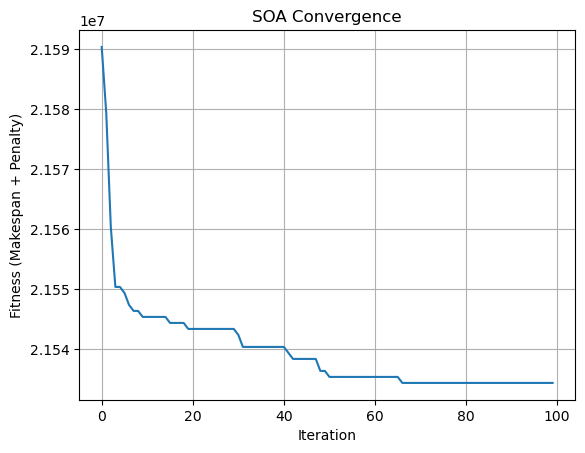


Best Solution:
1. Phân bổ tàu-bến (x):
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]

2. Phân bổ cần cẩu (q):
[[1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]]

3. Phân bổ xe (y):
[[0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0
  1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
  1 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 

In [ ]:
h = np.random.normal(loc=750, scale=150)
TS = [TC[i] + h for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
TA = np.array(TS)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TS))    # Giờ
Dl_ = np.random.normal(loc=Dl, scale=Dl*0.2)
Dk_ = np.random.normal(loc=Dk, scale=Dk*0.2)
n_1 = np.random.normal(loc=n_, scale=n_*0.1)
tn_1 = np.random.normal(loc=tn_, scale=tn_*0.15)
lambda1_1 = np.random.normal(loc=lambda1, scale=lambda1*0.1)
lambda2_1 = np.random.normal(loc=lambda2, scale=lambda2*0.1)
# ==================== HÀM NGOÀI CLASS ====================
def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

# Hàm lấy độ sâu trung bình trong khoảng thời gian
def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None
def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
def enforce_vessel_berth_constraint(x):
    for i in range(x.shape[0]):
        # Nếu không có bến nào được gán, gán ngẫu nhiên 1 bến
        if np.sum(x[i]) == 0:
            x[i, np.random.randint(x.shape[1])] = 1
        # Nếu có nhiều hơn 1 bến, chỉ giữ lại 1 bến (có thể chọn bến đầu tiên hoặc ngẫu nhiên)
        elif np.sum(x[i]) > 1:
            ones = np.where(x[i] == 1)[0]
            keep = np.random.choice(ones)
            x[i] = 0
            x[i, keep] = 1
    return x
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q
def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D
def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True
def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True
def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals
def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False
def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback
def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A
def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane
def check_berth_safety_constraint(x, VLi, BLj, LSd, LSe):
    V, B = x.shape
    for j in range(B):
        ships = [i for i in range(V) if x[i][j] == 1]
        if not ships:
            continue
        total_length = 0
        total_LSe = 0
        total_LSd = 0
        for idx, i in enumerate(ships):
            ship_type = get_ship_type(VLi[i])
            total_length += VLi[i]
            total_LSe += LSe[ship_type]
            # Khoảng cách giữa các tàu
            if idx > 0:
                prev_ship_type = get_ship_type(VLi[ships[idx-1]])
                # Lấy max khoảng cách giữa 2 tàu liền kề
                total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
        # Nếu chỉ có 1 tàu thì chỉ cộng 1 lần LSd/2
        if len(ships) == 1:
            ship_type = get_ship_type(VLi[ships[0]])
            total_LSd += LSd[ship_type] / 2
        if total_length + total_LSe + total_LSd > BLj[j]:
            return False
    return True

# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
    
    def calculate_F1(self, TF, TA):
        v = len(TF)
        total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
        F1 = (1 / v) * total
        return F1
    
    def calculate_F2(self, E1, Dl, Dk, n_, tn_):
        pl = calculate_pvl(vh, l1)
        pk = calculate_pvl(vl, l2)
        F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
        return F2
        
    def calculate_F3(self, TD, TS, TV, E2, delVCit, lambda1, lambda2):
        part1 = 0
        part2 = 0
        part3 = 0
        for i in range(len(TD)):
            part1 += (TD[i] - TS[i]) * VCi[i]
            part2 += (TD[i] - TV[i]) * delVCit[i]
            part3 += delVCit[i]
        F3 = (E2 * (lambda1 * (part1 + part2) + lambda2 * part3)) / 3600
        return F3

    def calculate_k123(self, a, b, c):
        return float(1)/a, float(1)/b, float(1)/c

    def calculate_F(self, sol):
        # Tính toán các tham số cần thiết
        F1 = self.calculate_F1(TF_float, TS)
        F2 = self.calculate_F2(E1, Dl_, Dk_, n_1, tn_1)
        F3 = self.calculate_F3(TD, TS, TV, E2, delVCit, lambda1_1, lambda2_1)
        
        F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
        return F, F1, F2, F3
    
    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến
            for i in range(V):
                sol['x'][i, np.random.randint(B)] = 1
            
            # Phân bổ cần cẩu
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                selected = np.random.choice(C, num_cranes, replace=False)
                sol['q'][i, selected] = 1
            
            # Phân bổ xe
            for i in range(V):
                num_trucks = np.random.randint(1, min(Y, 10) + 1)
                selected = np.random.choice(Y, num_trucks, replace=False)
                sol['y'][i, selected] = 1
            
            self.population.append(sol)
    
    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)  # penalty mềm
    
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
    
        for j in range(B):
        # Lấy danh sách các tàu vào bến j
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            # Sắp xếp các tàu theo thời gian đến
            ships = sorted(ships, key=lambda i: TA[i])
            # Duyệt từng tàu
            for idx, i in enumerate(ships):
                berth = j
                assigned_cranes = np.sum(sol['q'][i])
                assigned_trucks = np.sum(sol['y'][i])
                if assigned_cranes == 0 or assigned_trucks == 0:
                    penalty += 10000
                    continue
                # Kiểm tra mớn nước
                if VDi[i] > BDj[berth]:
                    penalty += 10000
                # Kiểm tra chiều dài tàu không vượt quá chiều dài bến (từng tàu)
                if VLi[i] > BLj[berth]:
                    penalty += 10000
                # Tính thời gian phục vụ tàu i
                arrival_dt = float_to_datetime(TA[i])
                arrival_date = arrival_dt.date()
                arrival_hour = arrival_dt.hour + arrival_dt.minute/60

                # Lấy độ sâu tại bến theo giờ
                berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))
                if berth_depth is None:
                    # Nếu không có dữ liệu, sử dụng giá trị mặc định
                    berth_depth = BDj[berth]

                # Kiểm tra mớn nước tàu so với độ sâu bến
                if VDi[i] > berth_depth:
                    penalty += 10000

                # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều
                if VDi[i] > DMN:
                    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
                    if channel_depth is None:
                        channel_depth = DMN  # Giá trị mặc định nếu không có dữ liệu

                    if VDi[i] > channel_depth:
                        # Tìm thời điểm thủy triều cao tiếp theo
                        next_high_tide = next_high_tide_time(arrival_dt, tide_intervals)
                        TA_adjusted = convert_time_to_float(next_high_tide)
                    else:
                        TA_adjusted = TA[i]
                else:
                    TA_adjusted = TA[i]
                    
                start_time = max(float(TA_adjusted), float(berth_schedule[berth]))
                processing_time = float((VEi[i] * CF0) / assigned_cranes)
                transport_delay = D[i, berth] / (assigned_trucks + 1e-5)
                completion = float(start_time + processing_time + transport_delay)
                # Lưu lại thời gian phục vụ để kiểm tra chồng lấn
                sol['start_time'] = sol.get('start_time', np.zeros((V, B)))
                sol['completion'] = sol.get('completion', np.zeros((V, B)))
                sol['start_time'][i, berth] = start_time
                sol['completion'][i, berth] = completion
        
            # Kiểm tra các nhóm tàu cùng lúc ở bến j
            for t_idx in range(len(ships)):
                i = ships[t_idx]
                for k_idx in range(t_idx+1, len(ships)):
                    k = ships[k_idx]
                    # Nếu thời gian phục vụ chồng lấn
                    if not (sol['completion'][i, j] <= sol['start_time'][k, j] or sol['completion'][k, j] <= sol['start_time'][i, j]):
                        # Lấy các tàu đang cùng lúc ở bến
                        overlap_ships = [m for m in ships if not (sol['completion'][m, j] <= sol['start_time'][i, j] or sol['start_time'][m, j] >= sol['completion'][i, j])]
                        total_length = 0
                        total_LSe = 0
                        total_LSd = 0
                        for s_idx, m in enumerate(overlap_ships):
                            ship_type = get_ship_type(VLi[m])
                            total_length += VLi[m]
                            total_LSe += LSe[ship_type]
                            if s_idx > 0:
                                prev_ship_type = get_ship_type(VLi[overlap_ships[s_idx-1]])
                                total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
                        if len(overlap_ships) == 1:
                            ship_type = get_ship_type(VLi[overlap_ships[0]])
                            total_LSd += LSd[ship_type] / 2
                        if total_length + total_LSe + total_LSd > BLj[j]:
                            penalty += 10000
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        F, F1, F2, F3 = self.calculate_F(sol)
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty + F


    
    def attack_prey(self, best_sol, current_sol):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask = np.random.rand(*current_sol[key].shape) < 0.5
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol):
        new_sol = deepcopy(sol)
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < 0.1
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        # Đột biến có kiểm soát cho cần cẩu
        for i in range(V):
            if np.random.rand() < 0.1:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i])
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            fitSOA.append(fitness_history[-1])
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        
        plt.plot(fitness_history)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================


print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
end_times = []
sum_ = 0
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    sum_ += handling_time + wait
    end = start + handling_time
    end_times.append(end)
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

F, F1, F2, F3 = soa.calculate_F(best_solution)
print("\nCác giá trị mục tiêu:")
print(f"F1 (Thời gian trung bình): {F1 / 3600} giờ")
print(f"F2 (Phát thải carbon từ xe tải): {F2 / 3600} kg CO2")
print(f"F3 (Phát thải carbon từ cần cẩu): {F3} kg CO2")
print(f"F (Hàm mục tiêu tổng hợp): {F / 3600}")
makespan = sum_ / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan} giờ")

berth_schedule = {j: 0 for j in range(B)}
output_rows = []
for idx, i in enumerate(np.argsort(TA)):
    berth = int(np.argmax(best_solution['x'][i]))
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else None
    end = start + handling_time if handling_time is not None else None
    berth_schedule[berth] = start + PT[i]

    # Lấy độ sâu channel và berth tại thời điểm tàu vào
    arrival_dt = float_to_datetime(TA[i])
    arrival_date = arrival_dt.date()
    arrival_hour = arrival_dt.hour + arrival_dt.minute/60
    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
    berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))

    berth_name = ChannelBerth['Tên bến'][berth] if 'Tên bến' in ChannelBerth.columns else f"Bến {berth+1}"
    cranes = np.where(best_solution['q'][i] == 1)[0]
    trucks = np.where(best_solution['y'][i] == 1)[0]

    output_rows.append({
        "Index": idx + 1,
        "Vessel Name": V_name[i],
        "TOi": float_to_datetime(TO_float[i]),
        "TFi": float_to_datetime(TF_float[i]),
        "TWi": TWi[i],
        "TC": float_to_datetime(TC[i]),
        "TS": float_to_datetime(TS[i]),
        "VLi": VLi[i],
        "VDi": VDi[i],
        "VEi": VEi[i],
        "VCmi": VCmi[i],
        "VCMi": VCMi[i],
        "Di1": lst1[i],
        "Di2": lst2[i],
        "LSd": LSd[get_ship_type(VLi[i])],
        "LSe": LSe[get_ship_type(VLi[i])],
        "channel_tide": channel_depth,
        "berth_tide": berth_depth,
        "Phân bổ bến": berth_name,
        "Phân bổ cần cẩu": ",".join(str(c+1) for c in cranes),
        "Phân bổ xe": ",".join(str(t+1) for t in trucks),
        "Thời gian chờ": wait / 3600 if wait is not None else None,
        "Thời gian bắt đầu": float_to_datetime(start) if start is not None else None,
        "Thời điểm kết thúc dự kiến": float_to_datetime(end) if end is not None else None,
    })

# Tạo DataFrame và xuất ra Excel
df_output = pd.DataFrame(output_rows)
columns_order = [
    "Index", "Vessel Name", "TOi", "TFi", "TWi", "TC", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
    "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
    "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
]
df_output = df_output[columns_order]
output_path = r"E:\KLTN_DUU\Source\Data\SOA_Output.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    df_output.to_excel(writer, sheet_name='SOA_Output', index=False)
print(f"\nĐã xuất file Excel ra: {output_path}")

In [34]:
h = np.random.normal(loc=750, scale=150)
TS = [TC[i] + h for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
TA = np.array(TS)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TS))    # Giờ
Dl_ = np.random.normal(loc=Dl, scale=Dl*0.2)
Dk_ = np.random.normal(loc=Dk, scale=Dk*0.2)
n_1 = np.random.normal(loc=n_, scale=n_*0.1)
tn_1 = np.random.normal(loc=tn_, scale=tn_*0.15)
lambda1_1 = np.random.normal(loc=lambda1, scale=lambda1*0.1)
lambda2_1 = np.random.normal(loc=lambda2, scale=lambda2*0.1)
# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D


def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False


def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback




def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
    def calculate_F1(self, TF, TA):
        v = len(TF)
        total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
        F1 = (1 / v) * total
        return F1
    
    def calculate_F2(self, E1, Dl, Dk, n_, tn_):
        pl = calculate_pvl(vh, l1)
        pk = calculate_pvl(vl, l2)
        F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
        return F2
        
    def calculate_F3(self, TD, TS, TV, E2, delVCit, lambda1, lambda2):
        part1 = 0
        part2 = 0
        part3 = 0
        for i in range(len(TD)):
            part1 += (TD[i] - TS[i]) * VCi[i]
            part2 += (TD[i] - TV[i]) * delVCit[i]
            part3 += delVCit[i]
        F3 = (E2 * (lambda1 * (part1 + part2) + lambda2 * part3)) / 3600
        return F3

    def calculate_k123(self, a, b, c):
        return float(1)/a, float(1)/b, float(1)/c

    def calculate_F(self, sol):
        # Tính toán các tham số cần thiết
        F1 = self.calculate_F1(TF_float, TS)
        F2 = self.calculate_F2(E1, Dl, Dk, n_, tn_)
        F3 = self.calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
        
        F = w1 * 1000 * F1 + w2 * 1 * F2 + w3 * 1 * F3
        return F, F1, F2, F3
    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến
            for i in range(V):
                sol['x'][i, np.random.randint(B)] = 1
            
            # Phân bổ cần cẩu
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                selected = np.random.choice(C, num_cranes, replace=False)
                sol['q'][i, selected] = 1
            
            # Phân bổ xe
            for i in range(V):
                num_trucks = np.random.randint(5, 11)
                selected = np.random.choice(Y, num_trucks, replace=False)
                sol['y'][i, selected] = 1
            
            self.population.append(sol)
    def calc_A(self, t):
        fc = 2
        return fc * (np.cos(np.pi * (t / self.max_iter)) + 1) / 2
    
    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)
    
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
    
        # Lưu lại thời gian phục vụ từng tàu ở từng bến
        start_times = np.zeros((V, B))
        completion_times_matrix = np.zeros((V, B))
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            ships = sorted(ships, key=lambda i: TA[i])
            for idx, i in enumerate(ships):
                assigned_cranes = np.sum(sol['q'][i])
                assigned_trucks = np.sum(sol['y'][i])
                if assigned_cranes == 0 or assigned_trucks == 0:
                    penalty += 10000
                    continue
                if VDi[i] > BDj[j]:
                    penalty += 10000
                if VLi[i] > BLj[j]:
                    penalty += 10000
                # Tính thời gian phục vụ tàu i
                arrival_dt = float_to_datetime(TA[i])
                arrival_date = arrival_dt.date()
                arrival_hour = arrival_dt.hour + arrival_dt.minute/60

                # Lấy độ sâu tại bến theo giờ
                berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))
                if berth_depth is None:
                    # Nếu không có dữ liệu, sử dụng giá trị mặc định
                    berth_depth = BDj[berth]

                # Kiểm tra mớn nước tàu so với độ sâu bến
                if VDi[i] > berth_depth:
                    penalty += 10000

                # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều
                if VDi[i] > DMN:
                    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
                    if channel_depth is None:
                        channel_depth = DMN  # Giá trị mặc định nếu không có dữ liệu

                    if VDi[i] > channel_depth:
                        # Tìm thời điểm thủy triều cao tiếp theo
                        next_high_tide = next_high_tide_time(arrival_dt, tide_intervals)
                        TA_adjusted = convert_time_to_float(next_high_tide)
                    else:
                        TA_adjusted = TA[i]
                else:
                    TA_adjusted = TA[i]
                start_time = max(float(TA_adjusted), float(berth_schedule[j]))
                processing_time = float((VEi[i] * CF0) / assigned_cranes)
                transport_delay = D[i, j] / (assigned_trucks + 1e-5)
                completion = float(start_time + processing_time + transport_delay)
                start_times[i, j] = start_time
                completion_times_matrix[i, j] = completion
                berth_schedule[j] = completion
    
        # Kiểm tra các nhóm tàu cùng lúc ở bến j
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            for idx, i in enumerate(ships):
                for kdx in range(idx+1, len(ships)):
                    k = ships[kdx]
                    # Nếu thời gian phục vụ chồng lấn
                    if not (completion_times_matrix[i, j] <= start_times[k, j] or completion_times_matrix[k, j] <= start_times[i, j]):
                        # Lấy các tàu đang cùng lúc ở bến
                        overlap_ships = [m for m in ships if not (completion_times_matrix[m, j] <= start_times[i, j] or start_times[m, j] >= completion_times_matrix[i, j])]
                        total_length = 0
                        total_LSe = 0
                        total_LSd = 0
                        for s_idx, m in enumerate(overlap_ships):
                            ship_type = get_ship_type(VLi[m])
                            total_length += VLi[m]
                            total_LSe += LSe[ship_type]
                            if s_idx > 0:
                                prev_ship_type = get_ship_type(VLi[overlap_ships[s_idx-1]])
                                total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
                        if len(overlap_ships) == 1:
                            ship_type = get_ship_type(VLi[overlap_ships[0]])
                            total_LSd += LSd[ship_type] / 2
                        if total_length + total_LSe + total_LSd > BLj[j]:
                            penalty += 10000
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        F, F1, F2, F3 = self.calculate_F(sol)
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty + F


    
    def attack_prey(self, best_sol, current_sol, A):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask_prob = 0.7 * (A / 2) + 0.3  # mask_prob từ 1.0 -> 0.3
            mask = np.random.rand(*current_sol[key].shape) < mask_prob
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol, A):
        new_sol = deepcopy(sol)
        mutation_rate = 0.2 * (A / 2) + 0.05  # mutation_rate từ 0.2 -> 0.05
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < mutation_rate
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        # Đột biến nhẹ cho q
        for i in range(V):
            if np.random.rand() < mutation_rate:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        for iter in range(self.max_iter):
            A = self.calc_A(iter)
            migrate_prob = 0.3 * (A / 2) + 0.1  # migrate_prob từ 0.4 -> 0.1
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i], A)
                if np.random.rand() < migrate_prob:
                    new_sol = self.migrate(new_sol, A)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            fitness_history.append(self.fitness(best_sol))
            fitASOA.append(fitness_history[-1])
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("ASOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
end_times = []
sum_ = 0
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    sum_ += handling_time + wait
    end = start + handling_time
    end_times.append(end)
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

F, F1, F2, F3 = soa.calculate_F(best_solution)
print("\nCác giá trị mục tiêu:")
print(f"F1 (Thời gian trung bình): {F1 / 3600} giờ")
print(f"F2 (Phát thải carbon từ xe tải): {F2 / 3600} kg CO2")
print(f"F3 (Phát thải carbon từ cần cẩu): {F3} kg CO2")
print(f"F (Hàm mục tiêu tổng hợp): {F / 3600}")
makespan = sum_ / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan} giờ")

berth_schedule = {j: 0 for j in range(B)}
output_rows = []
for idx, i in enumerate(np.argsort(TA)):
    berth = int(np.argmax(best_solution['x'][i]))
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else None
    end = start + handling_time if handling_time is not None else None
    berth_schedule[berth] = start + PT[i]

    # Lấy độ sâu channel và berth tại thời điểm tàu vào
    arrival_dt = float_to_datetime(TA[i])
    arrival_date = arrival_dt.date()
    arrival_hour = arrival_dt.hour + arrival_dt.minute/60
    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
    berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))

    berth_name = ChannelBerth['Tên bến'][berth] if 'Tên bến' in ChannelBerth.columns else f"Bến {berth+1}"
    cranes = np.where(best_solution['q'][i] == 1)[0]
    trucks = np.where(best_solution['y'][i] == 1)[0]

    output_rows.append({
        "Index": idx + 1,
        "Vessel Name": V_name[i],
        "TOi": float_to_datetime(TO_float[i]),
        "TFi": float_to_datetime(TF_float[i]),
        "TWi": TWi[i],
        "TC": float_to_datetime(TC[i]),
        "TS": float_to_datetime(TS[i]),
        "VLi": VLi[i],
        "VDi": VDi[i],
        "VEi": VEi[i],
        "VCmi": VCmi[i],
        "VCMi": VCMi[i],
        "Di1": lst1[i],
        "Di2": lst2[i],
        "LSd": LSd[get_ship_type(VLi[i])],
        "LSe": LSe[get_ship_type(VLi[i])],
        "channel_tide": channel_depth,
        "berth_tide": berth_depth,
        "Phân bổ bến": berth_name,
        "Phân bổ cần cẩu": ",".join(str(c+1) for c in cranes),
        "Phân bổ xe": ",".join(str(t+1) for t in trucks),
        "Thời gian chờ": wait / 3600 if wait is not None else None,
        "Thời gian bắt đầu": float_to_datetime(start) if start is not None else None,
        "Thời điểm kết thúc dự kiến": float_to_datetime(end) if end is not None else None,
    })

# Tạo DataFrame và xuất ra Excel
df_output = pd.DataFrame(output_rows)
columns_order = [
    "Index", "Vessel Name", "TOi", "TFi", "TWi", "TC", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
    "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
    "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
]
df_output = df_output[columns_order]
output_path = r"E:\KLTN_DUU\Source\Data\ASOA_Output.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    df_output.to_excel(writer, sheet_name='ASOA_Output', index=False)
print(f"\nĐã xuất file Excel ra: {output_path}")

TypeError: 'list' object cannot be interpreted as an integer

Iter 1, Best Fitness: 22724482.1057852
Iter 2, Best Fitness: 22624483.0910012
Iter 3, Best Fitness: 22624483.0910012
Iter 4, Best Fitness: 22524484.2344252
Iter 5, Best Fitness: 22524484.2076252
Iter 6, Best Fitness: 22524484.2076252
Iter 7, Best Fitness: 22524484.2076252
Iter 8, Best Fitness: 22524484.2076252
Iter 9, Best Fitness: 22524483.8389052
Iter 10, Best Fitness: 22524483.8389052
Iter 11, Best Fitness: 22524483.8389052
Iter 12, Best Fitness: 22524483.8389052
Iter 13, Best Fitness: 22524483.8389052
Iter 14, Best Fitness: 22524483.8389052
Iter 15, Best Fitness: 22224487.4033532
Iter 16, Best Fitness: 22224487.4033532
Iter 17, Best Fitness: 22224487.4033532
Iter 18, Best Fitness: 22224487.4033532
Iter 19, Best Fitness: 22224487.3362652
Iter 20, Best Fitness: 22224487.3362652
Iter 21, Best Fitness: 22224487.3362652
Iter 22, Best Fitness: 22224487.3242492
Iter 23, Best Fitness: 22224487.3242492
Iter 24, Best Fitness: 22224487.245145198
Iter 25, Best Fitness: 22224487.0667932
Iter 26

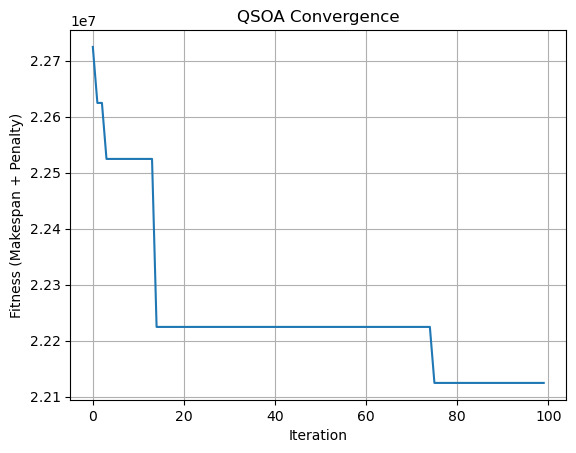


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 0 1 0]
 [0 1 1 1 1 0]
 [0 0 0 1 0 0]
 [1 0 0 0 1 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [0 0 1 0 0 0]
 [1 1 0 0 1 0]
 [0 1 0 1 0 0]
 [1 1 0 0 0 0]
 [0 1 0 1 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 1]
 [0 0 0 0 1 0]
 [0 0 1 0 1 0]
 [0 0 1 1 1 0]
 [1 0 0 0 0 0]
 [0 0 1 1 1 0]]

3. Phân bổ xe (y):
[[0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
  0 1 1 1]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0
  0 1 0 0]
 [0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0
  0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1
  0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 

In [ ]:
h = np.random.normal(loc=750, scale=150)
TS = [TC[i] + h for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
TA = np.array(TS)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TS))    # Giờ
Dl_ = np.random.normal(loc=Dl, scale=Dl*0.2)
Dk_ = np.random.normal(loc=Dk, scale=Dk*0.2)
n_1 = np.random.normal(loc=n_, scale=n_*0.1)
tn_1 = np.random.normal(loc=tn_, scale=tn_*0.15)
lambda1_1 = np.random.normal(loc=lambda1, scale=lambda1*0.1)
lambda2_1 = np.random.normal(loc=lambda2, scale=lambda2*0.1)
# ==================== HÀM NGOÀI CLASS ====================
def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

# Hàm lấy độ sâu trung bình trong khoảng thời gian
def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None
def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
def enforce_vessel_berth_constraint(x):
    for i in range(x.shape[0]):
        # Nếu không có bến nào được gán, gán ngẫu nhiên 1 bến
        if np.sum(x[i]) == 0:
            x[i, np.random.randint(x.shape[1])] = 1
        # Nếu có nhiều hơn 1 bến, chỉ giữ lại 1 bến (có thể chọn bến đầu tiên hoặc ngẫu nhiên)
        elif np.sum(x[i]) > 1:
            ones = np.where(x[i] == 1)[0]
            keep = np.random.choice(ones)
            x[i] = 0
            x[i, keep] = 1
    return x
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D

def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True

def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False

def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback


def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def enforce_crane_constraints_optimized(q, VCmi, VCMi, carbon_emission_matrix=None):
    for i in range(q.shape[0]):  # với mỗi tàu
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            # Ưu tiên chọn cần cẩu có phát thải thấp nhất
            if carbon_emission_matrix is not None:
                sorted_idx = available[np.argsort(carbon_emission_matrix[i, available])]
            else:
                sorted_idx = available
            to_add = VCmi[i] - num_assigned
            selected = sorted_idx[:to_add]
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            # Loại bỏ cần cẩu có phát thải cao nhất
            if carbon_emission_matrix is not None:
                sorted_idx = assigned[np.argsort(-carbon_emission_matrix[i, assigned])]
            else:
                sorted_idx = assigned
            to_remove = num_assigned - VCMi[i]
            selected = sorted_idx[:to_remove]
            q[i, selected] = 0
    return q

def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
# === HÀM QUANTUM GATE ===
def quantum_revolving_gate(phi, delta_phi):
    return phi + delta_phi

def quantum_not_gate(phi):
    return np.pi/2 - phi

# === QSOA CLASS ===
class QuantumSeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200, pm=0.1):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.pm = pm  # probability of NOT gate

    def calculate_F1(self, TF, TA):
        v = len(TF)
        total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
        F1 = (1 / v) * total
        return F1
    def calculate_F2(self, E1, Dl, Dk, n_, tn_):
        pl = calculate_pvl(vh, l1)
        pk = calculate_pvl(vl, l2)
        F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
        return F2
        
    def calculate_F3(self, TD, TS, TV, E2, delVCit, lambda1, lambda2):
        part1 = 0
        part2 = 0
        part3 = 0
        for i in range(len(TD)):
            part1 += (TD[i] - TS[i]) * VCi[i]
            part2 += (TD[i] - TV[i]) * delVCit[i]
            part3 += delVCit[i]
        F3 = (E2 * (lambda1 * (part1 + part2) + lambda2 * part3)) / 3600
        return F3
    def calculate_k123(self, a, b, c):
        return float(1)/a, float(1)/b, float(1)/c
    def calculate_F(self, sol):
        F1 = self.calculate_F1(TF_float, TS)
        F2 = self.calculate_F2(E1, Dl, Dk, n_, tn_)
        F3 = self.calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
        F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
        return F, F1, F2, F3


    def initialize(self):
        self.population_phi = []
        for _ in range(self.n_seagulls):
            phi = {
                'x': np.random.uniform(0, 2*np.pi, (V, B)),
                'q': np.random.uniform(0, 2*np.pi, (V, C)),
                'y': np.random.uniform(0, 2*np.pi, (V, Y))
            }
            self.population_phi.append(phi)
            
    @staticmethod
    def enforce_truck_constraints_optimized(y, num_trucks, min_truck_per_vessel=1, max_truck_per_vessel=10):
        V, M = y.shape
        # Step 1: Ensure each vessel has at least min_truck_per_vessel trucks, not exceeding max_truck_per_vessel
        for i in range(V):
            current = np.sum(y[i])
            if current < min_truck_per_vessel:
                available = np.where(np.sum(y, axis=0) == 0)[0]
                to_add = min_truck_per_vessel - current
                if len(available) >= to_add:
                    selected = np.random.choice(available, to_add, replace=False)
                    y[i, selected] = 1
                else:
                    selected = np.random.choice(M, to_add, replace=False)
                    y[i, selected] = 1
            if np.sum(y[i]) > max_truck_per_vessel:
                assigned = np.where(y[i] == 1)[0]
                to_remove = np.sum(y[i]) - max_truck_per_vessel
                selected = np.random.choice(assigned, to_remove, replace=False)
                y[i, selected] = 0

        # Step 2: Prioritize truck allocation for vessels with more cranes
        # if hasattr(self, 'last_q'):
        #     cranes_per_vessel = np.sum(self.last_q, axis=1)
        #     sort_idx = np.argsort(-cranes_per_vessel)  # tàu nhiều cần cẩu trước
        # else:
        sort_idx = np.arange(V)
        # Bước 3: Nếu tổng số xe vượt quá num_trucks, loại bớt xe từ tàu ít cần cẩu hơn
        while np.sum(y) > num_trucks:
            for i in reversed(sort_idx):
                assigned = np.where(y[i] == 1)[0]
                if len(assigned) > min_truck_per_vessel:
                    y[i, assigned[0]] = 0
                    break
            else:
                break
        # Bước 4: Nếu tổng số xe còn thiếu, phân bổ thêm cho tàu nhiều cần cẩu hơn
        while np.sum(y) < num_trucks:
            for i in sort_idx:
                assigned = np.where(y[i] == 0)[0]
                if np.sum(y[i]) < max_truck_per_vessel and len(assigned) > 0:
                    y[i, assigned[0]] = 1
                    break
            else:
                break
        return y
        
    
    def phi_to_solution(self, phi):
        x_bin = (np.cos(phi['x']) > 0).astype(int)
        for i in range(x_bin.shape[0]):
            if np.sum(x_bin[i]) != 1:
                idx = np.argmax(phi['x'][i])
                x_bin[i] = 0
                x_bin[i, idx] = 1
        q_bin = (np.cos(phi['q']) > 0).astype(int)
        q_bin = enforce_crane_constraints_optimized(q_bin, VCmi, VCMi)
        y_bin = (np.cos(phi['y']) > 0).astype(int)
        y_bin = self.enforce_truck_constraints_optimized(y_bin, M)
        return {'x': x_bin, 'q': q_bin, 'y': y_bin}

    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)

        tide_intervals = parse_tide_intervals(Tt)  # Giả định Tt là một danh sách ["3:00:00 - 6:00:00", ...]

        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += M
        
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += M
        
        # Lưu lại thời gian phục vụ từng tàu ở từng bến
        start_times = np.zeros((V, B))
        completion_times_matrix = np.zeros((V, B))
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            ships = sorted(ships, key=lambda i: TA[i])
            for idx, i in enumerate(ships):
                assigned_cranes = np.sum(sol['q'][i])
                assigned_trucks = np.sum(sol['y'][i])
                if assigned_cranes == 0 or assigned_trucks == 0:
                    penalty += M
                    continue
                if VDi[i] > BDj[j]:
                    penalty += M
                if VLi[i] > BLj[j]:
                    penalty += M
                # Tính thời gian phục vụ tàu i
                arrival_dt = float_to_datetime(TA[i])
                arrival_date = arrival_dt.date()
                arrival_hour = arrival_dt.hour + arrival_dt.minute/60

                # Lấy độ sâu tại bến theo giờ
                berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))
                if berth_depth is None:
                    # Nếu không có dữ liệu, sử dụng giá trị mặc định
                    berth_depth = BDj[j]

                # Kiểm tra mớn nước tàu so với độ sâu bến
                if VDi[i] > berth_depth:
                    penalty += 10000

                # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều
                if VDi[i] > DMN:
                    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
                    if channel_depth is None:
                        channel_depth = DMN  # Giá trị mặc định nếu không có dữ liệu

                    if VDi[i] > channel_depth:
                        # Tìm thời điểm thủy triều cao tiếp theo
                        next_high_tide = next_high_tide_time(arrival_dt, tide_intervals)
                        TA_adjusted = convert_time_to_float(next_high_tide)
                    else:
                        TA_adjusted = TA[i]
                else:
                    TA_adjusted = TA[i]
                start_time = max(float(TA_adjusted), float(berth_schedule[j]))
                processing_time = float((VEi[i] * CF0) / assigned_cranes)
                transport_delay = D[i, j] / (assigned_trucks + 1e-5)
                completion = float(start_time + processing_time + transport_delay)
                start_times[i, j] = start_time
                completion_times_matrix[i, j] = completion
                berth_schedule[j] = completion
        
        # Kiểm tra các nhóm tàu cùng lúc ở bến j
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            for idx, i in enumerate(ships):
                for kdx in range(idx+1, len(ships)):
                    k = ships[kdx]
                    # Nếu thời gian phục vụ chồng lấn
                    if not (completion_times_matrix[i, j] <= start_times[k, j] or completion_times_matrix[k, j] <= start_times[i, j]):
                        # Lấy các tàu đang cùng lúc ở bến
                        overlap_ships = [m for m in ships if not (completion_times_matrix[m, j] <= start_times[i, j] or start_times[m, j] >= completion_times_matrix[i, j])]
                        total_length = 0
                        total_LSe = 0
                        total_LSd = 0
                        for s_idx, m in enumerate(overlap_ships):
                            ship_type = get_ship_type(VLi[m])
                            total_length += VLi[m]
                            total_LSe += LSe[ship_type]
                            if s_idx > 0:
                                prev_ship_type = get_ship_type(VLi[overlap_ships[s_idx-1]])
                                total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
                        if len(overlap_ships) == 1:
                            ship_type = get_ship_type(VLi[overlap_ships[0]])
                            total_LSd += LSd[ship_type] / 2
                        if total_length + total_LSe + total_LSd > BLj[j]:
                            penalty += M
                    
        # Ràng buộc: Cần cẩu không nhảy qua nhau
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += M

        # Ràng buộc: Chiều dài tàu không vượt chiều dài bến
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += M

                # === BƯỚC 1: Xây dựng CK, A ===
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        # === BƯỚC 2: Kiểm tra ràng buộc xe tải ===
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += M * 10
        # === BƯỚC 3: Tính khí thải carbon ===
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        makespan = max(completion_times) if completion_times else M
        F, F1, F2, F3 = self.calculate_F(sol)
        fitness_value = makespan + w_carbon * (carbon_truck + carbon_crane) + penalty + F
        if fitness_value < 0:
            fitness_value = 1e12  # hoặc giá trị lớn dương
        return fitness_value

    def optimize(self):
        self.initialize()
        fitness_history = []
        best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
        best_sol = self.phi_to_solution(best_phi)

        for iter in range(self.max_iter):
            new_population_phi = []
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            new_population_phi.append(best_phi)
            for phi in self.population_phi:
                # --- Quantum Revolving Gate update ---
                delta_phi_x = np.random.uniform(-np.pi/16, np.pi/16, phi['x'].shape)
                delta_phi_q = np.random.uniform(-np.pi/16, np.pi/16, phi['q'].shape)
                delta_phi_y = np.random.uniform(-np.pi/16, np.pi/16, phi['y'].shape)
                phi_new = {
                    'x': quantum_revolving_gate(phi['x'], delta_phi_x),
                    'q': quantum_revolving_gate(phi['q'], delta_phi_q),
                    'y': quantum_revolving_gate(phi['y'], delta_phi_y)
                }
                # --- Quantum NOT Gate (với xác suất pm) ---
                if np.random.rand() < self.pm:
                    phi_new['x'] = quantum_not_gate(phi_new['x'])
                    phi_new['q'] = quantum_not_gate(phi_new['q'])
                    phi_new['y'] = quantum_not_gate(phi_new['y'])
                new_population_phi.append(phi_new)
            self.population_phi = new_population_phi
            best_phi = min(self.population_phi, key=lambda phi: self.fitness(self.phi_to_solution(phi)))
            best_sol = self.phi_to_solution(best_phi)
            fitness_history.append(self.fitness(best_sol))
            fitQSOA.append(fitness_history[-1])
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("QSOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# --- Hướng dẫn sử dụng ---
qsoa = QuantumSeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = qsoa.optimize()
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
end_times = []
sum_ = 0
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TA[i], berth_schedule[berth])
    wait = start - TA[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    sum_ += handling_time + wait
    end = start + handling_time
    end_times.append(end)
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

F, F1, F2, F3 = qsoa.calculate_F(best_solution)
print("\nCác giá trị mục tiêu:")
print(f"F1 (Thời gian trung bình): {F1 / 3600} giờ")
print(f"F2 (Phát thải carbon từ xe tải): {F2 / 3600} kg CO2")
print(f"F3 (Phát thải carbon từ cần cẩu): {F3} kg CO2")
print(f"F (Hàm mục tiêu tổng hợp): {F / 3600}")
makespan = sum_ / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan} giờ")

berth_schedule = {j: 0 for j in range(B)}
output_rows = []
for idx, i in enumerate(np.argsort(TA)):
    berth = int(np.argmax(best_solution['x'][i]))
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else None
    end = start + handling_time if handling_time is not None else None
    berth_schedule[berth] = start + PT[i]

    # Lấy độ sâu channel và berth tại thời điểm tàu vào
    arrival_dt = float_to_datetime(TA[i])
    arrival_date = arrival_dt.date()
    arrival_hour = arrival_dt.hour + arrival_dt.minute/60
    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
    berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))

    berth_name = ChannelBerth['Tên bến'][berth] if 'Tên bến' in ChannelBerth.columns else f"Bến {berth+1}"
    cranes = np.where(best_solution['q'][i] == 1)[0]
    trucks = np.where(best_solution['y'][i] == 1)[0]

    output_rows.append({
        "Index": idx + 1,
        "Vessel Name": V_name[i],
        "TOi": float_to_datetime(TO_float[i]),
        "TFi": float_to_datetime(TF_float[i]),
        "TWi": TWi[i],
        "TC": float_to_datetime(TC[i]),
        "TS": float_to_datetime(TS[i]),
        "VLi": VLi[i],
        "VDi": VDi[i],
        "VEi": VEi[i],
        "VCmi": VCmi[i],
        "VCMi": VCMi[i],
        "Di1": lst1[i],
        "Di2": lst2[i],
        "LSd": LSd[get_ship_type(VLi[i])],
        "LSe": LSe[get_ship_type(VLi[i])],
        "channel_tide": channel_depth,
        "berth_tide": berth_depth,
        "Phân bổ bến": berth_name,
        "Phân bổ cần cẩu": ",".join(str(c+1) for c in cranes),
        "Phân bổ xe": ",".join(str(t+1) for t in trucks),
        "Thời gian chờ": wait / 3600 if wait is not None else None,
        "Thời gian bắt đầu": float_to_datetime(start) if start is not None else None,
        "Thời điểm kết thúc dự kiến": float_to_datetime(end) if end is not None else None,
    })

# Tạo DataFrame và xuất ra Excel
df_output = pd.DataFrame(output_rows)
columns_order = [
    "Index", "Vessel Name", "TOi", "TFi", "TWi", "TC", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
    "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
    "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
]
df_output = df_output[columns_order]
output_path = r"E:\KLTN_DUU\Source\Data\QSOA_Output.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    df_output.to_excel(writer, sheet_name='QSOA_Output', index=False)
print(f"\nĐã xuất file Excel ra: {output_path}")

Iter 1, Best Fitness: 21597126.377273653
Iter 2, Best Fitness: 21594126.01453765
Iter 3, Best Fitness: 21593125.79178565
Iter 4, Best Fitness: 21591125.64000965
Iter 5, Best Fitness: 21589125.60829765
Iter 6, Best Fitness: 21588125.60262565
Iter 7, Best Fitness: 21587125.90676165
Iter 8, Best Fitness: 21584125.51454565
Iter 9, Best Fitness: 21584125.51454565
Iter 10, Best Fitness: 21584125.30872165
Iter 11, Best Fitness: 21582125.20572165
Iter 12, Best Fitness: 21582125.20572165
Iter 13, Best Fitness: 21582125.06100165
Iter 14, Best Fitness: 21582125.06100165
Iter 15, Best Fitness: 21581125.22095365
Iter 16, Best Fitness: 21581125.11911365
Iter 17, Best Fitness: 21581125.05425765
Iter 18, Best Fitness: 21580124.98748165
Iter 19, Best Fitness: 21580124.926913653
Iter 20, Best Fitness: 21579125.173161652
Iter 21, Best Fitness: 21579124.94964965
Iter 22, Best Fitness: 21579124.85424165
Iter 23, Best Fitness: 21579124.84459365
Iter 24, Best Fitness: 21579124.84459365
Iter 25, Best Fitness:

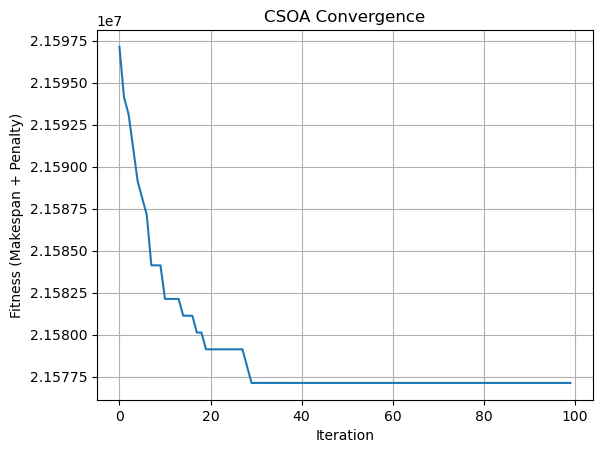


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]

2. Phân bổ cần cẩu (q):
[[0 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]]

3. Phân bổ xe (y):
[[0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
  0 0 0 0]
 [1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 1 0 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 1]
 [0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 

In [ ]:
h = np.random.normal(loc=750, scale=150)
TS = [TC[i] + h for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
TA = np.array(TS)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TS))    # Giờ
Dl_ = np.random.normal(loc=Dl, scale=Dl*0.2)
Dk_ = np.random.normal(loc=Dk, scale=Dk*0.2)
n_1 = np.random.normal(loc=n_, scale=n_*0.1)
tn_1 = np.random.normal(loc=tn_, scale=tn_*0.15)
lambda1_1 = np.random.normal(loc=lambda1, scale=lambda1*0.1)
lambda2_1 = np.random.normal(loc=lambda2, scale=lambda2*0.1)
# ==================== HÀM NGOÀI CLASS ====================
def enforce_crane_constraints(q):
    for i in range(V):
        num_assigned = np.sum(q[i])
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            to_add = VCmi[i] - num_assigned
            selected = np.random.choice(available, to_add, replace=False)
            q[i, selected] = 1
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            to_remove = num_assigned - VCMi[i]
            selected = np.random.choice(assigned, to_remove, replace=False)
            q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V, C = q2D.shape
    q3D = np.zeros((V, C, T), dtype=int)

    for i in range(V):  # mỗi tàu
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        
        if num_cranes == 0:
            continue

        total_time = int(np.ceil(VE[i] * CF0))  # tính tổng thời gian cần cẩu phục vụ tàu
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0  # có thể đặt tùy theo lịch cập nhật nếu cần

        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time  # tiếp nối cần cẩu kế tiếp

    return q3D


def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False

    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                return False

    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V, B = x.shape
    for i in range(V):
        for j in range(B):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True
def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False


def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):  # thử tối đa 3 ngày sau
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)  # fallback


def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
# --- Hàm sinh chuỗi hỗn loạn Cat map 2 chiều ---
def cat_map_2d(x0, y0, n):
    xs, ys = [x0], [y0]
    for _ in range(n-1):
        x_new = (xs[-1] + ys[-1]) % 1
        y_new = (xs[-1] + 2*ys[-1]) % 1
        xs.append(x_new)
        ys.append(y_new)
    return np.array(xs), np.array(ys)

class ChaosSeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        # Các biến toàn cục (V, B, C, Y, VCmi, VCMi, ...) và các hàm ràng buộc cần được import/copy từ SOA.ipynb

    def calculate_F1(self, TF, TA):
        v = len(TF)
        total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
        F1 = (1 / v) * total
        return F1
    
    def calculate_F2(self, E1, Dl, Dk, n_, tn_):
        pl = calculate_pvl(vh, l1)
        pk = calculate_pvl(vl, l2)
        F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
        return F2
    
    def calculate_F3(self, TD, TS, TV, E2, delVCit, lambda1, lambda2):
        part1 = 0
        part2 = 0
        part3 = 0
        for i in range(len(TD)):
            part1 += (TD[i] - TS[i]) * VCi[i]
            part2 += (TD[i] - TV[i]) * delVCit[i]
            part3 += delVCit[i]
        F3 = (E2 * (lambda1 * (part1 + part2) + lambda2 * part3)) / 3600
        return F3
    
    def calculate_k123(self, a, b, c):
        return float(1)/a, float(1)/b, float(1)/c
    
    def calculate_F(self, sol):
        F1 = self.calculate_F1(TF_float, TS)
        F2 = self.calculate_F2(E1, Dl, Dk, n_, tn_)
        F3 = self.calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
        F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
        return F, F1, F2, F3
        
    def initialize(self):
        self.population = []
        # Sử dụng Cat map để sinh chuỗi hỗn loạn
        x0, y0 = np.random.rand(), np.random.rand()
        chaos_len = self.n_seagulls * (V * (B + C + Y))
        xs, ys = cat_map_2d(x0, y0, chaos_len)
        idx = 0
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.zeros((V, Y), dtype=int)
            }
            # Phân bổ tàu-bến (x) bằng Cat map
            for i in range(V):
                berth_idx = int(xs[idx] * B) % B
                sol['x'][i, berth_idx] = 1
                idx += 1
            # Phân bổ cần cẩu (q) bằng Cat map
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                chaos_crane = np.argsort(xs[idx:idx+C])[:num_cranes]
                sol['q'][i, chaos_crane] = 1
                idx += C
            # Phân bổ xe (y) bằng Cat map
            for i in range(V):
                num_trucks = np.random.randint(5, 11)
                chaos_truck = np.argsort(ys[idx:idx+Y])[:num_trucks]
                sol['y'][i, chaos_truck] = 1
                idx += Y
            self.population.append(sol)

    def fitness(self, sol):
        makespan = 0
        penalty = 0
        completion_times = []
        berth_schedule = {j: 0.0 for j in range(B)}
        tide_intervals = parse_tide_intervals(Tt)
    
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += 1000 * abs(sum(sol['x'][i]) - 1)
        
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += 1000 * (sum(sol['q'][:, n]) - 1)
        
        # Lưu lại thời gian phục vụ từng tàu ở từng bến
        start_times = np.zeros((V, B))
        completion_times_matrix = np.zeros((V, B))
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            ships = sorted(ships, key=lambda i: TA[i])
            for idx, i in enumerate(ships):
                assigned_cranes = np.sum(sol['q'][i])
                assigned_trucks = np.sum(sol['y'][i])
                if assigned_cranes == 0 or assigned_trucks == 0:
                    penalty += 10000
                    continue
                if VDi[i] > BDj[j]:
                    penalty += 10000
                if VLi[i] > BLj[j]:
                    penalty += 10000
                # Tính thời gian phục vụ tàu i
                arrival_dt = float_to_datetime(TA[i])
                arrival_date = arrival_dt.date()
                arrival_hour = arrival_dt.hour + arrival_dt.minute/60

                # Lấy độ sâu tại bến theo giờ
                berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))
                if berth_depth is None:
                    # Nếu không có dữ liệu, sử dụng giá trị mặc định
                    berth_depth = BDj[berth]

                # Kiểm tra mớn nước tàu so với độ sâu bến
                if VDi[i] > berth_depth:
                    penalty += 10000

                # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều
                if VDi[i] > DMN:
                    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
                    if channel_depth is None:
                        channel_depth = DMN  # Giá trị mặc định nếu không có dữ liệu

                    if VDi[i] > channel_depth:
                        # Tìm thời điểm thủy triều cao tiếp theo
                        next_high_tide = next_high_tide_time(arrival_dt, tide_intervals)
                        TA_adjusted = convert_time_to_float(next_high_tide)
                    else:
                        TA_adjusted = TA[i]
                else:
                    TA_adjusted = TA[i]
                start_time = max(float(TA_adjusted), float(berth_schedule[j]))
                processing_time = float((VEi[i] * CF0) / assigned_cranes)
                transport_delay = D[i, j] / (assigned_trucks + 1e-5)
                completion = float(start_time + processing_time + transport_delay)
                start_times[i, j] = start_time
                completion_times_matrix[i, j] = completion
                berth_schedule[j] = completion
        
        # Kiểm tra các nhóm tàu cùng lúc ở bến j
        for j in range(B):
            ships = [i for i in range(V) if sol['x'][i][j] == 1]
            for idx, i in enumerate(ships):
                for kdx in range(idx+1, len(ships)):
                    k = ships[kdx]
                    # Nếu thời gian phục vụ chồng lấn
                    if not (completion_times_matrix[i, j] <= start_times[k, j] or completion_times_matrix[k, j] <= start_times[i, j]):
                        # Lấy các tàu đang cùng lúc ở bến
                        overlap_ships = [m for m in ships if not (completion_times_matrix[m, j] <= start_times[i, j] or start_times[m, j] >= completion_times_matrix[i, j])]
                        total_length = 0
                        total_LSe = 0
                        total_LSd = 0
                        for s_idx, m in enumerate(overlap_ships):
                            ship_type = get_ship_type(VLi[m])
                            total_length += VLi[m]
                            total_LSe += LSe[ship_type]
                            if s_idx > 0:
                                prev_ship_type = get_ship_type(VLi[overlap_ships[s_idx-1]])
                                total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
                        if len(overlap_ships) == 1:
                            ship_type = get_ship_type(VLi[overlap_ships[0]])
                            total_LSd += LSd[ship_type] / 2
                        if total_length + total_LSe + total_LSd > BLj[j]:
                            penalty += 10000
    
        q3D = schedule_cranes(sol['q'], VEi, CF0, T)
        if not crane_non_crossing_constraint(q3D):
            penalty += 10000
    
        if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
            penalty += 10000
    
        CK, A = build_CK_A_from_sol(sol, V, C, T, B)
        mu_vh, sigma_vh = 25, 4
        mu_vl, sigma_vl = 18, 3
        if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
            penalty += 10000
        carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
        w_carbon = 0.01
        F, F1, F2, F3 = self.calculate_F(sol)
        makespan = max(completion_times) if completion_times else M
        return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty + F


    
    def attack_prey(self, best_sol, current_sol):
        new_sol = deepcopy(current_sol)
        for key in ['x', 'q', 'y']:
            mask = np.random.rand(*current_sol[key].shape) < 0.5
            new_sol[key][mask] = best_sol[key][mask]
        new_sol['q'] = enforce_crane_constraints(new_sol['q'])
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        return new_sol
    
    def migrate(self, sol):
        new_sol = deepcopy(sol)
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < 0.1
            new_sol[key] = np.logical_xor(sol[key], mutation).astype(int)
        new_sol['x'] = enforce_vessel_berth_constraint(new_sol['x'])  # <-- Thêm dòng này
        
        # Đột biến có kiểm soát cho cần cẩu
        for i in range(V):
            if np.random.rand() < 0.1:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new_sol['q'][i] = 0
                selected = np.random.choice(C, num_cranes, replace=False)
                new_sol['q'][i, selected] = 1
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                new_sol = self.attack_prey(best_sol, self.population[i])
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            fitCSOA.append(fitness_history[-1])
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        
        plt.plot(fitness_history)
        plt.title("CSOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol

# --- Gợi ý sử dụng ---
csoa = ChaosSeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = csoa.optimize()

print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])

print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])

print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

# Tính toán thời gian chi tiết
berth_schedule = {j: 0 for j in range(B)}
print("\nChi tiết thời gian:")
sum_ = 0
for i in np.argsort(TA):
    berth = np.argmax(best_solution['x'][i])
    start = max(TA[i], berth_schedule[berth])
    wait = start - TA[i]
    def schedule_cranes(num_containers, num_cranes, cf0=CF0):
        if num_cranes == 0:
            return float('inf')  # Không có cần cẩu thì không thể bốc dỡ
        return num_containers * cf0 / num_cranes

    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = schedule_cranes(VEi[i], num_cranes)
    sum_ += handling_time + wait
    end = start + handling_time
    print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
    berth_schedule[berth] = start + PT[i]

F, F1, F2, F3 = csoa.calculate_F(best_solution)
print("\nCác giá trị mục tiêu:")
print(f"F1 (Thời gian trung bình): {F1 / 3600} giờ")
print(f"F2 (Phát thải carbon từ xe tải): {F2 / 3600} kg CO2")
print(f"F3 (Phát thải carbon từ cần cẩu): {F3} kg CO2")
print(f"F (Hàm mục tiêu tổng hợp): {F / 3600}")
makespan = sum_ / 3600  # Đơn vị: giờ
print(f"Makespan thực tế: {makespan} giờ")

berth_schedule = {j: 0 for j in range(B)}
output_rows = []
for idx, i in enumerate(np.argsort(TA)):
    berth = int(np.argmax(best_solution['x'][i]))
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else None
    end = start + handling_time if handling_time is not None else None
    berth_schedule[berth] = start + PT[i]

    # Lấy độ sâu channel và berth tại thời điểm tàu vào
    arrival_dt = float_to_datetime(TA[i])
    arrival_date = arrival_dt.date()
    arrival_hour = arrival_dt.hour + arrival_dt.minute/60
    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
    berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))

    berth_name = ChannelBerth['Tên bến'][berth] if 'Tên bến' in ChannelBerth.columns else f"Bến {berth+1}"
    cranes = np.where(best_solution['q'][i] == 1)[0]
    trucks = np.where(best_solution['y'][i] == 1)[0]

    output_rows.append({
        "Index": idx + 1,
        "Vessel Name": V_name[i],
        "TOi": float_to_datetime(TO_float[i]),
        "TFi": float_to_datetime(TF_float[i]),
        "TWi": TWi[i],
        "TC": float_to_datetime(TC[i]),
        "TS": float_to_datetime(TS[i]),
        "VLi": VLi[i],
        "VDi": VDi[i],
        "VEi": VEi[i],
        "VCmi": VCmi[i],
        "VCMi": VCMi[i],
        "Di1": lst1[i],
        "Di2": lst2[i],
        "LSd": LSd[get_ship_type(VLi[i])],
        "LSe": LSe[get_ship_type(VLi[i])],
        "channel_tide": channel_depth,
        "berth_tide": berth_depth,
        "Phân bổ bến": berth_name,
        "Phân bổ cần cẩu": ",".join(str(c+1) for c in cranes),
        "Phân bổ xe": ",".join(str(t+1) for t in trucks),
        "Thời gian chờ": wait / 3600 if wait is not None else None,
        "Thời gian bắt đầu": float_to_datetime(start) if start is not None else None,
        "Thời điểm kết thúc dự kiến": float_to_datetime(end) if end is not None else None,
    })

# Tạo DataFrame và xuất ra Excel
df_output = pd.DataFrame(output_rows)
columns_order = [
    "Index", "Vessel Name", "TOi", "TFi", "TWi", "TC", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
    "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
    "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
]
df_output = df_output[columns_order]
output_path = r"E:\KLTN_DUU\Source\Data\CSOA_Output.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    df_output.to_excel(writer, sheet_name='CSOA_Output', index=False)
print(f"\nĐã xuất file Excel ra: {output_path}")

Iter 1, Best Fitness: 23179358.939014215
Iter 2, Best Fitness: 23179358.939014215
Iter 3, Best Fitness: 23179358.939014215
Iter 4, Best Fitness: 23179358.939014215
Iter 5, Best Fitness: 23179358.939014215
Iter 6, Best Fitness: 23179358.939014215
Iter 7, Best Fitness: 23178359.036790214
Iter 8, Best Fitness: 23178359.036790214
Iter 9, Best Fitness: 23178359.036790214
Iter 10, Best Fitness: 23178359.036790214
Iter 11, Best Fitness: 23178359.036790214
Iter 12, Best Fitness: 23178359.036790214
Iter 13, Best Fitness: 23178359.036790214
Iter 14, Best Fitness: 23178359.036790214
Iter 15, Best Fitness: 23178359.036790214
Iter 16, Best Fitness: 23178359.036790214
Iter 17, Best Fitness: 23178359.036790214
Iter 18, Best Fitness: 23178359.036790214
Iter 19, Best Fitness: 23178359.036790214
Iter 20, Best Fitness: 23178359.036790214
Iter 21, Best Fitness: 23178359.036790214
Iter 22, Best Fitness: 23178359.036790214
Iter 23, Best Fitness: 23178359.036790214
Iter 24, Best Fitness: 23178359.036790214
I

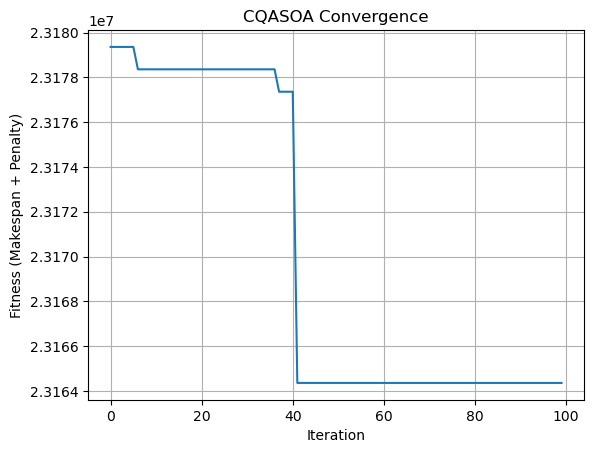


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]

2. Phân bổ cần cẩu (q):
[[0 0 0 1 0 1]
 [1 0 1 1 0 1]
 [0 0 0 1 1 0]
 [0 1 1 0 1 0]
 [1 1 0 0 0 1]
 [1 0 0 1 1 0]
 [0 1 1 0 1 0]
 [1 0 0 1 1 0]
 [1 0 1 1 0 1]
 [1 1 0 0 1 0]
 [0 0 0 1 1 0]
 [0 1 1 0 0 1]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 0 1 1]
 [1 1 1 0 0 1]
 [0 1 1 1 0 0]
 [0 0 1 1 0 1]
 [1 0 0 0 1 0]]

3. Phân bổ xe (y):
[[0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0
  0 1 0 0]
 [0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0
  0 1 1 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0
  0 0 1 0]
 [0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 1 1 0]
 [0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 

In [ ]:
h = np.random.normal(loc=750, scale=150)
TS = [TC[i] + h for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
TA = np.array(TS)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TS))    # Giờ
Dl_ = np.random.normal(loc=Dl, scale=Dl*0.2)
Dk_ = np.random.normal(loc=Dk, scale=Dk*0.2)
n_1 = np.random.normal(loc=n_, scale=n_*0.1)
tn_1 = np.random.normal(loc=tn_, scale=tn_*0.15)
lambda1_1 = np.random.normal(loc=lambda1, scale=lambda1*0.1)
lambda2_1 = np.random.normal(loc=lambda2, scale=lambda2*0.1)
# --- Các hàm ràng buộc và tiện ích dùng chung ---
def enforce_crane_constraints(q):
    # Đảm bảo mỗi tàu có số cần cẩu nằm trong [VCmi[i], VCMi[i]]
    for i in range(V):
        num_assigned = np.sum(q[i])
        # Thêm cần cẩu ít được sử dụng nhất
        if num_assigned < VCmi[i]:
            available = np.where(q[i] == 0)[0]
            # Ưu tiên cần cẩu ít được gán cho các tàu khác
            usage = np.sum(q, axis=0)
            sorted_idx = available[np.argsort(usage[available])]
            to_add = min(VCmi[i] - num_assigned, len(sorted_idx))
            if to_add > 0:
                selected = sorted_idx[:to_add]
                q[i, selected] = 1
        # Loại cần cẩu được sử dụng nhiều nhất
        elif num_assigned > VCMi[i]:
            assigned = np.where(q[i] == 1)[0]
            usage = np.sum(q, axis=0)
            sorted_idx = assigned[np.argsort(-usage[assigned])]
            to_remove = min(num_assigned - VCMi[i], len(sorted_idx))
            if to_remove > 0:
                selected = sorted_idx[:to_remove]
                q[i, selected] = 0
    return q

def schedule_cranes(q2D, VE, CF0, T):
    V_, C_ = q2D.shape
    q3D = np.zeros((V_, C_, T), dtype=int)
    for i in range(V_):
        assigned_cranes = np.where(q2D[i] == 1)[0]
        num_cranes = len(assigned_cranes)
        if num_cranes == 0:
            continue
        total_time = int(np.ceil(VE[i] * CF0))
        duration = total_time // num_cranes
        extra = total_time % num_cranes
        start_time = 0
        for j, c in enumerate(assigned_cranes):
            dur = duration + (1 if j < extra else 0)
            end_time = min(start_time + dur, T)
            q3D[i][c][start_time:end_time] = 1
            start_time = end_time
    return q3D

def crane_non_crossing_constraint(q):
    for i in range(V):
        for n in range(1, C - 1):
            for t in range(T):
                left = q[i][n - 1][t]
                center = q[i][n][t]
                right = q[i][n + 1][t]
                if left == 1 and right == 1 and center == 0:
                    return False
    return True

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    C_, T_ = CK.shape
    V_, B_ = D.shape
    for t in range(T_):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            return False
    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)
    TH = D / v_h
    TL = D / v_l
    for n in range(C_):
        for t in range(T_):
            i, j = A[n, t]
            ck = CK[n, t]
            if ck == 0:
                continue
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator
            if CE_n > CE0:
                return False
    return True

def check_vessel_berth_length_constraint(x, VLi, BLj):
    V_, B_ = x.shape
    for i in range(V_):
        for j in range(B_):
            if x[i][j] == 1 and VLi[i] > BLj[j]:
                return False
    return True

def parse_tide_intervals(Tt):
    intervals = []
    for interval in Tt:
        start_str, end_str = interval.split(" - ")
        h1, m1, s1 = map(int, start_str.split(":"))
        h2, m2, s2 = map(int, end_str.split(":"))
        start = timedelta(hours=h1, minutes=m1, seconds=s1)
        end = timedelta(hours=h2, minutes=m2, seconds=s2)
        intervals.append((start, end))
    return intervals

def is_high_tide(dt, tide_intervals):
    current_time = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    for start, end in tide_intervals:
        if start <= current_time <= end:
            return True
    return False

def next_high_tide_time(dt, tide_intervals):
    for day_offset in range(0, 3):
        new_date = dt.date() + timedelta(days=day_offset)
        for start, _ in tide_intervals:
            candidate = datetime.combine(new_date, (datetime.min + start).time())
            if candidate > dt:
                return candidate
    return dt + timedelta(hours=6)


def build_CK_A_from_sol(sol, V, C, T, B):
    CK = np.zeros((C, T), dtype=int)
    A = np.zeros((C, T, 2), dtype=int)
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        for n in assigned_cranes:
            for t in range(T//2):
                CK[n, t] += max(1, len(assigned_trucks)//max(1, len(assigned_cranes)))
                A[n, t] = [i, berth]
    return CK, A

def calc_carbon_emission(sol, V, C, T, D, E1, E2):
    carbon_truck = 0
    carbon_crane = 0
    for i in range(V):
        assigned_cranes = np.where(sol['q'][i] == 1)[0]
        assigned_trucks = np.where(sol['y'][i] == 1)[0]
        berth = np.argmax(sol['x'][i])
        carbon_truck += len(assigned_trucks) * D[i, berth] * 2 * E1
        carbon_crane += len(assigned_cranes) * (T//2) * E2
    return carbon_truck, carbon_crane

def get_ship_type(length):
    if length <= 150:
        return 0
    elif length <= 200:
        return 1
    elif length <= 300:
        return 2
    else:
        return 3
# ==================== HÀM HIỂN THỊ KẾT QUẢ CHI TIẾT ====================
def show_solution_detail(best_solution):
    print("\nBest Solution:")
    print("1. Phân bổ tàu-bến (x):")
    print(best_solution['x'])
    print("\n2. Phân bổ cần cẩu (q):")
    print(best_solution['q'])
    print("\n3. Phân bổ xe (y):")
    print(best_solution['y'])
    berth_schedule = {j: 0 for j in range(B)}
    print("\nChi tiết thời gian:")
    sum_ = 0
    for i in np.argsort(TA):
        berth = np.argmax(best_solution['x'][i])
        start = max(TA[i], berth_schedule[berth])
        wait = start - TA[i]
        def schedule_cranes(num_containers, num_cranes, cf0=CF0):
            if num_cranes == 0:
                return float('inf')
            return num_containers * cf0 / num_cranes
        num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
        handling_time = schedule_cranes(VEi[i], num_cranes)
        sum_ += handling_time + wait
        end = start + handling_time
        print(f"Tàu {i}: Bến {berth}, Đến {float_to_datetime(TA[i])}h, Bắt đầu {float_to_datetime(start)}h, Chờ {wait / 3600}h, Thời điểm kết thúc dự kiến: {float_to_datetime(end)}h")
        berth_schedule[berth] = start + PT[i]
    
    F, F1, F2, F3 = soa.calculate_F(best_solution)
    print("\nCác giá trị mục tiêu:")
    print(f"F1 (Thời gian trung bình): {F1 / 3600} giờ")
    print(f"F2 (Phát thải carbon từ xe tải): {F2 / 3600} kg CO2")
    print(f"F3 (Phát thải carbon từ cần cẩu): {F3} kg CO2")
    print(f"F (Hàm mục tiêu tổng hợp): {F / 3600}")
    makespan = sum_ / 3600  # Đơn vị: giờ
    print(f"Makespan thực tế: {makespan} giờ")

def calculate_F(sol):
    F1 = calculate_F1(TF_float, TS)
    F2 = calculate_F2(E1, Dl, Dk, n_, tn_)
    F3 = calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
    F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
    return F, F1, F2, F3

def calculate_F1(TF, TA):
    v = len(TF)
    total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
    F1 = (1 / v) * total
    return F1
def calculate_F2(E1, Dl, Dk, n_, tn_):
    pl = calculate_pvl(vh, l1)
    pk = calculate_pvl(vl, l2)
    F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
    return F2
def calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2):
    part1 = 0
    part2 = 0
    part3 = 0
    for i in range(len(TD)):
        part1 += (TD[i] - TS[i]) * VCi[i]
        part2 += (TD[i] - TV[i]) * delVCit[i]
        part3 += delVCit[i]
    F3 = (E2 * (lambda1 * (part1 + part2) + lambda2 * part3)) / 3600
    return F3
def calculate_k123(a, b, c):
    return float(1)/a, float(1)/b, float(1)/c
    
def fitness(sol):
    berth_schedule = {j: 0 for j in range(B)}
    completion_times = []
    penalty = 0
    tide_intervals = parse_tide_intervals(Tt)
    w_carbon = 0.01
    # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
    for i in range(V):
        if np.sum(sol['x'][i]) != 1:
            penalty += 1000 * abs(np.sum(sol['x'][i]) - 1)
    # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm
    for n in range(C):
        if np.sum(sol['q'][:, n]) > 1:
            penalty += 1000 * (np.sum(sol['q'][:, n]) - 1)
    # Ràng buộc 3: Số cần cẩu cho mỗi tàu nằm trong [VCmi, VCMi]
    for i in range(V):
        total_cranes = np.sum(sol['q'][i])
        if total_cranes < VCmi[i] or total_cranes > VCMi[i]:
            penalty += 1000 * abs(total_cranes - VCmi[i])
    # Ràng buộc 4: Số xe tải cho mỗi tàu (giả sử min 1, max 10)
    for i in range(V):
        total_trucks = np.sum(sol['y'][i])
        if total_trucks < 1:
            penalty += 10000
        if total_trucks > 10:
            penalty += 1000 * (total_trucks - 10)
    if np.sum(sol['y']) > Y:
        penalty += 10000 * (np.sum(sol['y']) - Y)
    # Ràng buộc 5: Chiều dài tàu không vượt chiều dài bến
    for i in range(V):
        berth = np.argmax(sol['x'][i])
        if VLi[i] > BLj[berth]:
            penalty += 10000
    # Ràng buộc 6: Sức chứa bến
    for i in range(V):
        berth = np.argmax(sol['x'][i])
        if VDi[i] > BDj[berth]:
            penalty += 10000
    # Ràng buộc an toàn, chiều dài, mớn nước cho nhiều tàu cùng bến
    start_times = np.zeros((V, B))
    completion_times_matrix = np.zeros((V, B))
    for j in range(B):
        ships = [i for i in range(V) if sol['x'][i][j] == 1]
        ships = sorted(ships, key=lambda i: TA[i])
        for idx, i in enumerate(ships):
            assigned_cranes = np.sum(sol['q'][i])
            assigned_trucks = np.sum(sol['y'][i])
            if assigned_cranes == 0 or assigned_trucks == 0:
                penalty += 10000
                continue
            if VDi[i] > BDj[j]:
                penalty += 10000
            if VLi[i] > BLj[j]:
                penalty += 10000
            # Tính thời gian phục vụ tàu i
            arrival_dt = float_to_datetime(TA[i])
            arrival_date = arrival_dt.date()
            arrival_hour = arrival_dt.hour + arrival_dt.minute/60
            # Lấy độ sâu tại bến theo giờ
            berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))
            if berth_depth is None:
                # Nếu không có dữ liệu, sử dụng giá trị mặc định
                berth_depth = BDj[berth]
            # Kiểm tra mớn nước tàu so với độ sâu bến
            if VDi[i] > berth_depth:
                penalty += 10000
            # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều
            if VDi[i] > DMN:
                channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
                if channel_depth is None:
                    channel_depth = DMN  # Giá trị mặc định nếu không có dữ liệu
                if VDi[i] > channel_depth:
                    # Tìm thời điểm thủy triều cao tiếp theo
                    next_high_tide = next_high_tide_time(arrival_dt, tide_intervals)
                    TA_adjusted = convert_time_to_float(next_high_tide)
                else:
                    TA_adjusted = TA[i]
            else:
                TA_adjusted = TA[i]
            start_time = max(float(TA_adjusted), float(berth_schedule[j]))
            processing_time = float((VEi[i] * CF0) / assigned_cranes)
            transport_delay = D[i, j] / (assigned_trucks + 1e-5)
            completion = float(start_time + processing_time + transport_delay)
            start_times[i, j] = start_time
            completion_times_matrix[i, j] = completion
            berth_schedule[j] = completion
    
    # Kiểm tra các nhóm tàu cùng lúc ở bến j
    for j in range(B):
        ships = [i for i in range(V) if sol['x'][i][j] == 1]
        for idx, i in enumerate(ships):
            for kdx in range(idx+1, len(ships)):
                k = ships[kdx]
                # Nếu thời gian phục vụ chồng lấn
                if not (completion_times_matrix[i, j] <= start_times[k, j] or completion_times_matrix[k, j] <= start_times[i, j]):
                    # Lấy các tàu đang cùng lúc ở bến
                    overlap_ships = [m for m in ships if not (completion_times_matrix[m, j] <= start_times[i, j] or start_times[m, j] >= completion_times_matrix[i, j])]
                    total_length = 0
                    total_LSe = 0
                    total_LSd = 0
                    for s_idx, m in enumerate(overlap_ships):
                        ship_type = get_ship_type(VLi[m])
                        total_length += VLi[m]
                        total_LSe += LSe[ship_type]
                        if s_idx > 0:
                            prev_ship_type = get_ship_type(VLi[overlap_ships[s_idx-1]])
                            total_LSd += max(LSd[ship_type], LSd[prev_ship_type])
                    if len(overlap_ships) == 1:
                        ship_type = get_ship_type(VLi[overlap_ships[0]])
                        total_LSd += LSd[ship_type] / 2
                    if total_length + total_LSe + total_LSd > BLj[j]:
                        penalty += 10000
    # Ràng buộc 8: Cần cẩu không nhảy qua nhau
    q3D = schedule_cranes(sol['q'], VEi, CF0, T)
    if not crane_non_crossing_constraint(q3D):
        penalty += 10000
    # Ràng buộc 9: Chiều dài tàu không vượt chiều dài bến (kiểm tra lại)
    if not check_vessel_berth_length_constraint(sol['x'], VLi, BLj):
        penalty += 10000
    # Ràng buộc 10: Truck constraint
    CK, A = build_CK_A_from_sol(sol, V, C, T, B)
    mu_vh, sigma_vh = 25, 4
    mu_vl, sigma_vl = 18, 3
    if not check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, E2):
        penalty += 10000
    # Carbon emission
    carbon_truck, carbon_crane = calc_carbon_emission(sol, V, C, T, D, E1, E2)
    F, F1, F2, F3 = calculate_F(sol)
    makespan = max(completion_times) if completion_times else M
    return makespan + w_carbon * (carbon_truck + carbon_crane) + penalty + F


# ==================== CLASS CQASOA (sẽ hoàn thiện ở các bước tiếp theo) ====================
class CQASOA:
    def __init__(self, n_seagulls=30, max_iter=100, mode='CQASOA', **kwargs):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.mode = mode
        self.kwargs = kwargs
        self.pm = kwargs.get('pm', 0.1)  # Xác suất NOT gate
        self.chaos_seed = kwargs.get('chaos_seed', None)

    def initialize(self):
        # Khởi tạo phi lượng tử và chuỗi hỗn loạn cho từng cá thể
        self.population_phi = []
        self.chaos_xs = []
        self.chaos_ys = []
        chaos_len = self.n_seagulls * (V * (B + C + Y))
        if self.chaos_seed is not None:
            np.random.seed(self.chaos_seed)
        x0, y0 = np.random.rand(), np.random.rand()
        xs, ys = self.cat_map_2d(x0, y0, chaos_len)
        idx = 0
        for _ in range(self.n_seagulls):
            phi = {
                'x': np.random.uniform(0, 2*np.pi, (V, B)),
                'q': np.random.uniform(0, 2*np.pi, (V, C)),
                'y': np.random.uniform(0, 2*np.pi, (V, Y))
            }
            self.population_phi.append(phi)
            # Lưu chuỗi hỗn loạn riêng cho từng cá thể
            self.chaos_xs.append(xs[idx:idx+B+C+Y])
            self.chaos_ys.append(ys[idx:idx+B+C+Y])
            idx += (B+C+Y)

    def cat_map_2d(self, x0, y0, n):
        xs, ys = [x0], [y0]
        for _ in range(n-1):
            x_new = (xs[-1] + ys[-1]) % 1
            y_new = (xs[-1] + 2*ys[-1]) % 1
            xs.append(x_new)
            ys.append(y_new)
        return np.array(xs), np.array(ys)

    def phi_to_solution(self, phi):
        x_bin = (np.cos(phi['x']) > 0).astype(int)
        for i in range(x_bin.shape[0]):
            if np.sum(x_bin[i]) != 1:
                idx = np.argmax(phi['x'][i])
                x_bin[i] = 0
                x_bin[i, idx] = 1
        q_bin = (np.cos(phi['q']) > 0).astype(int)
        q_bin = enforce_crane_constraints(q_bin)
        y_bin = (np.cos(phi['y']) > 0).astype(int)
        # Đảm bảo số xe hợp lệ (giống QSOA)
        y_bin = self.enforce_truck_constraints_optimized(y_bin, M)
        return {'x': x_bin, 'q': q_bin, 'y': y_bin}

    def enforce_truck_constraints_optimized(self, y, num_trucks, min_truck_per_vessel=1, max_truck_per_vessel=10):
        V_, M_ = y.shape
        # Đảm bảo mỗi tàu có số xe hợp lệ
        for i in range(V_):
            current = np.sum(y[i])
            if current < min_truck_per_vessel:
                available = np.where(np.sum(y, axis=0) == 0)[0]
                usage = np.sum(y, axis=0)
                sorted_idx = available[np.argsort(usage[available])]
                to_add = min(min_truck_per_vessel - current, len(sorted_idx))
                if to_add > 0:
                    selected = sorted_idx[:to_add]
                    y[i, selected] = 1
            if np.sum(y[i]) > max_truck_per_vessel:
                assigned = np.where(y[i] == 1)[0]
                usage = np.sum(y, axis=0)
                sorted_idx = assigned[np.argsort(-usage[assigned])]
                to_remove = min(np.sum(y[i]) - max_truck_per_vessel, len(sorted_idx))
                if to_remove > 0:
                    selected = sorted_idx[:to_remove]
                    y[i, selected] = 0
        # Đảm bảo tổng số xe không vượt quá num_trucks
        sort_idx = np.arange(V_)
        max_iter = 1000
        iter_cnt = 0
        while np.sum(y) > num_trucks and iter_cnt < max_iter:
            changed = False
            for i in reversed(sort_idx):
                assigned = np.where(y[i] == 1)[0]
                if len(assigned) > min_truck_per_vessel:
                    usage = np.sum(y, axis=0)
                    sorted_idx = assigned[np.argsort(-usage[assigned])]
                    y[i, sorted_idx[0]] = 0
                    changed = True
                    break
            if not changed:
                break
            iter_cnt += 1
        iter_cnt = 0
        while np.sum(y) < num_trucks and iter_cnt < max_iter:
            changed = False
            for i in sort_idx:
                assigned = np.where(y[i] == 0)[0]
                if np.sum(y[i]) < max_truck_per_vessel and len(assigned) > 0:
                    usage = np.sum(y, axis=0)
                    sorted_idx = assigned[np.argsort(usage[assigned])]
                    y[i, sorted_idx[0]] = 1
                    changed = True
                    break
            if not changed:
                break
            iter_cnt += 1
        return y

    def chaos_update(self, phi, chaos_x, chaos_y):
        # Xáo trộn các pha lượng tử bằng chuỗi hỗn loạn (cat map)
        phi_new = deepcopy(phi)
        # Xáo trộn từng dòng của x, q, y bằng chaos_x, chaos_y
        for key, chaos in zip(['x', 'q', 'y'], [chaos_x[:B], chaos_x[B:B+C], chaos_x[B+C:]]):
            arr = phi_new[key]
            for i in range(arr.shape[0]):
                idx = np.argsort(chaos)[:arr.shape[1]]
                arr[i] = arr[i][idx]
        return phi_new

    def quantum_update(self, phi):
        # Quantum Revolving Gate + NOT gate
        delta_phi_x = np.random.uniform(-np.pi/16, np.pi/16, phi['x'].shape)
        delta_phi_q = np.random.uniform(-np.pi/16, np.pi/16, phi['q'].shape)
        delta_phi_y = np.random.uniform(-np.pi/16, np.pi/16, phi['y'].shape)
        phi_new = {
            'x': phi['x'] + delta_phi_x,
            'q': phi['q'] + delta_phi_q,
            'y': phi['y'] + delta_phi_y
        }
        if np.random.rand() < self.pm:
            phi_new['x'] = np.pi/2 - phi_new['x']
            phi_new['q'] = np.pi/2 - phi_new['q']
            phi_new['y'] = np.pi/2 - phi_new['y']
        return phi_new

    def adaptive_update(self, t):
        fc = 2
        return fc * (np.cos(np.pi * (t / self.max_iter)) + 1) / 2

    


    def optimize(self):
        self.initialize()
        fitness_history = []
        best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
        best_sol = self.phi_to_solution(best_phi)
        for iter in range(self.max_iter):
            A = self.adaptive_update(iter)
            new_population_phi = []
            new_chaos_xs = []
            new_chaos_ys = []
            # Elitism: giữ lại best
            best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
            best_idx = next(i for i, phi in enumerate(self.population_phi) if phi is best_phi)
            new_population_phi.append(best_phi)
            new_chaos_xs.append(self.chaos_xs[best_idx])
            new_chaos_ys.append(self.chaos_ys[best_idx])
            for i, phi in enumerate(self.population_phi):
                if i == best_idx:
                    continue
                # 1. Chaos update
                phi_chaos = self.chaos_update(phi, self.chaos_xs[i], self.chaos_ys[i])
                # 2. Quantum update
                phi_quantum = self.quantum_update(phi_chaos)
                # 3. Adaptive: điều chỉnh mutation/mask (có thể dùng cho NOT gate hoặc chaos strength)
                # (Ở đây đã điều chỉnh mutation/mask qua adaptive_update, có thể mở rộng thêm)
                new_population_phi.append(phi_quantum)
                new_chaos_xs.append(self.chaos_xs[i])
                new_chaos_ys.append(self.chaos_ys[i])
            self.population_phi = new_population_phi
            self.chaos_xs = new_chaos_xs
            self.chaos_ys = new_chaos_ys
            best_phi = min(self.population_phi, key=lambda phi: fitness(self.phi_to_solution(phi)))
            best_sol = self.phi_to_solution(best_phi)
            fitness_history.append(fitness(best_sol))
            fitCQASOA.append(fitness_history[-1])
            print(f"Iter {iter+1}, Best Fitness: {fitness_history[-1]}")
        plt.plot(fitness_history)
        plt.title("CQASOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid(True)
        plt.show()
        return best_sol


cqasoa = CQASOA(n_seagulls=30, max_iter=100)
best_solution = cqasoa.optimize()
show_solution_detail(best_solution)

berth_schedule = {j: 0 for j in range(B)}
output_rows = []
for idx, i in enumerate(np.argsort(TA)):
    berth = int(np.argmax(best_solution['x'][i]))
    start = max(TS[i], berth_schedule[berth])
    wait = start - TA[i]
    num_cranes = int(np.sum(best_solution['q'][i])) if 'q' in best_solution else 1
    handling_time = VEi[i] * CF0 / num_cranes if num_cranes > 0 else None
    end = start + handling_time if handling_time is not None else None
    berth_schedule[berth] = start + PT[i]

    # Lấy độ sâu channel và berth tại thời điểm tàu vào
    arrival_dt = float_to_datetime(TA[i])
    arrival_date = arrival_dt.date()
    arrival_hour = arrival_dt.hour + arrival_dt.minute/60
    channel_depth = get_tide_depth(channel_tide, arrival_date, int(arrival_hour))
    berth_depth = get_tide_depth(berth_tide, arrival_date, int(arrival_hour))

    berth_name = ChannelBerth['Tên bến'][berth] if 'Tên bến' in ChannelBerth.columns else f"Bến {berth+1}"
    cranes = np.where(best_solution['q'][i] == 1)[0]
    trucks = np.where(best_solution['y'][i] == 1)[0]

    output_rows.append({
        "Index": idx + 1,
        "Vessel Name": V_name[i],
        "TOi": float_to_datetime(TO_float[i]),
        "TFi": float_to_datetime(TF_float[i]),
        "TWi": TWi[i],
        "TC": float_to_datetime(TC[i]),
        "TS": float_to_datetime(TS[i]),
        "VLi": VLi[i],
        "VDi": VDi[i],
        "VEi": VEi[i],
        "VCmi": VCmi[i],
        "VCMi": VCMi[i],
        "Di1": lst1[i],
        "Di2": lst2[i],
        "LSd": LSd[get_ship_type(VLi[i])],
        "LSe": LSe[get_ship_type(VLi[i])],
        "channel_tide": channel_depth,
        "berth_tide": berth_depth,
        "Phân bổ bến": berth_name,
        "Phân bổ cần cẩu": ",".join(str(c+1) for c in cranes),
        "Phân bổ xe": ",".join(str(t+1) for t in trucks),
        "Thời gian chờ": wait / 3600 if wait is not None else None,
        "Thời gian bắt đầu": float_to_datetime(start) if start is not None else None,
        "Thời điểm kết thúc dự kiến": float_to_datetime(end) if end is not None else None,
    })

# Tạo DataFrame và xuất ra Excel
df_output = pd.DataFrame(output_rows)
columns_order = [
    "Index", "Vessel Name", "TOi", "TFi", "TWi", "TC", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
    "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
    "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
]
df_output = df_output[columns_order]
output_path = r"E:\KLTN_DUU\Source\Data\CQASOA_Output.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    df_output.to_excel(writer, sheet_name='CQASOA_Output', index=False)
print(f"\nĐã xuất file Excel ra: {output_path}")

Giá trị F1 (trung bình thời gian tàu ở cảng): 15.0749527130723
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 41243224.920749664
F = 1237469.843575488
Iter 1: Best = 173.02 | Avg = 178.19 | Worst = 182.05
Iter 6: Best = 172.38 | Avg = 177.60 | Worst = 182.93
Iter 11: Best = 172.38 | Avg = 177.36 | Worst = 182.59
Iter 16: Best = 172.38 | Avg = 177.53 | Worst = 182.93
Iter 21: Best = 172.38 | Avg = 177.61 | Worst = 181.65
Iter 26: Best = 172.38 | Avg = 177.63 | Worst = 182.49
Iter 31: Best = 172.38 | Avg = 177.31 | Worst = 182.90
Iter 36: Best = 172.38 | Avg = 177.39 | Worst = 181.74
Iter 41: Best = 172.38 | Avg = 177.50 | Worst = 182.10
Iter 46: Best = 172.38 | Avg = 177.34 | Worst = 182.59
Iter 51: Best = 172.38 | Avg = 177.64 | Worst = 184.49
Iter 56: Best = 172.20 | Avg = 177.40 | Worst = 184.73
Iter 61: Best = 172.20 | Avg = 178.18 | Worst = 182.86
Iter 66: Best = 172.20 | Avg = 178.24 | Worst = 183.04
Iter 7

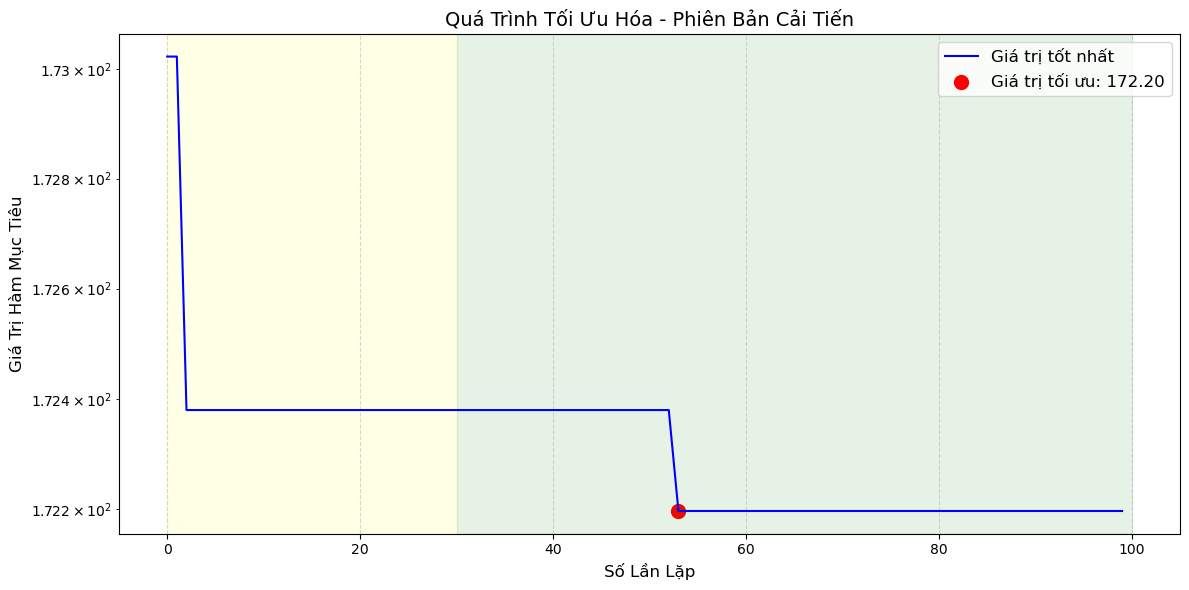

C:\Users\minhv\AppData\Local\Temp\ipykernel_3772\1130939905.py:1021: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


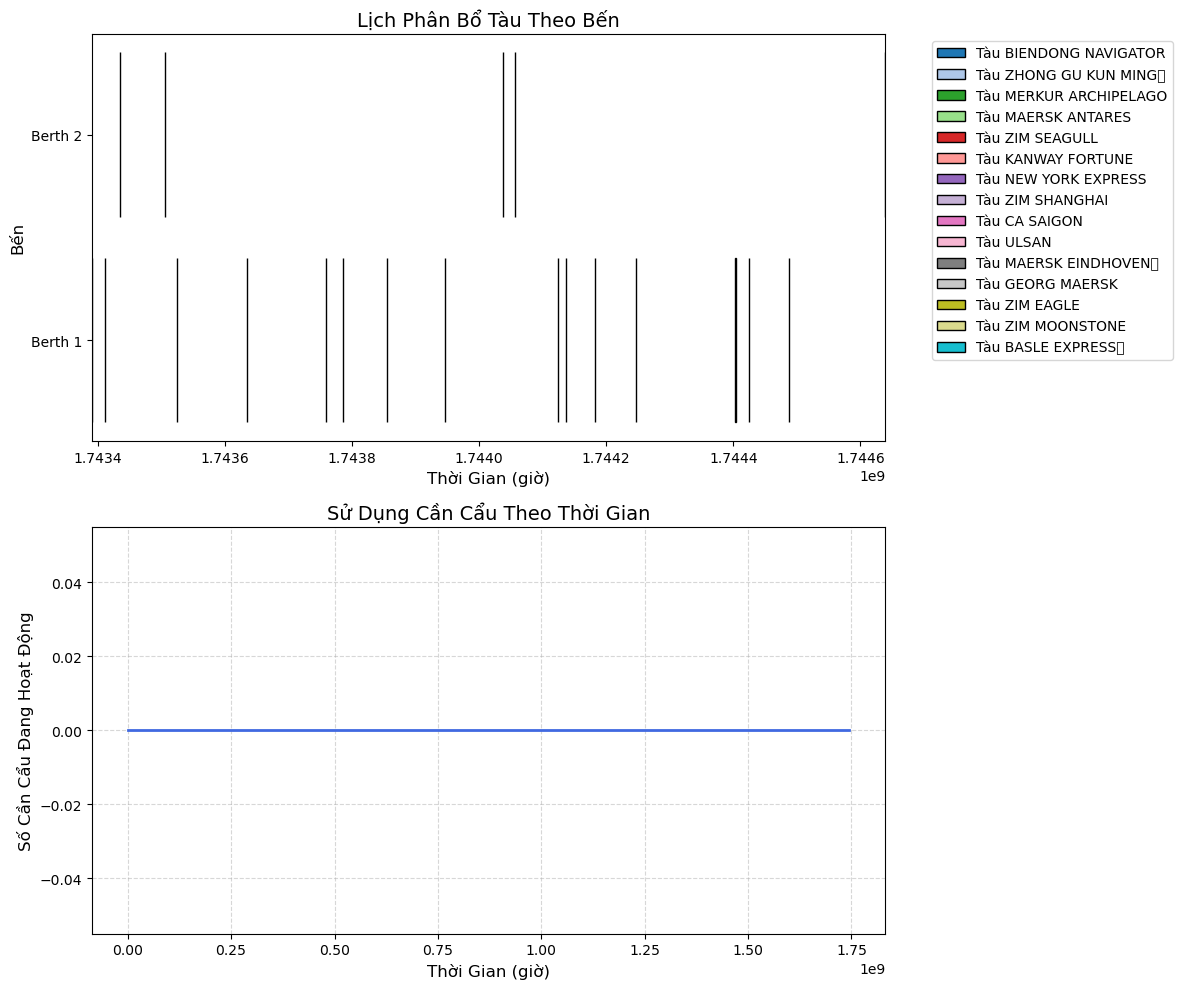


Đã xuất file Excel ra: E:\KLTN_DUU\Source\Data\SSA_Output.xlsx


In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
channel_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel Tide')
berth_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Berth Tide')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải

E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = 6 #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e

Dl_ = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk_ = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
Dl = np.random.normal(loc=Dl_, scale=Dl_*0.2)
Dk = np.random.normal(loc=Dk_, scale=Dk_*0.2)
tn_1 = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
tn_ = np.random.normal(loc=tn_1, scale=tn_1*0.15)
n_1 = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
n_ = np.random.normal(loc=n_1, scale=n_1*0.1)
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
h = np.random.normal(loc=750, scale=150)
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + h for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng

TSi = [TBi[i] + h for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - h for i in TF_float]
alpha = InputVariables.iloc[24, 2]
gamma = InputVariables.iloc[25, 2]
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1 / 3600)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = InputVariables.iloc[26, 2]
lam2 = InputVariables.iloc[27, 2]
lam3 = InputVariables.iloc[28, 2]
F = w1 * lam1 * (F1 / 3600) + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)





import numpy as np
import random
from copy import deepcopy
from datetime import datetime, timedelta
import math
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None

class ImprovedSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params):
        # Kiểm tra và chuẩn hóa dữ liệu đầu vào
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        
        # Tham số điều chỉnh
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        
        self.adaptive_pd = True  # Cho phép điều chỉnh động pd
        self.initial_pd = 0.3
        self.final_pd = 0.1
        
        # Khởi tạo quần thể với cơ chế dự phòng
        self.population = self.initialize_population_with_fallback()
        if len(self.population) == 0:
            raise ValueError("Không thể khởi tạo bất kỳ cá thể hợp lệ nào. Vui lòng kiểm tra lại ràng buộc đầu vào.")
            
        self.best_solution = None
        self.best_fitness = float('inf')
        
        # Theo dõi lịch sử
        self.fitness_history = []
        self.diversity_history = []
    
    def initialize_population_with_fallback(self):
        """Khởi tạo quần thể với cơ chế dự phòng nếu không đạt yêu cầu"""
        try:
            # Thử khởi tạo với số lần thử lớn hơn
            population = self.initialize_population(max_attempts=500)
            if len(population) >= self.num_sparrows * 0.8:  # Chấp nhận 80% số lượng
                return population[:self.num_sparrows]
                
            # Nếu không đủ, thử phương pháp đơn giản hơn
            print("Cảnh báo: Sử dụng phương pháp khởi tạo đơn giản hơn do ràng buộc quá chặt")
            return self.initialize_simple_population()
        except Exception as e:
            print(f"Cảnh báo khi khởi tạo: {str(e)}")
            return self.initialize_simple_population()
    
    def initialize_simple_population(self):
        """Khởi tạo quần thể đơn giản hơn, bỏ qua một số ràng buộc phức tạp"""
        population = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        
        for _ in range(self.num_sparrows):
            solution = {'VB': [], 'VC': [], 'VK': [], 'TS': [], 'TE': []}
            
            # Phân bổ bến đơn giản - chỉ kiểm tra mớn nước
            for i in range(num_ships):
                valid_berths = [j for j in range(num_berths) 
                              if self.problem_params['VDi'][i] <= self.problem_params['BDj'][j]]
                solution['VB'].append(random.choice(valid_berths) if valid_berths else 0)
                
                # Phân bổ cần cẩu tối thiểu
                solution['VC'].append(self.problem_params['VCmi'][i])
                solution['VK'].append(1)  # Số xe tải tối thiểu
            
            # Tính toán thời gian đơn giản
            for i in range(num_ships):
                service_time = self.problem_params['VEi'][i] / (solution['VC'][i] * self.problem_params['CE0'])
                solution['TS'].append(self.problem_params['TAi'][i])
                solution['TE'].append(self.problem_params['TAi'][i] + service_time)
            
            population.append(solution)
        
        return population
    
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
            
        # Kiểm tra xem có ít nhất một bến phù hợp cho mỗi tàu
        # Kiểm tra mỗi tàu có ít nhất một bến phù hợp
        for i, vessel in enumerate(params['V']):
            valid_berths = [j for j, b in enumerate(params['B']) 
                          if (params['VDi'][i] <= params['BDj'][j] and 
                              params['VLi'][i] <= params['BLj'][j])]
            if not valid_berths:
                print(f"Lỗi: Tàu {vessel} (VDi={params['VDi'][i]}, VLi={params['VLi'][i]}) không có bến phù hợp")
                return False
        return True
    
    def initialize_population(self, max_attempts=100):
        population = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])

        for _ in range(self.num_sparrows):
            solution = {'VB': [], 'VC': [], 'VK': [], 'TS': [], 'TE': []}
            valid = True

            # Phân bổ bến và cần cẩu
            for i in range(num_ships):
                # Tìm bến phù hợp
                valid_berths = [
                    j for j in range(num_berths)
                    if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]

                if not valid_berths:
                    valid = False
                    break

                solution['VB'].append(random.choice(valid_berths))
                solution['VC'].append(random.randint(
                    self.problem_params['VCmi'][i],
                    self.problem_params['VCMi'][i]))
                solution['VK'].append(random.randint(1, 5))

            if not valid:
                continue
            
            # Tính toán thời gian
            if self.calculate_times(solution):
                population.append(solution)

        return population
    
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc đảm bảo ràng buộc"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}
    
        # Sắp xếp tàu theo thời gian đến để xử lý
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])
    
        for i in ship_order:
            berth = int(round(solution['VB'][i]))
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])
    
            # Chuyển đổi thời gian đến sang datetime
            arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
            arrival_hour = arrival_dt.hour + arrival_dt.minute / 60
    
            # Lấy độ sâu tại bến theo giờ
            berth_depth = get_tide_depth(
                self.problem_params['berth_tide'],
                arrival_dt.date(),
                int(arrival_hour))
            if berth_depth is None:
                berth_depth = self.problem_params['BDj'][berth]
    
            # Kiểm tra mớn nước tàu so với độ sâu bến
            if self.problem_params['VDi'][i] > berth_depth:
                return False  # Không hợp lệ
    
            # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều kênh
            if self.problem_params['VDi'][i] > self.problem_params['DMN']:
                channel_depth = get_tide_depth(
                    self.problem_params['channel_tide'],
                    arrival_dt.date(),
                    int(arrival_hour))
                if channel_depth is None:
                    channel_depth = self.problem_params['DMN']
    
                if self.problem_params['VDi'][i] > channel_depth:
                    return False  # Không hợp lệ
    
            # Tính toán thời gian bắt đầu và kết thúc
            earliest_start = self.problem_params['TAi'][i]
            if berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])
    
            start_time = earliest_start
            end_time = start_time + service_time
    
            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params['TWi'][i] if 'TWi' in self.problem_params else float('inf')
            if start_time - self.problem_params['TAi'][i] > max_wait:
                return False
    
            solution['TS'].append(start_time)
            solution['TE'].append(end_time)
            berth_schedules[berth].append((start_time, end_time))
    
        # Đảm bảo thứ tự TS, TE đúng với thứ tự tàu ban đầu
        solution['TS'] = [solution['TS'][ship_order.index(i)] for i in range(num_ships)]
        solution['TE'] = [solution['TE'][ship_order.index(i)] for i in range(num_ships)]
    
        return True

    # ... (giữ nguyên các phương thức khác như evaluate_fitness, update_positions, v.v.)
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    def calculate_F1(self, individual):
        """Tính F1: trung bình thời gian tàu ở cảng (dựa trên TS, TE thực tế)"""
        total_time = 0
        for i in range(len(self.problem_params['V'])):
            # Sử dụng thời gian thực tế từ solution
            total_time += individual['TE'][i] - individual['TS'][i]
        return total_time / len(self.problem_params['V'])

    def calculate_F2(self, individual):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(individual['VB'][i])
            # Kiểm tra chỉ số bến có hợp lệ với Dij không
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])

    def calculate_F3(self, individual):
        """Tính F3: tổng chi phí chờ và trễ (dựa trên TS, TE thực tế)"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            # Sử dụng thời gian thực tế từ solution
            start_time = individual['TS'][i]
            end_time = individual['TE'][i]
            waiting_cost = self.problem_params['alpha'] * (start_time - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, (end_time) - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def update_followers(self):
        """Cập nhật vị trí của nhóm theo dõi"""
        for i in range(int(self.num_sparrows * 0.2), self.num_sparrows):
            vb_len = len(self.population[i]['VB'])
            if i > self.num_sparrows / 2:
                # Cập nhật theo công thức follower 1
                for d in range(vb_len):
                    self.population[i]['VB'][d] = np.random.normal() * np.exp(
                        (self.best_solution['VB'][d] - self.population[i]['VB'][d]) / (i ** 2))
            else:
                # Cập nhật theo công thức follower 2
                a = np.random.randint(-1, 2, size=vb_len)
                for d in range(vb_len):
                    self.population[i]['VB'][d] = self.best_solution['VB'][d] + abs(
                        self.population[i]['VB'][d] - self.best_solution['VB'][d]) * a[d] * 1.0
    
    def update_scouts(self):
        """Cập nhật vị trí của nhóm cảnh giác"""
        num_scouts = int(self.num_sparrows * self.pd)
        scout_indices = random.sample(range(self.num_sparrows), num_scouts)
        
        for idx in scout_indices:
            r2 = random.random()
            vb_len = len(self.population[idx]['VB'])
            if r2 < self.st:
                # Di chuyển đến vị trí tốt hơn
                for d in range(vb_len):
                    self.population[idx]['VB'][d] = self.best_solution['VB'][d] + np.random.normal() * abs(
                        self.population[idx]['VB'][d] - self.best_solution['VB'][d])
            else:
                # Di chuyển ngẫu nhiên
                for d in range(vb_len):
                    self.population[idx]['VB'][d] += np.random.normal()
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của giải pháp với các ràng buộc"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục (Constraint 21)
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian (Constraints 6-8, 16, 20)
        for i in range(num_ships):
            if solution['TS'][i] < solution['TE'][i-1] if i > 0 else 0:
                penalty += 500
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục cho một tàu"""
        # Giả sử solution có thông tin về vị trí cần cẩu
        # Đây là chỗ cần triển khai cụ thể theo cách bạn lưu trữ thông tin cần cẩu
        return True  # Tạm thời luôn trả về True
    def update_positions(self, iteration):
        """Cập nhật vị trí các cá thể với cơ chế thích nghi"""
        # Sắp xếp quần thể theo độ thích nghi
        sorted_pop = sorted(self.population, key=lambda x: self.evaluate_fitness(x))
        
        # Cập nhật nhóm khám phá (20% tốt nhất)
        num_explorers = int(self.num_sparrows * 0.2)
        for i in range(num_explorers):
            self.update_explorer(sorted_pop[i], iteration)
        
        # Cập nhật nhóm theo dõi (70% còn lại)
        for i in range(num_explorers, self.num_sparrows):
            self.update_followers(sorted_pop[i], i, iteration)
        
        # Cập nhật nhóm cảnh giác (ngẫu nhiên)
        self.update_scouts(iteration)
    
    def update_explorer(self, explorer, iteration):
        """Cập nhật vị trí chim khám phá"""
        adaptive_factor = 1 - (iteration / self.max_iter)
        
        for i in range(len(explorer['VB'])):
            if random.random() < self.st:
                # Khám phá hướng tốt hơn
                explorer['VB'][i] += self.alpha * adaptive_factor * random.random()
            else:
                # Khám phá ngẫu nhiên
                explorer['VB'][i] += random.normalvariate(0, 0.5 * adaptive_factor)
            
            # Đảm bảo giá trị trong phạm vi hợp lệ
            explorer['VB'][i] = max(0, min(len(self.problem_params['B'])-1, explorer['VB'][i]))
            
            # Cập nhật số cần cẩu
            if random.random() < 0.3:
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                explorer['VC'][i] = random.randint(min_qc, max_qc)
    
    def repair_solution(self, solution):
        """Sửa chữa giải pháp vi phạm ràng buộc"""
        # Sửa chữa phân bổ bến - đảm bảo là số nguyên
        for i in range(len(solution['VB'])):
            # Làm tròn và ép kiểu về integer
            berth = int(round(solution['VB'][i]))
            # Giới hạn trong phạm vi bến hợp lệ
            berth = max(0, min(len(self.problem_params['B'])-1, berth))
    
            # Kiểm tra điều kiện mớn nước và chiều dài
            valid = False
            attempts = 0
            while not valid and attempts < 10:
                # Lấy độ sâu bến tại thời điểm đến
                arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
                arrival_hour = arrival_dt.hour + arrival_dt.minute / 60
                berth_depth = get_tide_depth(
                    self.problem_params['berth_tide'],
                    arrival_dt.date(),
                    int(arrival_hour))
                if berth_depth is None:
                    berth_depth = self.problem_params['BDj'][berth]
    
                # Kiểm tra mớn nước và chiều dài
                if (self.problem_params['VDi'][i] <= berth_depth and
                    self.problem_params['VLi'][i] <= self.problem_params['BLj'][berth]):
                    valid = True
                else:
                    # Tìm bến phù hợp khác
                    valid_berths = [
                        j for j in range(len(self.problem_params['B']))
                        if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                            self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                    ]
                    if valid_berths:
                        berth = random.choice(valid_berths)
                    else:
                        berth = 0  # Mặc định về bến 0 nếu không có bến phù hợp
                    attempts += 1
    
            solution['VB'][i] = berth
    
        # Sửa chữa số cần cẩu
        for i in range(len(solution['VC'])):
            solution['VC'][i] = max(self.problem_params['VCmi'][i], 
                                  min(self.problem_params['VCMi'][i], solution['VC'][i]))
    
        # Tính toán lại thời gian
        if not self.calculate_times(solution):
            # Nếu không thể tính toán thời gian hợp lệ, gán giá trị mặc định
            for i in range(len(solution['TS'])):
                solution['TS'][i] = self.problem_params['TAi'][i]
                solution['TE'][i] = self.problem_params['TAi'][i] + 1.0  # Giá trị mặc định
    
        return solution
    def update_explorers(self, iter):
        """Cập nhật nhóm khám phá (explorers)"""
        num_explorers = int(self.num_sparrows * 0.2)  # 20% tốt nhất
        explorers = sorted(self.population, key=lambda x: self.evaluate_fitness(x))[:num_explorers]

        for i in range(num_explorers):
            for d in range(len(explorers[i]['VB'])):
                # Cập nhật theo công thức SSA
                r1 = random.random()
                if r1 < self.st:
                    # Khám phá hướng tốt hơn
                    explorers[i]['VB'][d] *= np.exp(-iter / (self.alpha * self.max_iter))
                else:
                    # Khám phá ngẫu nhiên
                    explorers[i]['VB'][d] += np.random.normal(0, 0.1)

                # Đảm bảo giá trị nguyên trong phạm vi hợp lệ
                explorers[i]['VB'][d] = int(np.clip(round(explorers[i]['VB'][d]), 0, len(self.problem_params['B'])-1))
                
    def apply_mutation(self, population, iter):
        """Áp dụng đột biến để tăng tính khám phá"""
        mutation_rate = 0.1 * (1 - iter/self.max_iter)  # Giảm dần theo thời gian

        for i in range(len(population)):
            if random.random() < mutation_rate:
                # Chọn ngẫu nhiên 1 gen để đột biến
                idx = random.randint(0, len(population[i]['VB'])-1)
                # Random lại bến hợp lệ cho tàu idx
                valid_berths = [
                    j for j in range(len(self.problem_params['B']))
                    if (self.problem_params['VDi'][idx] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][idx] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    population[i]['VB'][idx] = random.choice(valid_berths)
                else:
                    population[i]['VB'][idx] = 0  # fallback nếu không có bến hợp lệ

                # Đột biến số cần cẩu
                if random.random() < 0.5:
                    population[i]['VC'][idx] = random.randint(
                        self.problem_params['VCmi'][idx],
                        self.problem_params['VCMi'][idx])

        return population

    def optimize(self):
        fitness_history = []
        convergence_data = []  # Lưu trữ dữ liệu hội tụ
        best_iteration = 0     # Theo dõi iteration tốt nhất
        
        start_time = time.time()  # Bắt đầu tính thời gian
        
        for iter in range(self.max_iter):
            # Cập nhật tham số động
            self.update_parameters(iter)
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Ghi lại trạng thái hội tụ
            convergence_data.append({
                'iteration': iter,
                'best_fitness': self.best_fitness,
                'avg_fitness': np.mean([self.evaluate_fitness(ind) for ind in self.population]),
                'worst_fitness': np.max([self.evaluate_fitness(ind) for ind in self.population])
            })
            
            # Cập nhật các nhóm
            self.update_explorers(iter)
            self.update_followers()
            self.update_scouts()
            
            # Sửa chữa và cập nhật quần thể
            self.repair_population()
            
            # Áp dụng đột biến có điều kiện
            if self.should_mutate(iter):
                self.apply_adaptive_mutation(iter)
            
            # Hiển thị thông tin
            self.display_iteration_info(iter)
            
            # Kiểm tra hội tụ sớm
            # if self.check_early_convergence(fitness_history):
            #     print(f"Early convergence at iteration {iter+1}")
            #     break
                
            # Ghi lại lịch sử
            fitness_history.append(self.best_fitness)
            fitSSA.append(self.best_fitness * 100000 + 4800000)
            if self.best_fitness == min(fitness_history):
                best_iteration = iter
        
        # Hiển thị thông tin tổng kết
        self.display_summary(start_time, best_iteration)
        
        return self.best_solution, fitness_history, convergence_data
    
    # Các phương thức hỗ trợ mới
    def update_parameters(self, iter):
        """Cập nhật các tham số động của thuật toán"""
        # Điều chỉnh pd theo thời gian
        self.pd = max(
            self.initial_pd - (self.initial_pd-self.final_pd)*(iter/self.max_iter), 
            0.05
        )
        
        # Điều chỉnh tỷ lệ đột biến động
        self.mutation_rate = 0.2 * (1 - iter/self.max_iter)
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(self.num_sparrows):
            current_fitness = self.evaluate_fitness(self.population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.population[i])
    
    def repair_population(self):
        """Sửa chữa toàn bộ quần thể"""
        for i in range(self.num_sparrows):
            self.population[i] = self.repair_solution(self.population[i])
            self.calculate_times(self.population[i])
    
    def should_mutate(self, iter):
        """Xác định có nên áp dụng đột biến không"""
        return iter % 5 == 0 or iter == self.max_iter - 1
    
    def apply_adaptive_mutation(self, iter):
        """Áp dụng đột biến thích nghi"""
        for i in range(self.num_sparrows):
            if random.random() < self.mutation_rate:
                # Chọn ngẫu nhiên 1 gen để đột biến
                idx = random.randint(0, len(self.population[i]['VB'])-1)
                
                # Đột biến bến
                valid_berths = [
                    j for j in range(len(self.problem_params['B']))
                    if (self.problem_params['VDi'][idx] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][idx] <= self.problem_params['BLj'][j])
                ]
                if valid_berths:
                    self.population[i]['VB'][idx] = random.choice(valid_berths)
                
                # Đột biến số cần cẩu
                if random.random() < 0.5:
                    self.population[i]['VC'][idx] = random.randint(
                        self.problem_params['VCmi'][idx],
                        self.problem_params['VCMi'][idx]
                    )
    
    def check_early_convergence(self, fitness_history, window=10, threshold=0.01):
        """Kiểm tra hội tụ sớm nếu không cải thiện trong 'window' iterations"""
        if len(fitness_history) < window:
            return False
        recent_improvement = abs(fitness_history[-window] - fitness_history[-1])
        return recent_improvement < threshold
    
    def display_iteration_info(self, iter):
        """Hiển thị thông tin iteration"""
        if iter % 5 == 0 or iter == self.max_iter - 1:
            print(f"Iter {iter+1}: Best = {self.best_fitness:.2f} | "
                  f"Avg = {np.mean([self.evaluate_fitness(ind) for ind in self.population]):.2f} | "
                  f"Worst = {np.max([self.evaluate_fitness(ind) for ind in self.population]):.2f}")
    
    def display_summary(self, start_time, best_iteration):
        """Hiển thị thông tin tổng kết"""
        elapsed_time = time.time() - start_time
        print("\n=== Optimization Summary ===")
        print(f"Total iterations: {self.max_iter}")
        print(f"Best solution found at iteration: {best_iteration+1}")
        print(f"Best fitness value: {self.best_fitness:.4f}")
        print(f"Execution time: {elapsed_time:.2f} seconds")
        
        # Hiển thị thông tin giải pháp tốt nhất
        print("\nBest solution details:")
        print(f"Vessel-Berth assignments: {self.best_solution['VB']}")
        print(f"Crane allocations: {self.best_solution['VC']}")
        print(f"Start times: {[f'{t:.2f}' for t in self.best_solution['TS']]}")
        print(f"End times: {[f'{t:.2f}' for t in self.best_solution['TE']]}")
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y) - CHỈNH SỬA THEO YÊU CẦU
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        # Chọn ngẫu nhiên các xe từ 1-45 (index 0-44)
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    berth_schedule = {j: 0 for j in range(num_berths)}
    print("\nChi tiết thời gian:")
    makespan = 0
    sum_ = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        sum_ += handling_time + wait
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = sum_ / 3600  # Đơn vị: giờ
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    
    # Vẽ đường hội tụ
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    
    # Thêm điểm nhấn
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    
    # Định dạng đồ thị
    plt.title('Quá Trình Tối Ưu Hóa - Phiên Bản Cải Tiến', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')  # Dùng thang log để thấy rõ sự thay đổi
    plt.legend(fontsize=12)
    
    # Highlight vùng khám phá
    plt.axvspan(0, len(fitness_history)*0.3, color='yellow', alpha=0.1, label='Giai đoạn khám phá')
    plt.axvspan(len(fitness_history)*0.3, len(fitness_history), color='green', alpha=0.1, label='Giai đoạn tinh chỉnh')
    
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Chuẩn bị dữ liệu cho biểu đồ Gantt
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    # Vẽ biểu đồ Gantt cho từng bến
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5  # Giả định
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Vẽ biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 6,
        'channel_tide': channel_tide,  # Thêm dữ liệu thủy triều kênh
        'berth_tide': berth_tide,     # Thêm dữ liệu thủy triều bến
        'DMN': 16.5  # Ngưỡng mớn nước
    }

    num_sparrows = min(50, len(V) * 2)
    ssa = ImprovedSSA(
        num_sparrows=num_sparrows,
        dim=len(V)*3,
        max_iter=100,
        problem_params=problem_params
    )
    best_solution, fitness_history = ssa.optimize()[:2]
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)
    

def export_excel_solution(best_solution, problem_params, output_path):
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    num_cranes = 6  # Số cần cẩu tổng
    num_trucks = 40  # Số xe tổng

    # Chuẩn bị phân bổ cần cẩu và xe (giống print_solution)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned_cranes = list(range(cranes))  # Hoặc random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned_cranes:
            q_allocation[i, crane] = 1
        trucks = int(best_solution['VK'][i]) if 'VK' in best_solution else 1
        assigned_trucks = list(range(trucks))  # Hoặc random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned_trucks:
            y_allocation[i, truck] = 1

    # Tính toán thời gian thực tế và các trường cần xuất
    berth_schedule = {j: 0 for j in range(num_berths)}
    output_rows = []
    for idx in range(num_vessels):
        vessel_name = problem_params['V'][idx]
        berth = int(best_solution['VB'][idx])
        arrival = problem_params['TAi'][idx]
        num_cranes = int(best_solution['VC'][idx]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][idx], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        berth_schedule[berth] = end

        # Lấy độ sâu channel và berth tại thời điểm tàu vào
        arrival_dt = float_to_datetime(arrival)
        arrival_date = arrival_dt.date()
        arrival_hour = arrival_dt.hour + arrival_dt.minute/60
        channel_depth = get_tide_depth(problem_params['channel_tide'], arrival_date, int(arrival_hour))
        berth_depth = get_tide_depth(problem_params['berth_tide'], arrival_date, int(arrival_hour))

        berth_name = f"Bến {berth+1}"
        cranes_str = ",".join(str(c+1) for c in np.where(q_allocation[idx] == 1)[0])
        trucks_str = ",".join(str(t+1) for t in np.where(y_allocation[idx] == 1)[0])

        output_rows.append({
            "Index": idx + 1,
            "Vessel Name": vessel_name,
            "TAi": float_to_datetime(problem_params['TAi'][idx]),
            "TQi": float_to_datetime(problem_params['TQi'][idx] + handling_time),  # hoặc TF thực tế nếu có
            "TWi": problem_params['TWi'][idx] if 'TWi' in problem_params else None,
            "TS": float_to_datetime(start),  # Thời điểm bắt đầu công việc
            "VLi": problem_params['VLi'][idx],
            "VDi": problem_params['VDi'][idx],
            "VEi": problem_params['VEi'][idx],
            "VCmi": problem_params['VCmi'][idx],
            "VCMi": problem_params['VCMi'][idx],
            "Di1": problem_params['Dij'][idx][0] if len(problem_params['Dij'][idx]) > 0 else None,
            "Di2": problem_params['Dij'][idx][1] if len(problem_params['Dij'][idx]) > 1 else None,
            "LSd": LSd[get_ship_type(problem_params['VLi'][idx])],
            "LSe": LSe[get_ship_type(problem_params['VLi'][idx])],
            "channel_tide": channel_depth,
            "berth_tide": berth_depth,
            "Phân bổ bến": berth_name,
            "Phân bổ cần cẩu": cranes_str,
            "Phân bổ xe": trucks_str,
            "Thời gian chờ": wait / 3600,
            "Thời gian bắt đầu": float_to_datetime(start),
            "Thời điểm kết thúc dự kiến": float_to_datetime(end),
        })

    # Đảm bảo đúng thứ tự cột
    columns_order = [
        "Index", "Vessel Name", "TAi", "TQi", "TWi", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
        "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
        "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
    ]
    df_output = pd.DataFrame(output_rows)
    df_output = df_output[columns_order]
    with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
        df_output.to_excel(writer, sheet_name='SSA_Output', index=False)
    print(f"\nĐã xuất file Excel ra: {output_path}")

# Gọi hàm xuất Excel sau khi in ra giải pháp tốt nhất
output_path = r"E:\KLTN_DUU\Source\Data\SSA_Output.xlsx"
export_excel_solution(best_solution, problem_params, output_path)

Giá trị F1 (trung bình thời gian tàu ở cảng): 15.074947792758543
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 33503534.032821655
F = 1005279.1169376476
Iter 1: Best Fitness = 173.4090
Iter 6: Best Fitness = 172.8048
Iter 11: Best Fitness = 172.0751
Iter 16: Best Fitness = 172.0420
Iter 21: Best Fitness = 172.0420
Iter 26: Best Fitness = 172.0420
Iter 31: Best Fitness = 171.6709
Iter 36: Best Fitness = 171.6709
Iter 41: Best Fitness = 171.6709
Iter 46: Best Fitness = 171.5907
Iter 51: Best Fitness = 171.5907
Iter 56: Best Fitness = 171.5165
Iter 61: Best Fitness = 171.5165
Iter 66: Best Fitness = 171.5165
Iter 71: Best Fitness = 171.5165
Iter 76: Best Fitness = 171.5165
Iter 81: Best Fitness = 171.5165
Iter 86: Best Fitness = 171.5165
Iter 91: Best Fitness = 171.5165
Iter 96: Best Fitness = 171.5165
Iter 100: Best Fitness = 171.5165

Optimization completed in 68.24 seconds
Best solution found with fitness: 171.

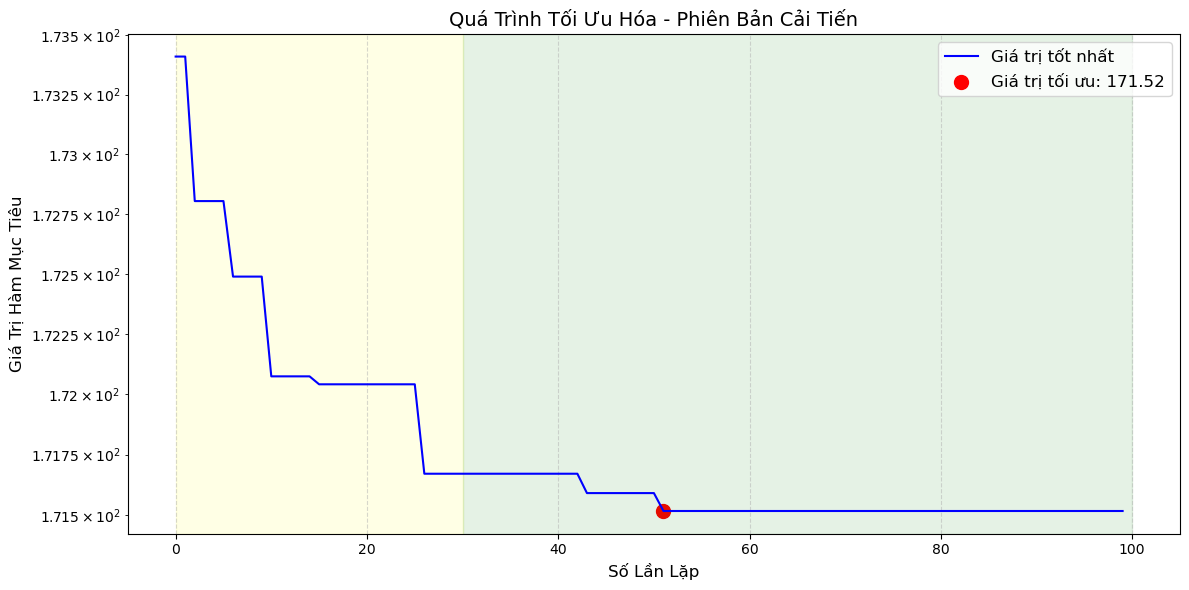

C:\Users\minhv\AppData\Local\Temp\ipykernel_3772\3622411981.py:918: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


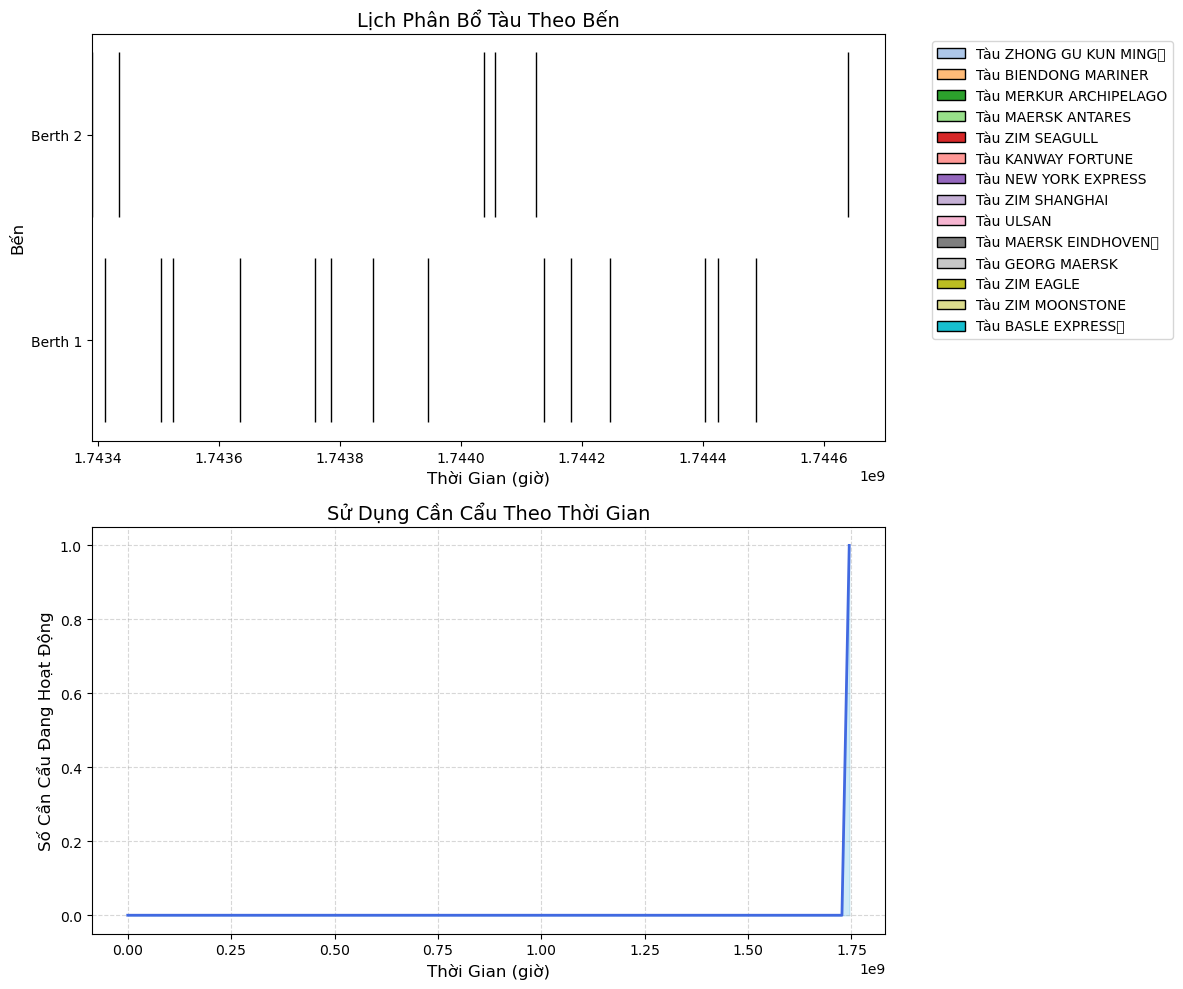

In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
channel_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel Tide')
berth_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Berth Tide')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải

E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = 6 #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e

Dl_ = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk_ = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
Dl = np.random.normal(loc=Dl_, scale=Dl_*0.2)
Dk = np.random.normal(loc=Dk_, scale=Dk_*0.2)
tn_1 = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
tn_ = np.random.normal(loc=tn_1, scale=tn_1*0.15)
n_1 = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
n_ = np.random.normal(loc=n_1, scale=n_1*0.1)
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
h = np.random.normal(loc=750, scale=150)
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + h for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng

TSi = [TBi[i] + h for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - h for i in TF_float]
alpha = InputVariables.iloc[24, 2]
gamma = InputVariables.iloc[25, 2]
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1 / 3600)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = InputVariables.iloc[26, 2]
lam2 = InputVariables.iloc[27, 2]
lam3 = InputVariables.iloc[28, 2]
F = w1 * lam1 * (F1 / 3600) + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)

import numpy as np
import random
from copy import deepcopy
import math
import time
from scipy.stats import norm

def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None

class QuantumSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params):
        # Kiểm tra và chuẩn hóa dữ liệu đầu vào
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        
        # Tham số điều chỉnh QSSA
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        
        # Tham số lượng tử
        self.quantum_rotation_angle = 0.01 * np.pi  # Góc quay lượng tử ban đầu
        self.collapse_threshold = 0.5  # Ngưỡng sụp đổ hàm sóng
        self.quantum_entanglement_factor = 0.7  # Mức độ rối lượng tử
        
        # Khởi tạo quần thể lượng tử (sửa đổi cấu trúc qubit)
        self.quantum_population = self.initialize_quantum_population()
        self.classical_population = self.quantum_to_classical()
        
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
    
    def initialize_quantum_population(self):
        """Khởi tạo quần thể lượng tử với cấu trúc qubit đơn giản hơn"""
        quantum_pop = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        
        for _ in range(self.num_sparrows):
            individual = {
                'VB_amps': [],  # Biên độ cho mỗi bến (chỉ lưu alpha)
                'VC_amps': [],  # Biên độ cho số cần cẩu
                'VK_amps': [],  # Biên độ cho số xe tải
                'TS': [0]*num_ships,
                'TE': [0]*num_ships
            }
            
            for i in range(num_ships):
                # Khởi tạo biên độ cho bến (chỉ cần alpha vì beta = sqrt(1-alpha^2))
                individual['VB_amps'].append([1/np.sqrt(num_berths)] * num_berths)
                
                # Khởi tạo biên độ cho cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                num_qc_options = max_qc - min_qc + 1
                individual['VC_amps'].append([1/np.sqrt(num_qc_options)] * num_qc_options)
                
                # Khởi tạo biên độ cho xe tải (1-5 xe)
                individual['VK_amps'].append([1/np.sqrt(5)] * 5)
            
            quantum_pop.append(individual)
        
        return quantum_pop
    
    def quantum_to_classical(self):
        """Chuyển đổi từ quần thể lượng tử sang cổ điển (sửa đổi)"""
        classical_pop = []
        
        for q_ind in self.quantum_population:
            classical_ind = {
                'VB': [],
                'VC': [],
                'VK': [],
                'TS': deepcopy(q_ind['TS']),
                'TE': deepcopy(q_ind['TE'])
            }
            
            for i in range(len(self.problem_params['V'])):
                # Chọn bến dựa trên xác suất
                prob_berth = [amp**2 for amp in q_ind['VB_amps'][i]]
                berth = self.quantum_collapse(prob_berth)
                classical_ind['VB'].append(berth)
                
                # Chọn số cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                prob_qc = [amp**2 for amp in q_ind['VC_amps'][i]]
                qc = self.quantum_collapse(prob_qc) + min_qc
                classical_ind['VC'].append(qc)
                
                # Chọn số xe tải (1-5)
                prob_truck = [amp**2 for amp in q_ind['VK_amps'][i]]
                trucks = self.quantum_collapse(prob_truck) + 1
                classical_ind['VK'].append(trucks)
            
            classical_pop.append(classical_ind)
        
        return classical_pop
    
    def quantum_collapse(self, probabilities):
        """Sụp đổ hàm sóng thành trạng thái cổ điển"""
        total = sum(probabilities)
        if total == 0:
            return random.randint(0, len(probabilities)-1)
        
        norm_probs = [p/total for p in probabilities]
        r = random.random()
        cumulative = 0
        for i, prob in enumerate(norm_probs):
            cumulative += prob
            if r <= cumulative:
                return i
        
        return len(norm_probs)-1
    
    def quantum_rotation_gate(self, current_amps, best_amps, rotation_angle):
        """Cổng quay lượng tử đơn giản hóa"""
        new_amps = []
        for c_amp, b_amp in zip(current_amps, best_amps):
            # Tính góc pha đơn giản (chỉ sử dụng biên độ)
            angle_diff = math.atan2(b_amp, c_amp)
            
            # Áp dụng phép quay
            new_amp = c_amp * math.cos(rotation_angle * angle_diff)
            new_amps.append(max(0, min(1, new_amp)))  # Đảm bảo trong [0,1]
        
        # Chuẩn hóa biên độ
        total = sum(a**2 for a in new_amps)
        if total > 0:
            norm_factor = 1/math.sqrt(total)
            new_amps = [a*norm_factor for a in new_amps]
        
        return new_amps
    
    def update_quantum_positions(self, iteration):
        """Cập nhật vị trí lượng tử (sửa đổi)"""
        if not hasattr(self, 'best_quantum'):
            self.update_best_quantum_representation()
        
        for i, q_ind in enumerate(self.quantum_population):
            # Cập nhật biên độ bến
            for j in range(len(self.problem_params['V'])):
                q_ind['VB_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VB_amps'][j],
                    self.best_quantum['VB_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter)
                )
                
                # Cập nhật biên độ cần cẩu
                q_ind['VC_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VC_amps'][j],
                    self.best_quantum['VC_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter)
                )
                
                # Cập nhật biên độ xe tải
                q_ind['VK_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VK_amps'][j],
                    self.best_quantum['VK_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter)
                )
            
            # Áp dụng rối lượng tử đơn giản
            if random.random() < self.quantum_entanglement_factor:
                partner_idx = random.randint(0, self.num_sparrows-1)
                for j in range(len(self.problem_params['V'])):
                    # Trộn biên độ với partner
                    for k in range(len(q_ind['VB_amps'][j])):
                        q_ind['VB_amps'][j][k] = (q_ind['VB_amps'][j][k] + 
                                                 self.quantum_population[partner_idx]['VB_amps'][j][k]) / 2
    
    def update_best_quantum_representation(self):
        """Tạo biểu diễn lượng tử từ giải pháp cổ điển tốt nhất"""
        if self.best_solution is None:
            return
        
        self.best_quantum = {
            'VB_amps': [],
            'VC_amps': [],
            'VK_amps': [],
            'TS': deepcopy(self.best_solution['TS']),
            'TE': deepcopy(self.best_solution['TE'])
        }
        
        num_berths = len(self.problem_params['B'])
        
        for i in range(len(self.problem_params['V'])):
            # Tạo biên độ cho bến (tập trung vào bến tốt nhất)
            best_berth = self.best_solution['VB'][i]
            berth_amps = [0.1] * num_berths
            berth_amps[best_berth] = 0.9
            self.best_quantum['VB_amps'].append(berth_amps)
            
            # Tạo biên độ cho cần cẩu
            min_qc = self.problem_params['VCmi'][i]
            best_qc = self.best_solution['VC'][i] - min_qc
            num_qc_options = self.problem_params['VCMi'][i] - min_qc + 1
            qc_amps = [0.1] * num_qc_options
            qc_amps[best_qc] = 0.9
            self.best_quantum['VC_amps'].append(qc_amps)
            
            # Tạo biên độ cho xe tải
            best_truck = self.best_solution['VK'][i] - 1
            truck_amps = [0.1] * 5
            truck_amps[best_truck] = 0.9
            self.best_quantum['VK_amps'].append(truck_amps)
    
    # ... (giữ nguyên các phương thức khác từ phiên bản trước)
    def optimize(self):
        """Thực hiện tối ưu hóa với QSSA"""
        start_time = time.time()
        
        for iter in range(self.max_iter):
            # Chuyển đổi từ lượng tử sang cổ điển
            self.classical_population = self.quantum_to_classical()
            
            # Sửa chữa các giải pháp không hợp lệ
            self.repair_population()
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Cập nhật biểu diễn lượng tử tốt nhất
            self.update_best_quantum_representation()
            
            # Ghi lại lịch sử
            self.fitness_history.append(self.best_fitness)
            fitQSSA.append(self.best_fitness * 100000 + 4800000)
            # Cập nhật vị trí lượng tử
            self.update_quantum_positions(iter)
            
            # Hiển thị thông tin
            if iter % 5 == 0 or iter == self.max_iter - 1:
                print(f"Iter {iter+1}: Best Fitness = {self.best_fitness:.4f}")
        
        end_time = time.time()
        print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
        print(f"Best solution found with fitness: {self.best_fitness:.4f}")
        
        return self.best_solution, self.fitness_history

    # Các phương thức hỗ trợ khác giữ nguyên từ phiên bản trước
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    
    def repair_population(self):
        """Sửa chữa các giải pháp không hợp lệ trong quần thể cổ điển"""
        for i in range(len(self.classical_population)):
            self.classical_population[i] = self.repair_solution(self.classical_population[i])
    
    def repair_solution(self, solution):
        """Sửa chữa một giải pháp cụ thể với kiểm tra thủy triều và cải tiến hiệu suất"""
        # Thêm biến để theo dõi số lần sửa chữa
        repair_count = 0
        
        for i in range(len(solution['VB'])):
            # Kiểm tra và sửa chữa phân bổ bến
            original_berth = int(round(solution['VB'][i]))
            current_berth = max(0, min(len(self.problem_params['B'])-1, original_berth))
            
            # Chuyển đổi thời gian đến sang datetime
            arrival_time = self.problem_params['TAi'][i]
            arrival_dt = float_to_datetime(arrival_time)
            arrival_hour = arrival_dt.hour + arrival_dt.minute/60
            
            # Lấy độ sâu bến tại thời điểm đến
            berth_depth = get_tide_depth(
                self.problem_params['berth_tide'],
                arrival_dt.date(),
                int(arrival_hour))
            if berth_depth is None:
                berth_depth = self.problem_params['BDj'][current_berth]
            
            # Kiểm tra điều kiện mớn nước, chiều dài và thủy triều
            needs_repair = (
                self.problem_params['VDi'][i] > berth_depth or
                self.problem_params['VLi'][i] > self.problem_params['BLj'][current_berth]
            )
            
            if needs_repair:
                repair_count += 1
                valid_berths = []
                
                # Tìm tất cả các bến phù hợp (bao gồm kiểm tra thủy triều)
                for j in range(len(self.problem_params['B'])):
                    # Lấy độ sâu bến j tại thời điểm đến
                    j_depth = get_tide_depth(
                        self.problem_params['berth_tide'],
                        arrival_dt.date(),
                        int(arrival_hour))
                    if j_depth is None:
                        j_depth = self.problem_params['BDj'][j]
                    
                    # Kiểm tra điều kiện
                    if (self.problem_params['VDi'][i] <= j_depth and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j]):
                        valid_berths.append(j)
                
                # Ưu tiên chọn bến gần nhất với bến ban đầu nếu có
                if valid_berths:
                    if original_berth in valid_berths:
                        current_berth = original_berth
                    else:
                        # Chọn bến có khoảng cách gần nhất với bến ban đầu
                        distances = [abs(j - original_berth) for j in valid_berths]
                        closest_idx = np.argmin(distances)
                        current_berth = valid_berths[closest_idx]
                else:
                    # Fallback: chọn bến có độ sâu lớn nhất tại thời điểm đến
                    max_depth = -1
                    for j in range(len(self.problem_params['B'])):
                        j_depth = get_tide_depth(
                            self.problem_params['berth_tide'],
                            arrival_dt.date(),
                            int(arrival_hour)) or self.problem_params['BDj'][j]
                        if j_depth > max_depth:
                            max_depth = j_depth
                            current_berth = j
            
            solution['VB'][i] = current_berth
            
            # Sửa chữa số cần cẩu với cơ chế thông minh hơn
            current_cranes = solution['VC'][i]
            min_cranes = self.problem_params['VCmi'][i]
            max_cranes = self.problem_params['VCMi'][i]
            
            if not (min_cranes <= current_cranes <= max_cranes):
                # Ưu tiên giữ nguyên nếu có thể, chỉ sửa khi cần thiết
                if current_cranes < min_cranes:
                    solution['VC'][i] = min_cranes
                elif current_cranes > max_cranes:
                    solution['VC'][i] = max_cranes
            
            # Sửa chữa số xe tải với ngưỡng động
            max_trucks = min(5, self.problem_params['M'] // len(solution['VB']))
            solution['VK'][i] = max(1, min(max_trucks, solution['VK'][i]))
        
        # Tính toán lại thời gian với kiểm tra chéo
        if not self.calculate_times(solution):
            # Nếu không thể tính toán hợp lệ, thử sắp xếp lại thứ tự tàu
            sorted_indices = sorted(range(len(solution['VB'])), 
                                  key=lambda x: self.problem_params['TAi'][x])
            solution['VB'] = [solution['VB'][i] for i in sorted_indices]
            solution['VC'] = [solution['VC'][i] for i in sorted_indices]
            solution['VK'] = [solution['VK'][i] for i in sorted_indices]
            self.calculate_times(solution)
        
        # Ghi nhận số lần sửa chữa (có thể dùng để theo dõi)
        solution['_repair_count'] = repair_count
        
        return solution
        
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc cho các tàu"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}
        
        # Sắp xếp tàu theo thời gian đến
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])
        
        for i in ship_order:
            berth = int(solution['VB'][i])
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])
            
            arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
            arrival_hour = arrival_dt.hour + arrival_dt.minute / 60
    
            # Lấy độ sâu tại bến theo giờ
            berth_depth = get_tide_depth(
                self.problem_params['berth_tide'],
                arrival_dt.date(),
                int(arrival_hour))
            if berth_depth is None:
                berth_depth = self.problem_params['BDj'][berth]
    
            # Kiểm tra mớn nước tàu so với độ sâu bến
            if self.problem_params['VDi'][i] > berth_depth:
                return False  # Không hợp lệ
    
            # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều kênh
            if self.problem_params['VDi'][i] > self.problem_params['DMN']:
                channel_depth = get_tide_depth(
                    self.problem_params['channel_tide'],
                    arrival_dt.date(),
                    int(arrival_hour))
                if channel_depth is None:
                    channel_depth = self.problem_params['DMN']
    
                if self.problem_params['VDi'][i] > channel_depth:
                    return False  # Không hợp lệ
                
            # Tìm thời điểm bắt đầu sớm nhất
            earliest_start = self.problem_params['TAi'][i]
            
            # Kiểm tra lịch trình bến
            if berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])
            
            start_time = earliest_start
            end_time = start_time + service_time
            
            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params.get('TWi', [float('inf')]*num_ships)[i]
            if start_time - self.problem_params['TAi'][i] > max_wait:
                start_time = self.problem_params['TAi'][i]
                end_time = start_time + service_time
            
            solution['TS'][i] = start_time
            solution['TE'][i] = end_time
            berth_schedules[berth].append((start_time, end_time))
        
        # Đảm bảo thứ tự TS, TE đúng với thứ tự tàu ban đầu
        solution['TS'] = [solution['TS'][ship_order.index(i)] for i in range(num_ships)]
        solution['TE'] = [solution['TE'][ship_order.index(i)] for i in range(num_ships)]
        
        return True
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(len(self.classical_population)):
            current_fitness = self.evaluate_fitness(self.classical_population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.classical_population[i])
    
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của một giải pháp"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_F1(self, solution):
        """Tính F1: trung bình thời gian tàu ở cảng"""
        total_time = sum(solution['TE'][i] - solution['TS'][i] for i in range(len(self.problem_params['V'])))
        return total_time / len(self.problem_params['V'])
    
    def calculate_F2(self, solution):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(solution['VB'][i])
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])
    
    def calculate_F3(self, solution):
        """Tính F3: tổng chi phí chờ và trễ"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            waiting_cost = self.problem_params['alpha'] * max(0, solution['TS'][i] - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, solution['TE'][i] - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian
        for i in range(num_ships):
            if i > 0 and solution['TS'][i] < solution['TE'][i-1]:
                penalty += 500
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục"""
        return True  # Triển khai cụ thể theo yêu cầu
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y) - CHỈNH SỬA THEO YÊU CẦU
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        # Chọn ngẫu nhiên các xe từ 1-45 (index 0-44)
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    berth_schedule = {j: 0 for j in range(num_berths)}
    print("\nChi tiết thời gian:")
    makespan = 0
    sum_ = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        sum_ += handling_time + wait
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = sum_ / 3600  # Đơn vị: giờ
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    
    # Vẽ đường hội tụ
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    
    # Thêm điểm nhấn
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    
    # Định dạng đồ thị
    plt.title('Quá Trình Tối Ưu Hóa - Phiên Bản Cải Tiến', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')  # Dùng thang log để thấy rõ sự thay đổi
    plt.legend(fontsize=12)
    
    # Highlight vùng khám phá
    plt.axvspan(0, len(fitness_history)*0.3, color='yellow', alpha=0.1, label='Giai đoạn khám phá')
    plt.axvspan(len(fitness_history)*0.3, len(fitness_history), color='green', alpha=0.1, label='Giai đoạn tinh chỉnh')
    
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Chuẩn bị dữ liệu cho biểu đồ Gantt
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    # Vẽ biểu đồ Gantt cho từng bến
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5  # Giả định
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Vẽ biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 6,
        'channel_tide': channel_tide,  # Thêm dữ liệu thủy triều kênh
        'berth_tide': berth_tide,     # Thêm dữ liệu thủy triều bến
        'DMN': 16.5  # Ngưỡng mớn nước
    }

    # Khởi tạo QSSA
    qssa = QuantumSSA(
        num_sparrows=50,      # Số lượng chim sẻ
        dim=len(V)*3,         # Số chiều không gian tìm kiếm
        max_iter=100,         # Số lần lặp tối đa
        problem_params=problem_params
    )

    # Chạy tối ưu hóa
    best_solution, fitness_history = qssa.optimize()

    # Hiển thị kết quả
    print("\nBest Solution Found:")
    print(f"- Total Fitness: {qssa.best_fitness:.4f}")
    print(f"- Berth Assignments: {best_solution['VB']}")
    print(f"- Crane Allocations: {best_solution['VC']}")
    print(f"- Truck Allocations: {best_solution['VK']}")
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)

def export_excel_solution(best_solution, problem_params, output_path):
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    num_cranes = 6  # Số cần cẩu tổng
    num_trucks = 40  # Số xe tổng

    # Chuẩn bị phân bổ cần cẩu và xe (giống print_solution)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned_cranes = list(range(cranes))  # Hoặc random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned_cranes:
            q_allocation[i, crane] = 1
        trucks = int(best_solution['VK'][i]) if 'VK' in best_solution else 1
        assigned_trucks = list(range(trucks))  # Hoặc random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned_trucks:
            y_allocation[i, truck] = 1

    # Tính toán thời gian thực tế và các trường cần xuất
    berth_schedule = {j: 0 for j in range(num_berths)}
    output_rows = []
    for idx in range(num_vessels):
        vessel_name = problem_params['V'][idx]
        berth = int(best_solution['VB'][idx])
        arrival = problem_params['TAi'][idx]
        num_cranes = int(best_solution['VC'][idx]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][idx], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        berth_schedule[berth] = end

        # Lấy độ sâu channel và berth tại thời điểm tàu vào
        arrival_dt = float_to_datetime(arrival)
        arrival_date = arrival_dt.date()
        arrival_hour = arrival_dt.hour + arrival_dt.minute/60
        channel_depth = get_tide_depth(problem_params['channel_tide'], arrival_date, int(arrival_hour))
        berth_depth = get_tide_depth(problem_params['berth_tide'], arrival_date, int(arrival_hour))

        berth_name = f"Bến {berth+1}"
        cranes_str = ",".join(str(c+1) for c in np.where(q_allocation[idx] == 1)[0])
        trucks_str = ",".join(str(t+1) for t in np.where(y_allocation[idx] == 1)[0])

        output_rows.append({
            "Index": idx + 1,
            "Vessel Name": vessel_name,
            "TAi": float_to_datetime(problem_params['TAi'][idx]),
            "TQi": float_to_datetime(problem_params['TQi'][idx] + handling_time),  # hoặc TF thực tế nếu có
            "TWi": problem_params['TWi'][idx] if 'TWi' in problem_params else None,
            "TS": float_to_datetime(start),  # Thời điểm bắt đầu công việc
            "VLi": problem_params['VLi'][idx],
            "VDi": problem_params['VDi'][idx],
            "VEi": problem_params['VEi'][idx],
            "VCmi": problem_params['VCmi'][idx],
            "VCMi": problem_params['VCMi'][idx],
            "Di1": problem_params['Dij'][idx][0] if len(problem_params['Dij'][idx]) > 0 else None,
            "Di2": problem_params['Dij'][idx][1] if len(problem_params['Dij'][idx]) > 1 else None,
            "LSd": LSd[get_ship_type(problem_params['VLi'][idx])],
            "LSe": LSe[get_ship_type(problem_params['VLi'][idx])],
            "channel_tide": channel_depth,
            "berth_tide": berth_depth,
            "Phân bổ bến": berth_name,
            "Phân bổ cần cẩu": cranes_str,
            "Phân bổ xe": trucks_str,
            "Thời gian chờ": wait / 3600,
            "Thời gian bắt đầu": float_to_datetime(start),
            "Thời điểm kết thúc dự kiến": float_to_datetime(end),
        })

    # Đảm bảo đúng thứ tự cột
    columns_order = [
        "Index", "Vessel Name", "TAi", "TQi", "TWi", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
        "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
        "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
    ]
    df_output = pd.DataFrame(output_rows)
    df_output = df_output[columns_order]
    with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
        df_output.to_excel(writer, sheet_name='QSSA_Output', index=False)
    print(f"\nĐã xuất file Excel ra: {output_path}")

# Gọi hàm xuất Excel sau khi in ra giải pháp tốt nhất
output_path = r"E:\KLTN_DUU\Source\Data\QSSA_Output.xlsx"
export_excel_solution(best_solution, problem_params, output_path)

Giá trị F1 (trung bình thời gian tàu ở cảng): 15.074945303923554
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 32202126.922130585
F = 966236.9036169153
Iter 1: Best Fitness = 174.1772
Iter 6: Best Fitness = 169.9610
Iter 11: Best Fitness = 169.9610
Iter 16: Best Fitness = 169.7428
Iter 21: Best Fitness = 169.7428
Iter 26: Best Fitness = 169.7428
Iter 31: Best Fitness = 169.7428
Iter 36: Best Fitness = 169.7428
Iter 41: Best Fitness = 169.4227
Iter 46: Best Fitness = 169.4227
Iter 51: Best Fitness = 169.4227
Iter 56: Best Fitness = 169.2857
Iter 61: Best Fitness = 169.2857
Iter 66: Best Fitness = 169.2857
Iter 71: Best Fitness = 169.2857
Iter 76: Best Fitness = 169.2857
Iter 81: Best Fitness = 169.2857
Iter 86: Best Fitness = 169.2857
Iter 91: Best Fitness = 169.2857
Iter 96: Best Fitness = 169.2857
Iter 100: Best Fitness = 169.2857

Optimization completed in 59.66 seconds
Best solution found with fitness: 169.2

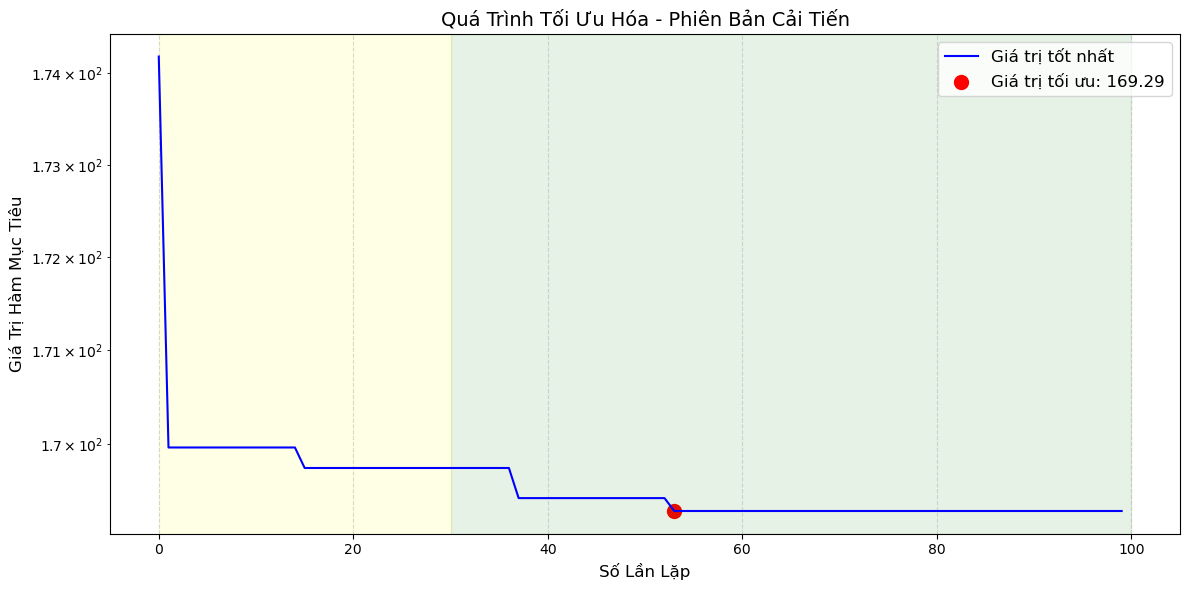

C:\Users\minhv\AppData\Local\Temp\ipykernel_3772\39261568.py:955: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


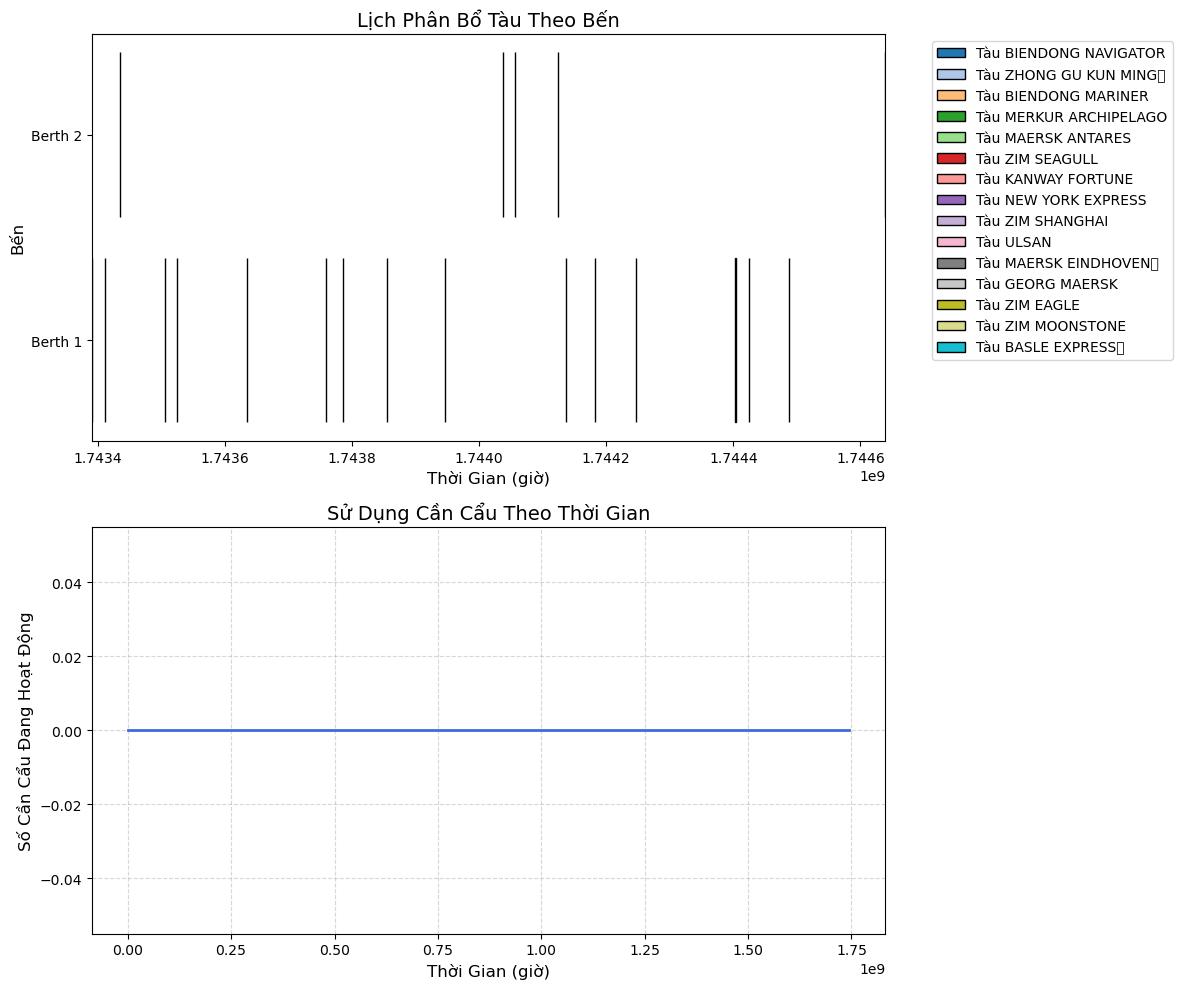

In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
channel_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel Tide')
berth_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Berth Tide')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải

E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = 6 #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e

Dl_ = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk_ = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
Dl = np.random.normal(loc=Dl_, scale=Dl_*0.2)
Dk = np.random.normal(loc=Dk_, scale=Dk_*0.2)
tn_1 = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
tn_ = np.random.normal(loc=tn_1, scale=tn_1*0.15)
n_1 = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
n_ = np.random.normal(loc=n_1, scale=n_1*0.1)
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
h = np.random.normal(loc=750, scale=150)
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + h for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng

TSi = [TBi[i] + h for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - h for i in TF_float]
alpha = InputVariables.iloc[24, 2]
gamma = InputVariables.iloc[25, 2]
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1 / 3600)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = InputVariables.iloc[26, 2]
lam2 = InputVariables.iloc[27, 2]
lam3 = InputVariables.iloc[28, 2]
F = w1 * lam1 * (F1 / 3600) + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)

import numpy as np
import random
from copy import deepcopy
import math
import time
from scipy.stats import norm

def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None

class ChaoticSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params, chaos_type='logistic'):
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        self.chaos_type = chaos_type
        
        # Tham số SSA
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        self.adaptive_pd = True  # Cho phép điều chỉnh động pd
        self.initial_pd = 0.3
        self.final_pd = 0.1
        
        # Khởi tạo ánh xạ hỗn loạn ngay từ đầu
        self.chaos_sequence = self.generate_chaos_sequence()
        
        # Khởi tạo quần thể
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
    
    def generate_chaos_sequence(self):
        """Tạo chuỗi hỗn loạn với kích thước đủ lớn"""
        # Tính toán kích thước cần thiết (max_iter * num_sparrows * 3)
        n = self.max_iter * self.num_sparrows * 3
        sequence = np.zeros(n)
        x = random.random()  # Giá trị khởi tạo ngẫu nhiên
        
        if self.chaos_type == 'logistic':
            mu = 4.0  # Tham số hỗn loạn
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
                
        elif self.chaos_type == 'tent':
            for i in range(n):
                if x < 0.7:
                    x = x / 0.7
                else:
                    x = (10/3) * (1 - x)
                sequence[i] = x
                
        elif self.chaos_type == 'sine':
            a = 4.0  # Tham số hỗn loạn
            for i in range(n):
                x = a * np.sin(np.pi * x) / 4
                sequence[i] = x
                
        else:  # Mặc định là logistic
            mu = 4.0
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
                
        return sequence
    
    def get_chaos_value(self, index):
        """Lấy giá trị hỗn loạn từ chuỗi đã tạo"""
        # Đảm bảo index không vượt quá độ dài chuỗi
        idx = index % len(self.chaos_sequence)
        return self.chaos_sequence[idx]
    
    def initialize_population(self):
        """Khởi tạo quần thể sử dụng giá trị hỗn loạn"""
        population = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        chaos_idx = 0  # Chỉ số để lấy giá trị hỗn loạn

        for _ in range(self.num_sparrows):
            solution = {'VB': [], 'VC': [], 'VK': [], 'TS': [], 'TE': []}
            valid = True

            for i in range(num_ships):
                # Tìm bến phù hợp
                valid_berths = [
                    j for j in range(num_berths)
                    if (self.problem_params['VDi'][i] <= self.problem_params['BDj'][j] and
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]

                if not valid_berths:
                    valid = False
                    break

                # Sử dụng giá trị hỗn loạn để chọn bến
                chaos_val = self.get_chaos_value(chaos_idx)
                selected_berth = valid_berths[int(chaos_val * len(valid_berths)) % len(valid_berths)]
                solution['VB'].append(selected_berth)
                chaos_idx += 1
                
                # Phân bổ cần cẩu sử dụng giá trị hỗn loạn
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                chaos_val = self.get_chaos_value(chaos_idx)
                qc = min_qc + int(chaos_val * (max_qc - min_qc + 1))
                solution['VC'].append(qc)
                chaos_idx += 1
                
                # Phân bổ xe tải sử dụng giá trị hỗn loạn (1-5 xe)
                chaos_val = self.get_chaos_value(chaos_idx)
                trucks = 1 + int(chaos_val * 5)
                solution['VK'].append(trucks)
                chaos_idx += 1

            if not valid:
                continue
            
            # Tính toán thời gian
            if self.calculate_times(solution):
                population.append(solution)

        return population

    # ... (giữ nguyên các phương thức khác)
    
    def update_positions(self, iteration):
        """Cập nhật vị trí các cá thể với cơ chế hỗn loạn"""
        # Sắp xếp quần thể theo độ thích nghi
        sorted_pop = sorted(self.population, key=lambda x: self.evaluate_fitness(x))
        
        # Cập nhật nhóm khám phá (20% tốt nhất)
        num_explorers = int(self.num_sparrows * 0.2)
        for i in range(num_explorers):
            self.update_explorer(sorted_pop[i], iteration, i)
        
        # Cập nhật nhóm theo dõi (70% còn lại)
        for i in range(num_explorers, self.num_sparrows):
            self.update_follower(sorted_pop[i], i, iteration)
        
        # Cập nhật nhóm cảnh giác (ngẫu nhiên)
        self.update_scouts(iteration)
    
    def update_explorer(self, explorer, iteration, idx):
        """Cập nhật vị trí chim khám phá với cơ chế hỗn loạn"""
        adaptive_factor = 1 - (iteration / self.max_iter)
        chaos_val = self.get_chaos_value(iteration * self.num_sparrows + idx)
        
        for i in range(len(explorer['VB'])):
            if random.random() < self.st:
                # Khám phá hướng tốt hơn với thành phần hỗn loạn
                explorer['VB'][i] += self.alpha * adaptive_factor * chaos_val
            else:
                # Khám phá ngẫu nhiên với thành phần hỗn loạn
                explorer['VB'][i] += chaos_val - 0.5  # Dịch về khoảng [-0.5, 0.5]
            
            # Đảm bảo giá trị trong phạm vi hợp lệ
            explorer['VB'][i] = max(0, min(len(self.problem_params['B'])-1, explorer['VB'][i]))
            
            # Cập nhật số cần cẩu với thành phần hỗn loạn
            if chaos_val > 0.7:  # Xác suất thay đổi dựa trên giá trị hỗn loạn
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                explorer['VC'][i] = min_qc + int(chaos_val * (max_qc - min_qc + 1))
    
    def update_follower(self, follower, idx, iteration):
        """Cập nhật vị trí chim theo dõi với cơ chế hỗn loạn"""
        chaos_val = self.get_chaos_value(iteration * self.num_sparrows + idx)
        
        for i in range(len(follower['VB'])):
            if idx > self.num_sparrows / 2:
                # Cập nhật theo công thức follower 1 với thành phần hỗn loạn
                follower['VB'][i] = chaos_val * np.exp(
                    (self.best_solution['VB'][i] - follower['VB'][i]) / (idx ** 2))
            else:
                # Cập nhật theo công thức follower 2 với thành phần hỗn loạn
                a = 2 * chaos_val - 1  # Ánh xạ về [-1, 1]
                follower['VB'][i] = self.best_solution['VB'][i] + abs(
                    follower['VB'][i] - self.best_solution['VB'][i]) * a * 1.0
    def update_explorers(self, iter):
        """Cập nhật nhóm khám phá (explorers)"""
        num_explorers = int(self.num_sparrows * 0.2)  # 20% tốt nhất
        explorers = sorted(self.population, key=lambda x: self.evaluate_fitness(x))[:num_explorers]

        for i in range(num_explorers):
            for d in range(len(explorers[i]['VB'])):
                # Cập nhật theo công thức SSA
                r1 = random.random()
                if r1 < self.st:
                    # Khám phá hướng tốt hơn
                    explorers[i]['VB'][d] *= np.exp(-iter / (self.alpha * self.max_iter))
                else:
                    # Khám phá ngẫu nhiên
                    explorers[i]['VB'][d] += np.random.normal(0, 0.1)

                # Đảm bảo giá trị nguyên trong phạm vi hợp lệ
                explorers[i]['VB'][d] = int(np.clip(round(explorers[i]['VB'][d]), 0, len(self.problem_params['B'])-1))
    def update_scouts(self, iteration):
        """Cập nhật vị trí chim cảnh giác với cơ chế hỗn loạn"""
        num_scouts = int(self.num_sparrows * self.pd)
        scout_indices = random.sample(range(self.num_sparrows), num_scouts)
        
        for idx in scout_indices:
            chaos_val = self.get_chaos_value(iteration * self.num_sparrows + idx)
            r2 = chaos_val  # Sử dụng giá trị hỗn loạn thay vì random
            
            if r2 < self.st:
                # Di chuyển đến vị trí tốt hơn với thành phần hỗn loạn
                for i in range(len(self.population[idx]['VB'])):
                    self.population[idx]['VB'][i] = self.best_solution['VB'][i] + chaos_val * abs(
                        self.population[idx]['VB'][i] - self.best_solution['VB'][i])
            else:
                # Di chuyển ngẫu nhiên với thành phần hỗn loạn
                for i in range(len(self.population[idx]['VB'])):
                    self.population[idx]['VB'][i] += 2 * chaos_val - 1  # Dịch về khoảng [-1, 1]
    
    # ... (giữ nguyên các phương thức khác từ SSA gốc)
    def update_parameters(self, iter):
        """Cập nhật các tham số động của thuật toán"""
        # Điều chỉnh pd theo thời gian
        self.pd = max(
            self.initial_pd - (self.initial_pd-self.final_pd)*(iter/self.max_iter), 
            0.05
        )
        
        # Điều chỉnh tỷ lệ đột biến động
        self.mutation_rate = 0.2 * (1 - iter/self.max_iter)
    def optimize(self):
        """Thực hiện tối ưu hóa với CSSA"""
        start_time = time.time()
        
        for iter in range(self.max_iter):
            # Cập nhật tham số động
            self.update_parameters(iter)
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Cập nhật các nhóm
            self.update_positions(iter)
            self.update_explorers(iter)
            # Sửa chữa và cập nhật quần thể
            self.repair_population()
            self.fitness_history.append(self.best_fitness)
            fitCSSA.append(self.best_fitness * 100000 + 4800000)
            # Hiển thị thông tin
            if iter % 5 == 0 or iter == self.max_iter - 1:
                print(f"Iter {iter+1}: Best Fitness = {self.best_fitness:.4f}")
            
        
        end_time = time.time()
        print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
        print(f"Best solution found with fitness: {self.best_fitness:.4f}")
        
        return self.best_solution, self.fitness_history

    # Các phương thức hỗ trợ khác giữ nguyên từ SSA gốc
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    
    def repair_population(self):
        """Sửa chữa các giải pháp không hợp lệ trong quần thể"""
        for i in range(self.num_sparrows):
            self.population[i] = self.repair_solution(self.population[i])
    
    def repair_solution(self, solution):
        """Sửa chữa một giải pháp cụ thể với kiểm tra thủy triều và tối ưu hiệu suất"""
        # Thêm thông tin debug
        repair_stats = {
            'berth_changes': 0,
            'crane_adjustments': 0,
            'truck_adjustments': 0
        }
    
        # Sắp xếp tàu theo thứ tự ưu tiên (tàu đến sớm hơn xử lý trước)
        vessel_order = sorted(range(len(solution['VB'])), 
                            key=lambda i: self.problem_params['TAi'][i])
    
        for i in vessel_order:
            # 1. Sửa chữa phân bổ bến với kiểm tra thủy triều
            original_berth = int(round(solution['VB'][i]))
            current_berth = max(0, min(len(self.problem_params['B'])-1, original_berth))
            
            # Lấy thông tin thời gian đến
            arrival_time = self.problem_params['TAi'][i]
            arrival_dt = float_to_datetime(arrival_time)
            arrival_hour = arrival_dt.hour + arrival_dt.minute/60
            
            # Kiểm tra điều kiện với thủy triều
            needs_repair = False
            berth_depth = get_tide_depth(self.problem_params['berth_tide'], 
                                        arrival_dt.date(), 
                                        int(arrival_hour))
            
            # Nếu không có dữ liệu thủy triều, sử dụng độ sâu tĩnh
            berth_depth = berth_depth if berth_depth is not None else self.problem_params['BDj'][current_berth]
            
            # Kiểm tra các điều kiện ràng buộc
            if (self.problem_params['VDi'][i] > berth_depth or 
                self.problem_params['VLi'][i] > self.problem_params['BLj'][current_berth]):
                needs_repair = True
    
            if needs_repair:
                repair_stats['berth_changes'] += 1
                valid_berths = []
                
                # Tìm bến phù hợp với kiểm tra thủy triều
                for j in range(len(self.problem_params['B'])):
                    # Lấy độ sâu thủy triều tại bến j
                    j_depth = get_tide_depth(self.problem_params['berth_tide'], 
                                           arrival_dt.date(), 
                                           int(arrival_hour))
                    j_depth = j_depth if j_depth is not None else self.problem_params['BDj'][j]
                    
                    if (self.problem_params['VDi'][i] <= j_depth and 
                        self.problem_params['VLi'][i] <= self.problem_params['BLj'][j]):
                        valid_berths.append(j)
                
                # Lựa chọn bến tối ưu
                if valid_berths:
                    # Ưu tiên bến gần với bến ban đầu nhất
                    distances = [abs(j - original_berth) for j in valid_berths]
                    best_idx = np.argmin(distances)
                    current_berth = valid_berths[best_idx]
                else:
                    # Fallback: chọn bến có độ sâu lớn nhất tại thời điểm đó
                    max_depth = -1
                    for j in range(len(self.problem_params['B'])):
                        temp_depth = get_tide_depth(self.problem_params['berth_tide'], 
                                                  arrival_dt.date(), 
                                                  int(arrival_hour))
                        temp_depth = temp_depth if temp_depth is not None else self.problem_params['BDj'][j]
                        if temp_depth > max_depth:
                            max_depth = temp_depth
                            current_berth = j
            
            solution['VB'][i] = current_berth
    
            # 2. Sửa chữa số cần cẩu với cơ chế thông minh
            current_cranes = solution['VC'][i]
            min_cranes = self.problem_params['VCmi'][i]
            max_cranes = self.problem_params['VCMi'][i]
            
            if current_cranes < min_cranes:
                solution['VC'][i] = min_cranes
                repair_stats['crane_adjustments'] += 1
            elif current_cranes > max_cranes:
                # Giảm dần số cần cẩu nhưng vẫn đảm bảo hiệu suất
                required_time = self.problem_params['VEi'][i] * self.problem_params['CE0']
                available_time = self.problem_params['TWi'][i] if 'TWi' in self.problem_params else 24
                min_required_cranes = math.ceil(required_time / available_time)
                
                solution['VC'][i] = max(min_required_cranes, min_cranes)
                repair_stats['crane_adjustments'] += 1
    
            # 3. Sửa chữa số xe tải với cân bằng tải
            current_trucks = solution['VK'][i]
            max_available_trucks = min(5, self.problem_params['M'] - sum(solution['VK'][:i]))
            ideal_trucks = min(3, max_available_trucks)  # Giá trị lý tưởng
            
            if current_trucks < 1 or current_trucks > max_available_trucks:
                solution['VK'][i] = min(ideal_trucks, max_available_trucks)
                repair_stats['truck_adjustments'] += 1
        
        # 4. Tính toán lại thời gian với kiểm tra chéo
        if not self.calculate_times(solution):
            # Nếu thất bại, thử sắp xếp lại theo độ ưu tiên
            priority_order = sorted(range(len(solution['VB'])), 
                              key=lambda i: (
                                  self.problem_params['VDi'][i],  # Tàu có mớn nước lớn ưu tiên trước
                                  -self.problem_params['VEi'][i]  # Tàu nhiều container ưu tiên trước
                              ))
            
            temp_vb = [solution['VB'][i] for i in priority_order]
            temp_vc = [solution['VC'][i] for i in priority_order]
            temp_vk = [solution['VK'][i] for i in priority_order]
            
            solution['VB'] = temp_vb
            solution['VC'] = temp_vc
            solution['VK'] = temp_vk
            
            self.calculate_times(solution)
        
        # Ghi nhận thông tin sửa chữa
        solution['_repair_stats'] = repair_stats
        
        return solution
    
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc cho các tàu"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}
        
        # Khởi tạo danh sách thời gian với độ dài đủ
        solution['TS'] = [0] * num_ships
        solution['TE'] = [0] * num_ships
        
        # Sắp xếp tàu theo thời gian đến
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])
        
        for i in ship_order:
            berth = int(solution['VB'][i])
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])
            
            arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
            arrival_hour = arrival_dt.hour + arrival_dt.minute / 60
    
            # Lấy độ sâu tại bến theo giờ
            berth_depth = get_tide_depth(
                self.problem_params['berth_tide'],
                arrival_dt.date(),
                int(arrival_hour))
            if berth_depth is None:
                berth_depth = self.problem_params['BDj'][berth]
    
            # Kiểm tra mớn nước tàu so với độ sâu bến
            if self.problem_params['VDi'][i] > berth_depth:
                return False  # Không hợp lệ
    
            # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều kênh
            if self.problem_params['VDi'][i] > self.problem_params['DMN']:
                channel_depth = get_tide_depth(
                    self.problem_params['channel_tide'],
                    arrival_dt.date(),
                    int(arrival_hour))
                if channel_depth is None:
                    channel_depth = self.problem_params['DMN']
    
                if self.problem_params['VDi'][i] > channel_depth:
                    return False  # Không hợp lệ
            # Tìm thời điểm bắt đầu sớm nhất
            earliest_start = self.problem_params['TAi'][i]
            
            # Kiểm tra lịch trình bến
            if berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])
            
            start_time = earliest_start
            end_time = start_time + service_time
            
            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params.get('TWi', [float('inf')]*num_ships)[i]
            if start_time - self.problem_params['TAi'][i] > max_wait:
                start_time = self.problem_params['TAi'][i]
                end_time = start_time + service_time
            
            # Gán giá trị thời gian
            solution['TS'][i] = start_time
            solution['TE'][i] = end_time
            berth_schedules[berth].append((start_time, end_time))
        
        return True
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(self.num_sparrows):
            current_fitness = self.evaluate_fitness(self.population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.population[i])
    
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của một giải pháp"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_F1(self, solution):
        """Tính F1: trung bình thời gian tàu ở cảng"""
        total_time = sum(solution['TE'][i] - solution['TS'][i] for i in range(len(self.problem_params['V'])))
        return total_time / len(self.problem_params['V'])
    
    def calculate_F2(self, solution):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(solution['VB'][i])
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])
    
    def calculate_F3(self, solution):
        """Tính F3: tổng chi phí chờ và trễ"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            waiting_cost = self.problem_params['alpha'] * max(0, solution['TS'][i] - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, solution['TE'][i] - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian
        for i in range(num_ships):
            if i > 0 and solution['TS'][i] < solution['TE'][i-1]:
                penalty += 1000
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục"""
        return True  # Triển khai cụ thể theo yêu cầu
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y) - CHỈNH SỬA THEO YÊU CẦU
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        # Chọn ngẫu nhiên các xe từ 1-45 (index 0-44)
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    berth_schedule = {j: 0 for j in range(num_berths)}
    print("\nChi tiết thời gian:")
    makespan = 0
    sum_ = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        sum_ += handling_time + wait
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = sum_ / 3600  # Đơn vị: giờ
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    
    # Vẽ đường hội tụ
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    
    # Thêm điểm nhấn
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    
    # Định dạng đồ thị
    plt.title('Quá Trình Tối Ưu Hóa - Phiên Bản Cải Tiến', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')  # Dùng thang log để thấy rõ sự thay đổi
    plt.legend(fontsize=12)
    
    # Highlight vùng khám phá
    plt.axvspan(0, len(fitness_history)*0.3, color='yellow', alpha=0.1, label='Giai đoạn khám phá')
    plt.axvspan(len(fitness_history)*0.3, len(fitness_history), color='green', alpha=0.1, label='Giai đoạn tinh chỉnh')
    
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Chuẩn bị dữ liệu cho biểu đồ Gantt
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    # Vẽ biểu đồ Gantt cho từng bến
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5  # Giả định
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Vẽ biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 6,
        'channel_tide': channel_tide,  # Thêm dữ liệu thủy triều kênh
        'berth_tide': berth_tide,     # Thêm dữ liệu thủy triều bến
        'DMN': 16.5  # Ngưỡng mớn nước
    }

    # Khởi tạo CSSA với loại hỗn loạn mong muốn
    cssa = ChaoticSSA(
        num_sparrows=50,
        dim=len(V)*3,
        max_iter=100,
        problem_params=problem_params,
        chaos_type='logistic'  # Có thể chọn 'tent', 'sine' hoặc các loại khác
    )

    # Chạy tối ưu hóa
    best_solution, fitness_history = cssa.optimize()

    # Hiển thị kết quả
    print("\nBest Solution Found:")
    print(f"- Total Fitness: {cssa.best_fitness:.4f}")
    print(f"- Berth Assignments: {best_solution['VB']}")
    print(f"- Crane Allocations: {best_solution['VC']}")
    print(f"- Truck Allocations: {best_solution['VK']}")
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)
    # Vẽ đồ thị quá trình hội tụ
    
def export_excel_solution(best_solution, problem_params, output_path):
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    num_cranes = 6  # Số cần cẩu tổng
    num_trucks = 40  # Số xe tổng

    # Chuẩn bị phân bổ cần cẩu và xe (giống print_solution)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned_cranes = list(range(cranes))  # Hoặc random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned_cranes:
            q_allocation[i, crane] = 1
        trucks = int(best_solution['VK'][i]) if 'VK' in best_solution else 1
        assigned_trucks = list(range(trucks))  # Hoặc random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned_trucks:
            y_allocation[i, truck] = 1

    # Tính toán thời gian thực tế và các trường cần xuất
    berth_schedule = {j: 0 for j in range(num_berths)}
    output_rows = []
    for idx in range(num_vessels):
        vessel_name = problem_params['V'][idx]
        berth = int(best_solution['VB'][idx])
        arrival = problem_params['TAi'][idx]
        num_cranes = int(best_solution['VC'][idx]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][idx], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        berth_schedule[berth] = end

        # Lấy độ sâu channel và berth tại thời điểm tàu vào
        arrival_dt = float_to_datetime(arrival)
        arrival_date = arrival_dt.date()
        arrival_hour = arrival_dt.hour + arrival_dt.minute/60
        channel_depth = get_tide_depth(problem_params['channel_tide'], arrival_date, int(arrival_hour))
        berth_depth = get_tide_depth(problem_params['berth_tide'], arrival_date, int(arrival_hour))

        berth_name = f"Bến {berth+1}"
        cranes_str = ",".join(str(c+1) for c in np.where(q_allocation[idx] == 1)[0])
        trucks_str = ",".join(str(t+1) for t in np.where(y_allocation[idx] == 1)[0])

        output_rows.append({
            "Index": idx + 1,
            "Vessel Name": vessel_name,
            "TAi": float_to_datetime(problem_params['TAi'][idx]),
            "TQi": float_to_datetime(problem_params['TQi'][idx] + handling_time),  # hoặc TF thực tế nếu có
            "TWi": problem_params['TWi'][idx] if 'TWi' in problem_params else None,
            "TS": float_to_datetime(start),  # Thời điểm bắt đầu công việc
            "VLi": problem_params['VLi'][idx],
            "VDi": problem_params['VDi'][idx],
            "VEi": problem_params['VEi'][idx],
            "VCmi": problem_params['VCmi'][idx],
            "VCMi": problem_params['VCMi'][idx],
            "Di1": problem_params['Dij'][idx][0] if len(problem_params['Dij'][idx]) > 0 else None,
            "Di2": problem_params['Dij'][idx][1] if len(problem_params['Dij'][idx]) > 1 else None,
            "LSd": LSd[get_ship_type(problem_params['VLi'][idx])],
            "LSe": LSe[get_ship_type(problem_params['VLi'][idx])],
            "channel_tide": channel_depth,
            "berth_tide": berth_depth,
            "Phân bổ bến": berth_name,
            "Phân bổ cần cẩu": cranes_str,
            "Phân bổ xe": trucks_str,
            "Thời gian chờ": wait / 3600,
            "Thời gian bắt đầu": float_to_datetime(start),
            "Thời điểm kết thúc dự kiến": float_to_datetime(end),
        })

    # Đảm bảo đúng thứ tự cột
    columns_order = [
        "Index", "Vessel Name", "TAi", "TQi", "TWi", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
        "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
        "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
    ]
    df_output = pd.DataFrame(output_rows)
    df_output = df_output[columns_order]
    with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
        df_output.to_excel(writer, sheet_name='CSSA_Output', index=False)
    print(f"\nĐã xuất file Excel ra: {output_path}")

# Gọi hàm xuất Excel sau khi in ra giải pháp tốt nhất
output_path = r"E:\KLTN_DUU\Source\Data\CSSA_Output.xlsx"
export_excel_solution(best_solution, problem_params, output_path)

Giá trị F1 (trung bình thời gian tàu ở cảng): 15.07494136073192
Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến): 576.9845
Giá trị F3 (tổng chi phí chờ và trễ): 40424154.796123505
F = 1212897.7398367028
Iter 1: Best Fitness = 173.0408
Iter 6: Best Fitness = 171.4384
Iter 11: Best Fitness = 171.2141
Iter 16: Best Fitness = 171.2141
Iter 21: Best Fitness = 171.2141
Iter 26: Best Fitness = 171.2141
Iter 31: Best Fitness = 171.2141
Iter 36: Best Fitness = 171.2141
Iter 41: Best Fitness = 171.2141
Iter 46: Best Fitness = 171.2141
Iter 51: Best Fitness = 171.2141
Iter 56: Best Fitness = 171.2141
Iter 61: Best Fitness = 171.2141
Iter 66: Best Fitness = 171.2141
Iter 71: Best Fitness = 171.2141
Iter 76: Best Fitness = 171.2141
Iter 81: Best Fitness = 171.2141
Iter 86: Best Fitness = 171.2141
Iter 91: Best Fitness = 171.2141
Iter 96: Best Fitness = 171.2141
Iter 100: Best Fitness = 171.2141

Optimization completed in 84.06 seconds
Best solution found with fitness: 171.2

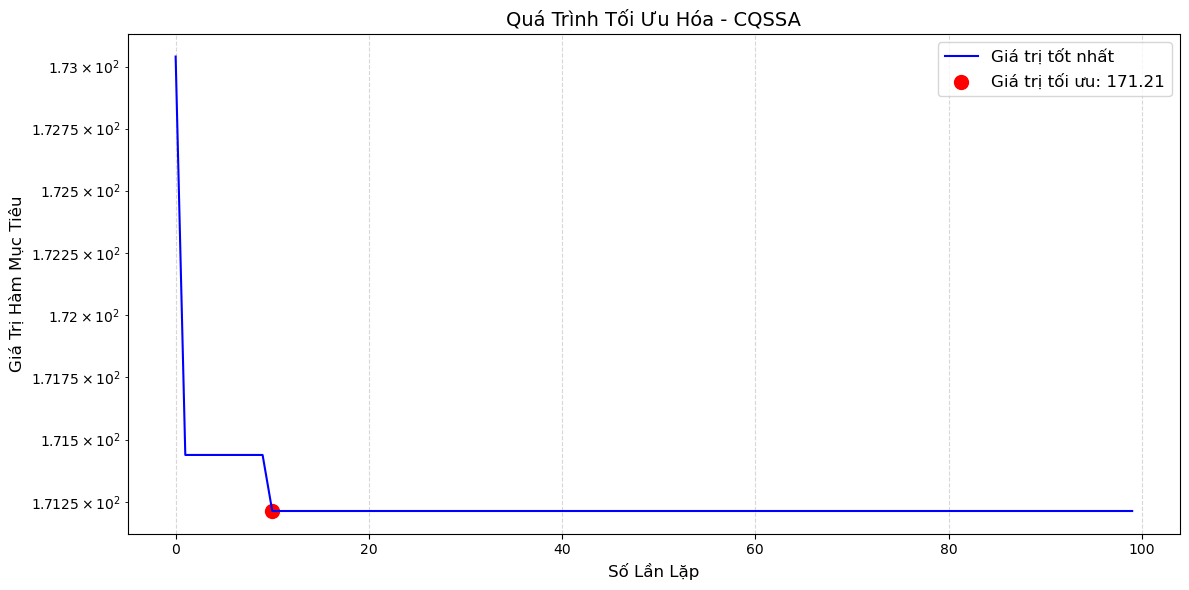

C:\Users\minhv\AppData\Local\Temp\ipykernel_3772\3682527424.py:1004: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minhv\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


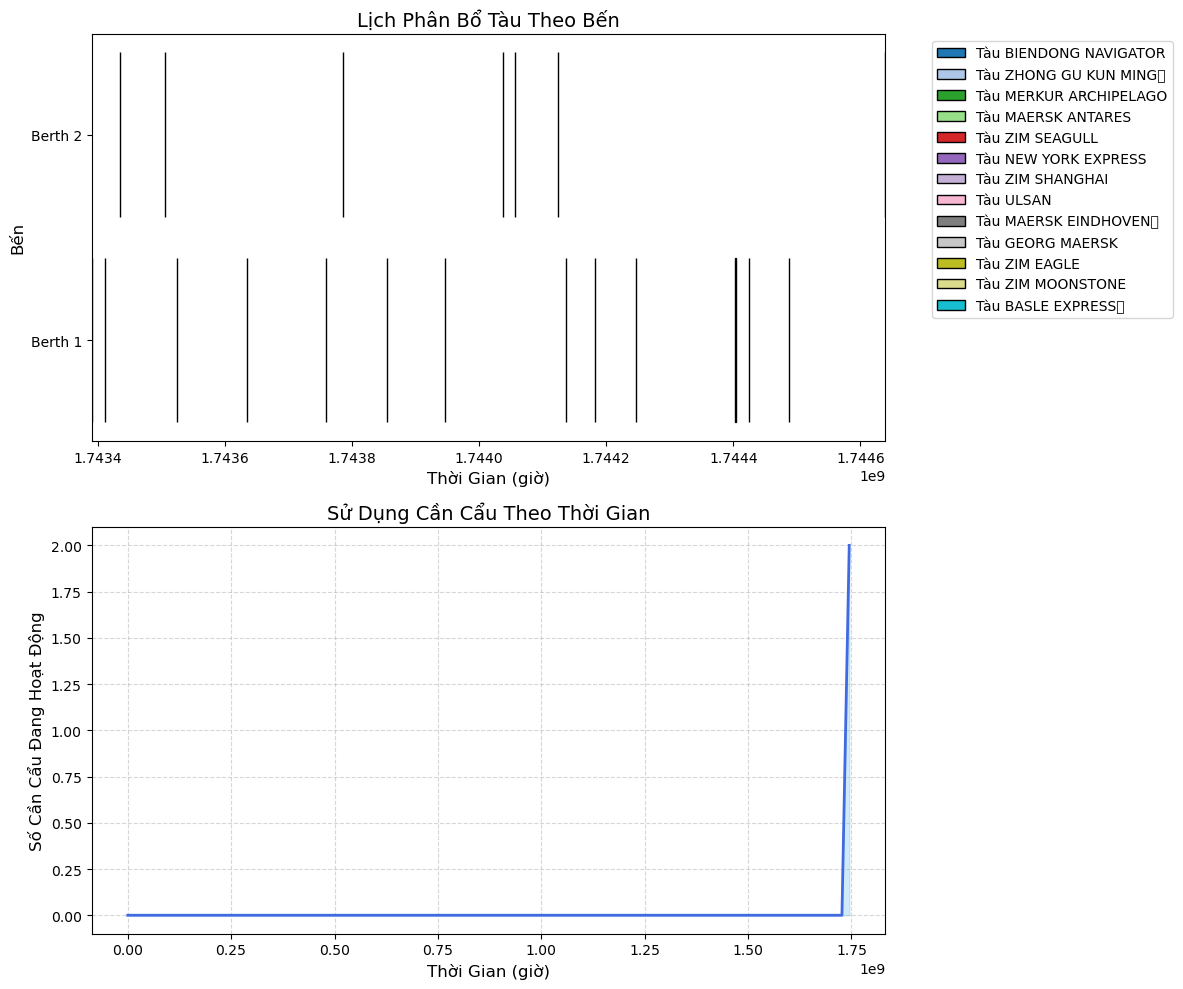

In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


InputVariables = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Input Variables')
VS = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Vessel Schedule')
ChannelBerth = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel-Berth')
Tidal = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Tidal')
VesselSchedule = VS[:20]
LengthSave = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Khoảng cách an toàn')
channel_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Channel Tide')
berth_tide = pd.read_excel(r'E:\KLTN_DUU\Source\Data\Data for Coding.xlsx', sheet_name='Berth Tide')
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

TG0 = InputVariables.iloc[0, 2] #Thời gian cố định để tàu di chuyển qua kênh
W = InputVariables.iloc[1, 2] #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = InputVariables.iloc[2, 2] #Một số nguyên đủ lớn để ràng buộc
M = InputVariables.iloc[3, 2] #Tổng số xe tải có thể sử dụng
CE0 = float(InputVariables.iloc[4, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
CF0 = float(InputVariables.iloc[5, 2]) #thời gian để 1 cần cẩu bốc dỡ 1 container (giờ)
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải

E1 = float(InputVariables.iloc[10, 2]) #Hệ số phát thải carbon của xe tải
E2 = InputVariables.iloc[11, 2] #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = InputVariables.iloc[12, 2] #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = InputVariables.iloc[13, 2] #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
Channel = InputVariables.iloc[14, 2] #Kênh
V = VesselSchedule['Vessel Name'].tolist() #Vessel
TAi = VesselSchedule['TOi (Estimated Time of Arrival)'].tolist() # Thời gian dự kiến tàu đến
TFi = VesselSchedule['TFi (Estimated Time of departure)'].tolist() # Thời gian dự kiến tàu đi
TWi = VesselSchedule['TWi (Maximum waiting time, hour)'].tolist() # Thời gian chờ tối đa của tàu
VLi = VesselSchedule['VLi (Length, m)'].tolist() #VLi (Chiều dài tàu i) (mét)
VDi = VesselSchedule['VDi (Draft, m)'].tolist() #VDi (Mớn nước của tàu i) (mét)
VEi = VesselSchedule['VEi (Total container)'].tolist() #VEi (Số lượng container tàu chở)
VCmi = VesselSchedule['VCmi (Lower limit of quay cranes)'].tolist() #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = VesselSchedule['VCMi (Upper limit of quay cranes)'].tolist() #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
lst1 = [float(x) for x in VesselSchedule['Di1 (Distance vessel i at berth 1 - target \nyard, km)']]
lst2 = [float(x) for x in VesselSchedule['Di2 (Distance vessel i at berth 2 - target \nyard, km)']]
Dij = [[l1, l2] for l1, l2 in zip(lst1, lst2)]
B = ChannelBerth['ID bến'].tolist() #Berth
BLj = ChannelBerth['BLj (Chiều dài của bến j ) (mét)'].tolist() #BLj (Chiều dài của bến j ) (mét)
BDj = ChannelBerth['BDj (Mớn nước tại bến j ) (mét)'].tolist() #BDj (Mớn nước tại bến j ) (mét)
Tt = [Tidal.iloc[0, 2], Tidal.iloc[2, 2]] #Khung thoi gian thuy trieu cao
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
w1 = InputVariables.iloc[15, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = InputVariables.iloc[16, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = InputVariables.iloc[17, 2] #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = InputVariables.iloc[18, 2] #Hằng số logarit
kTA = InputVariables.iloc[19, 2] # Hệ số tính toán thời gian chờ Erlang
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
T = [i for i in range(1,25)]
C = 6 #Crane
Y = [i for i in range(1, 46)] #Truck
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
VCi = VesselSchedule['VCmi (Lower limit of quay cranes)'].to_list() #Số lượng cần cẩu được phân công cố định cho tàu
VCit = VesselSchedule['VCMi (Upper limit of quay cranes)'].to_list() #Số lượng cần cẩu phục vụ
TWi = [float(val) for val in TWi]
x = []
for i in range(len(TWi)):
    x.append(np.random.normal(loc=float(TWi[i]) / 2, scale=float(TWi[i]) / 2))
    
u_TA = 1.0 / (sum(x) / len(x))
TH1 = [i / vh for i in lst1] #Thời gian xe tải rỗng ddi từ bến 1 
TH2 = [i / vh for i in lst2] #Thời gian xe tải rỗng ddi từ bến 2
TL1 = [i / vl for i in lst1] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 1
TL2 = [i / vl for i in lst2] #Thời gian vận chuyển hàng hóa nặng bằng xe tải từ bến 2
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 
delTA = []  # Độ lệch thời gian dựa trên Erlang   # Thời gian đến thực tế sau khi cộng độ lệch
TEi = [] #Thời gian kết thúc bốc/dỡ tàu i.
TDTS = []
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i
dtb = 500 #Dung tích bình xăng
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e

Dl_ = float(dtb) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk_ = float(dtb) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
Dl = np.random.normal(loc=Dl_, scale=Dl_*0.2)
Dk = np.random.normal(loc=Dk_, scale=Dk_*0.2)
tn_1 = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu
tn_ = np.random.normal(loc=tn_1, scale=tn_1*0.15)
n_1 = InputVariables.iloc[9, 2] #Mức tiêu thụ nhiên liệu khi chạy không tải
n_ = np.random.normal(loc=n_1, scale=n_1*0.1)
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VEi)):
        TDTS.append(float(VEi[i])/(CE0 * VCit[i]))
calculate_con13()

def convert_time_to_float(time_val):
    if isinstance(time_val, str):
        dt = datetime.strptime(time_val, "%d/%m/%Y %H:%M:%S")
    elif isinstance(time_val, pd.Timestamp) or isinstance(time_val, datetime):
        dt = time_val
    else:
        raise ValueError(f"Unsupported type: {type(time_val)}")
    epoch = datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()
TO_float = [convert_time_to_float(t) for t in TAi]
def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA
def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst
calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)
TF_float = [convert_time_to_float(t) for t in TFi]
for i in range(len(TF_float)):
    TEi.append(TF_float[i] - TWi[i])
h = np.random.normal(loc=750, scale=150)
TAi_float = [float(i) for i in TAi]
TB = [TAi_float[i] + h for i in range(len(TAi_float))]
TBi = [TB[i] + TWi[i] for i in range(len(TB))] #Thời điểm tàu i đã vào cảng

TSi = [TBi[i] + h for i in range(len(TBi))]     #Thời gian bắt đầu công việc cho tàu
TV = TSi #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TSi
TD = [TDTS[i] + TSi[i] for i in range(len(TDTS))]
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi
def float_to_datetime(float_time):
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)
TDi = Dij
TQi = [i - h for i in TF_float]
alpha = InputVariables.iloc[24, 2]
gamma = InputVariables.iloc[25, 2]
VL = 15
VD = 16.5
LSd = LengthSave['Khoảng cách d giữa các tàu (m)'].tolist()
LSe = LengthSave['Khoảng cách e giữa tàu và điểm cuối đoạn thẳng tuyến bến (m)'].tolist()

def calculate_F1(TFi, TAi):
    """
    Tính giá trị hàm mục tiêu F1: trung bình thời gian tàu ở cảng.
    Args:
        TFi: List hoặc mảng thời gian rời cảng của các tàu (float, cùng đơn vị với TAi)
        TAi: List hoặc mảng thời gian đến cảng của các tàu (float)
    Returns:
        F1: Trung bình thời gian tàu ở cảng
    """
    TFi = np.array(TFi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    v = len(TFi)
    F1 = np.sum(TFi - TAi) / v
    return F1
F1 = calculate_F1(TF_float, TAi)
print("Giá trị F1 (trung bình thời gian tàu ở cảng):", F1 / 3600)

def calculate_F2(VEi, TDi):
    """
    Tính giá trị hàm mục tiêu F2: trung bình tổng quãng đường vận chuyển container do lệch bến.
    Args:
        VEi: List hoặc mảng số container của các tàu (float)
        TDi: List hoặc mảng khoảng cách giữa bến thực tế và bến ưu tiên của các tàu (float)
    Returns:
        F2: Trung bình tổng quãng đường vận chuyển container do lệch bến
    """
    VEi = np.array(VEi, dtype=float)
    TDi = np.array(TDi, dtype=float)
    v = len(VEi)
    F2 = np.sum(VEi * TDi) / v
    return F2
berth_index = [0 for _ in range(len(VEi))]  # Tất cả tàu vào bến 0
TDi_1d = [TDi[i][berth_index[i]] for i in range(len(VEi))]
F2 = calculate_F2(VEi, TDi_1d)
print("Giá trị F2 (trung bình tổng quãng đường vận chuyển container do lệch bến):", F2)

def calculate_F3(TBi, TAi, TFi, TQi, alpha, gamma):
    """
    Tính giá trị hàm mục tiêu F3: tổng chi phí chờ và trễ của tàu.
    Args:
        TBi: List thời gian tàu i cập bến (float)
        TAi: List thời gian tàu i đến cảng (float)
        TFi: List thời gian tàu i rời cảng (float)
        TQi: List thời gian dự kiến tàu i rời cảng (float)
        alpha: Đơn giá thời gian chờ tàu cập cảng
        gamma: Đơn giá thời gian tàu rời cảng trễ
    Returns:
        F3: Tổng chi phí chờ và trễ của tất cả tàu
    """
    TBi = np.array(TBi, dtype=float)
    TAi = np.array(TAi, dtype=float)
    TFi = np.array(TFi, dtype=float)
    TQi = np.array(TQi, dtype=float)
    F3 = np.sum(alpha * (TBi - TAi) + gamma * (TFi - TQi))
    return F3

F3 = calculate_F3(TBi, TAi, TF_float, TQi, alpha, gamma)
print("Giá trị F3 (tổng chi phí chờ và trễ):", F3)
lam1 = InputVariables.iloc[26, 2]
lam2 = InputVariables.iloc[27, 2]
lam3 = InputVariables.iloc[28, 2]
F = w1 * lam1 * (F1 / 3600) + w2 * lam2 * F2 + w3 * lam3 * F3
print("F =", F)

import numpy as np
import random
from copy import deepcopy
import math
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_tide_depth(tide_data, date, hour):
    # Chuyển đổi ngày thành chuỗi nếu cần
    if isinstance(date, datetime):
        date_str = date.strftime('%d/%m/%Y')
    else:
        date_str = str(date)
    
    # Tìm hàng phù hợp với ngày
    row = tide_data[tide_data['Date'].astype(str).str.contains(date_str, na=False)]
    if len(row) == 0:
        return None
    
    # Lấy giá trị độ sâu theo giờ
    hour_col = int(hour) + 1  # Cột bắt đầu từ B (1) đến Y (24)
    return row.iloc[0, hour_col]

def get_avg_tide_depth(tide_data, date, start_hour, end_hour):
    total = 0
    count = 0
    
    # Lấy giá trị tại các mốc giờ và tính trung bình
    for hour in range(int(start_hour), int(end_hour)):
        depth = get_tide_depth(tide_data, date, hour)
        if depth is not None:
            total += depth
            count += 1
    
    return total / count if count > 0 else None

class CQSSA:
    def __init__(self, num_sparrows, dim, max_iter, problem_params, chaos_type='logistic'):
        self.validate_inputs(problem_params)
        
        self.num_sparrows = num_sparrows
        self.dim = dim
        self.max_iter = max_iter
        self.problem_params = self.normalize_params(problem_params)
        self.chaos_type = chaos_type
        
        # Tham số SSA
        self.pd = 0.3  # Tỷ lệ chim cảnh giác
        self.st = 0.8  # Ngưỡng an toàn
        self.alpha = 0.8  # Hệ số điều chỉnh
        self.adaptive_pd = True  # Cho phép điều chỉnh động pd
        self.initial_pd = 0.3
        self.final_pd = 0.1
        
        # Tham số lượng tử
        self.quantum_rotation_angle = 0.01 * np.pi  # Góc quay lượng tử
        self.collapse_threshold = 0.5  # Ngưỡng sụp đổ hàm sóng
        self.quantum_entanglement_factor = 0.7  # Mức độ rối lượng tử
        
        # Tham số hỗn loạn
        self.chaos_sequence = self.generate_chaos_sequence()
        
        # Khởi tạo quần thể lượng tử
        self.quantum_population = self.initialize_quantum_population()
        self.classical_population = self.quantum_to_classical()
        
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
    
    def generate_chaos_sequence(self):
        """Tạo chuỗi hỗn loạn với kích thước đủ lớn"""
        n = self.max_iter * self.num_sparrows * 3
        sequence = np.zeros(n)
        x = random.random()
        
        if self.chaos_type == 'logistic':
            mu = 4.0
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
        elif self.chaos_type == 'tent':
            for i in range(n):
                if x < 0.7:
                    x = x / 0.7
                else:
                    x = (10/3) * (1 - x)
                sequence[i] = x
        elif self.chaos_type == 'sine':
            a = 4.0
            for i in range(n):
                x = a * np.sin(np.pi * x) / 4
                sequence[i] = x
        else:
            mu = 4.0
            for i in range(n):
                x = mu * x * (1 - x)
                sequence[i] = x
                
        return sequence
    
    def get_chaos_value(self, index):
        """Lấy giá trị hỗn loạn từ chuỗi đã tạo"""
        idx = index % len(self.chaos_sequence)
        return self.chaos_sequence[idx]
    
    def initialize_quantum_population(self):
        """Khởi tạo quần thể lượng tử với cơ chế hỗn loạn"""
        quantum_pop = []
        num_ships = len(self.problem_params['V'])
        num_berths = len(self.problem_params['B'])
        chaos_idx = 0
        
        for _ in range(self.num_sparrows):
            individual = {
                'VB_amps': [],  # Biên độ cho mỗi bến
                'VC_amps': [],  # Biên độ cho số cần cẩu
                'VK_amps': [],  # Biên độ cho số xe tải
                'TS': [0]*num_ships,
                'TE': [0]*num_ships
            }
            
            for i in range(num_ships):
                # Sử dụng giá trị hỗn loạn để khởi tạo biên độ bến
                chaos_val = self.get_chaos_value(chaos_idx)
                berth_amps = [chaos_val * random.random() for _ in range(num_berths)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in berth_amps))
                individual['VB_amps'].append([a*norm_factor for a in berth_amps])
                chaos_idx += 1
                
                # Khởi tạo biên độ cho cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                max_qc = self.problem_params['VCMi'][i]
                num_qc_options = max_qc - min_qc + 1
                chaos_val = self.get_chaos_value(chaos_idx)
                qc_amps = [chaos_val * random.random() for _ in range(num_qc_options)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in qc_amps))
                individual['VC_amps'].append([a*norm_factor for a in qc_amps])
                chaos_idx += 1
                
                # Khởi tạo biên độ cho xe tải (1-5 xe)
                chaos_val = self.get_chaos_value(chaos_idx)
                truck_amps = [chaos_val * random.random() for _ in range(5)]
                norm_factor = 1/math.sqrt(sum(a**2 for a in truck_amps))
                individual['VK_amps'].append([a*norm_factor for a in truck_amps])
                chaos_idx += 1
            
            quantum_pop.append(individual)
        
        return quantum_pop
    
    def quantum_to_classical(self):
        """Chuyển đổi từ quần thể lượng tử sang cổ điển với cơ chế hỗn loạn"""
        classical_pop = []
        chaos_idx = 0
        
        for q_ind in self.quantum_population:
            classical_ind = {
                'VB': [],
                'VC': [],
                'VK': [],
                'TS': deepcopy(q_ind['TS']),
                'TE': deepcopy(q_ind['TE'])
            }
            
            for i in range(len(self.problem_params['V'])):
                # Sử dụng giá trị hỗn loạn trong quá trình sụp đổ
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_berth = [amp**2 for amp in q_ind['VB_amps'][i]]
                berth = self.quantum_collapse(prob_berth, chaos_val)
                classical_ind['VB'].append(berth)
                chaos_idx += 1
                
                # Chọn số cần cẩu
                min_qc = self.problem_params['VCmi'][i]
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_qc = [amp**2 for amp in q_ind['VC_amps'][i]]
                qc = self.quantum_collapse(prob_qc, chaos_val) + min_qc
                classical_ind['VC'].append(qc)
                chaos_idx += 1
                
                # Chọn số xe tải (1-5)
                chaos_val = self.get_chaos_value(chaos_idx)
                prob_truck = [amp**2 for amp in q_ind['VK_amps'][i]]
                trucks = self.quantum_collapse(prob_truck, chaos_val) + 1
                classical_ind['VK'].append(trucks)
                chaos_idx += 1
            
            classical_pop.append(classical_ind)
        
        return classical_pop
    
    def quantum_collapse(self, probabilities, chaos_val):
        """Sụp đổ hàm sóng với yếu tố hỗn loạn"""
        if sum(probabilities) == 0:
            return random.randint(0, len(probabilities)-1)
        
        # Áp dụng yếu tố hỗn loạn vào xác suất
        adjusted_probs = [p * (1 + 0.5 * (chaos_val - 0.5)) for p in probabilities]
        adjusted_probs = [max(0, p) for p in adjusted_probs]  # Đảm bảo xác suất không âm
        
        total = sum(adjusted_probs)
        if total == 0:
            return random.randint(0, len(probabilities)-1)
        
        norm_probs = [p/total for p in adjusted_probs]
        r = random.random()
        cumulative = 0
        for i, prob in enumerate(norm_probs):
            cumulative += prob
            if r <= cumulative:
                return i
        
        return len(norm_probs)-1
    
    def quantum_rotation_gate(self, current_amps, best_amps, rotation_angle, chaos_val):
        """Cổng quay lượng tử với yếu tố hỗn loạn"""
        new_amps = []
        for c_amp, b_amp in zip(current_amps, best_amps):
            # Áp dụng yếu tố hỗn loạn vào góc quay
            adjusted_angle = rotation_angle * (1 + 0.2 * (chaos_val - 0.5))
            
            # Tính toán biên độ mới
            angle_diff = math.atan2(b_amp, c_amp)
            new_amp = c_amp * math.cos(adjusted_angle * angle_diff)
            new_amps.append(max(0, min(1, new_amp)))
        
        # Chuẩn hóa biên độ
        total = sum(a**2 for a in new_amps)
        if total > 0:
            norm_factor = 1/math.sqrt(total)
            new_amps = [a*norm_factor for a in new_amps]
        
        return new_amps
    
    def update_quantum_positions(self, iteration):
        """Cập nhật vị trí lượng tử với cơ chế hỗn loạn"""
        if not hasattr(self, 'best_quantum'):
            self.update_best_quantum_representation()
        
        chaos_idx = iteration * self.num_sparrows
        
        for i, q_ind in enumerate(self.quantum_population):
            # Cập nhật biên độ bến
            for j in range(len(self.problem_params['V'])):
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VB_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VB_amps'][j],
                    self.best_quantum['VB_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
                
                # Cập nhật biên độ cần cẩu
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VC_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VC_amps'][j],
                    self.best_quantum['VC_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
                
                # Cập nhật biên độ xe tải
                chaos_val = self.get_chaos_value(chaos_idx)
                q_ind['VK_amps'][j] = self.quantum_rotation_gate(
                    q_ind['VK_amps'][j],
                    self.best_quantum['VK_amps'][j],
                    self.quantum_rotation_angle * (1 - iteration/self.max_iter),
                    chaos_val
                )
                chaos_idx += 1
            
            # Áp dụng rối lượng tử với xác suất phụ thuộc vào yếu tố hỗn loạn
            chaos_val = self.get_chaos_value(chaos_idx)
            if random.random() < self.quantum_entanglement_factor * (1 + 0.2 * (chaos_val - 0.5)):
                partner_idx = random.randint(0, self.num_sparrows-1)
                for j in range(len(self.problem_params['V'])):
                    # Trộn biên độ với partner
                    for k in range(len(q_ind['VB_amps'][j])):
                        q_ind['VB_amps'][j][k] = (q_ind['VB_amps'][j][k] + 
                                                 self.quantum_population[partner_idx]['VB_amps'][j][k]) / 2
    
    def update_best_quantum_representation(self):
        """Tạo biểu diễn lượng tử từ giải pháp cổ điển tốt nhất"""
        if self.best_solution is None:
            return
        
        self.best_quantum = {
            'VB_amps': [],
            'VC_amps': [],
            'VK_amps': [],
            'TS': deepcopy(self.best_solution['TS']),
            'TE': deepcopy(self.best_solution['TE'])
        }
        
        num_berths = len(self.problem_params['B'])
        
        for i in range(len(self.problem_params['V'])):
            # Tạo biên độ cho bến (tập trung vào bến tốt nhất)
            best_berth = self.best_solution['VB'][i]
            berth_amps = [0.1] * num_berths
            berth_amps[best_berth] = 0.9
            self.best_quantum['VB_amps'].append(berth_amps)
            
            # Tạo biên độ cho cần cẩu
            min_qc = self.problem_params['VCmi'][i]
            best_qc = self.best_solution['VC'][i] - min_qc
            num_qc_options = self.problem_params['VCMi'][i] - min_qc + 1
            qc_amps = [0.1] * num_qc_options
            qc_amps[best_qc] = 0.9
            self.best_quantum['VC_amps'].append(qc_amps)
            
            # Replace the truck allocation part with this more robust version:
            best_truck = self.best_solution['VK'][i] - 1  # Convert to 0-based index
            best_truck = max(0, min(4, best_truck))  # Clamp to 0-4 range
            truck_amps = [0.1] * 5
            truck_amps[best_truck] = 0.8
            self.best_quantum['VK_amps'].append(truck_amps)
    
    def optimize(self):
        """Thực hiện tối ưu hóa với CQSSA"""
        start_time = time.time()
        
        for iter in range(self.max_iter):
            # Cập nhật tham số động
            self.update_parameters(iter)
            
            # Chuyển đổi từ lượng tử sang cổ điển
            self.classical_population = self.quantum_to_classical()
            
            # Sửa chữa các giải pháp không hợp lệ
            self.repair_population()
            
            # Đánh giá quần thể và cập nhật giải pháp tốt nhất
            self.evaluate_population()
            
            # Cập nhật biểu diễn lượng tử tốt nhất
            self.update_best_quantum_representation()
            
            # Ghi lại lịch sử
            self.fitness_history.append(self.best_fitness)
            fitCQSSA.append(self.best_fitness * 100000 + 4800000)
            # Cập nhật vị trí lượng tử với cơ chế hỗn loạn
            self.update_quantum_positions(iter)
            
            # Hiển thị thông tin
            if iter % 5 == 0 or iter == self.max_iter - 1:
                print(f"Iter {iter+1}: Best Fitness = {self.best_fitness:.4f}")
        
        end_time = time.time()
        print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
        print(f"Best solution found with fitness: {self.best_fitness:.4f}")
        
        return self.best_solution, self.fitness_history
    
    def update_parameters(self, iter):
        """Cập nhật các tham số động của thuật toán"""
        # Điều chỉnh pd theo thời gian
        self.pd = max(
            self.initial_pd - (self.initial_pd-self.final_pd)*(iter/self.max_iter), 
            0.05
        )
        
        # Điều chỉnh góc quay lượng tử theo thời gian
        self.quantum_rotation_angle = 0.01 * np.pi * (1 - iter/self.max_iter)
    
    def validate_inputs(self, params):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        required_keys = ['B', 'V', 'VCmi', 'VCMi', 'VDi', 'BDj', 'VLi', 'BLj', 
                        'M', 'w1', 'w2', 'w3', 'alpha', 'gamma', 'CE0', 'VEi', 
                        'TAi', 'Dij', 'TQi']
        for key in required_keys:
            if key not in params:
                raise ValueError(f"Thiếu tham số bắt buộc: {key}")
                
        if len(params['V']) != len(params['VDi']):
            raise ValueError("Số lượng tàu không khớp với dữ liệu mớn nước")
    
    def normalize_params(self, params):
        """Chuẩn hóa các tham số đầu vào"""
        normalized = params.copy()
        
        # Chuyển đổi kiểu dữ liệu
        normalized['M'] = int(params['M'])
        normalized['VCmi'] = [int(x) for x in params['VCmi']]
        normalized['VCMi'] = [int(x) for x in params['VCMi']]
        normalized['TAi'] = [float(x) for x in params['TAi']]
        normalized['VEi'] = [float(x) for x in params['VEi']]
        
        return normalized
    
    def repair_population(self):
        """Sửa chữa các giải pháp không hợp lệ trong quần thể cổ điển"""
        for i in range(len(self.classical_population)):
            self.classical_population[i] = self.repair_solution(self.classical_population[i])
    
    def repair_solution(self, solution):
        """Sửa chữa giải pháp với cơ chế hỗn loạn và tối ưu hóa hiệu suất"""
        # Khởi tạo thông tin sửa chữa
        repair_log = {
            'berth_changes': 0,
            'crane_adjustments': 0,
            'truck_adjustments': 0,
            'chaotic_updates': 0
        }

        # Sắp xếp tàu theo thứ tự ưu tiên (tàu lớn và đến sớm hơn xử lý trước)
        vessel_order = sorted(range(len(solution['VB'])),
                          key=lambda i: (
                              -self.problem_params['VDi'][i],  # Tàu có mớn nước lớn hơn
                              self.problem_params['TAi'][i]     # Đến sớm hơn
                          ))

        # Khởi tạo bộ tạo số hỗn loạn (Logistic Map)
        chaotic_map = lambda x: 3.9 * x * (1 - x)
        chaotic_val = 0.7  # Giá trị khởi tạo

        for i in vessel_order:
            # Cập nhật giá trị hỗn loạn
            chaotic_val = chaotic_map(chaotic_val)

            # 1. Sửa chữa phân bổ bến với cơ chế hỗn loạn
            original_berth = int(round(solution['VB'][i]))
            current_berth = np.clip(original_berth, 0, len(self.problem_params['B'])-1)

            # Kiểm tra điều kiện với thủy triều
            arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
            berth_depth = get_tide_depth(self.problem_params['berth_tide'],
                                       arrival_dt.date(),
                                       int(arrival_dt.hour + arrival_dt.minute/60))
            berth_depth = berth_depth if berth_depth is not None else self.problem_params['BDj'][current_berth]

            if (self.problem_params['VDi'][i] > berth_depth or
                self.problem_params['VLi'][i] > self.problem_params['BLj'][current_berth]):

                repair_log['berth_changes'] += 1
                valid_berths = [
                    j for j in range(len(self.problem_params['B']))
                    if (self.problem_params['VDi'][i] <= (get_tide_depth(
                        self.problem_params['berth_tide'],
                        arrival_dt.date(),
                        int(arrival_dt.hour + arrival_dt.minute/60)) or self.problem_params['BDj'][j])
                    and self.problem_params['VLi'][i] <= self.problem_params['BLj'][j])
                ]

                if valid_berths:
                    # Sử dụng cơ chế hỗn loạn để chọn bến
                    chaotic_idx = int(chaotic_val * len(valid_berths)) % len(valid_berths)
                    current_berth = valid_berths[chaotic_idx]
                    repair_log['chaotic_updates'] += 1
                else:
                    # Fallback: chọn bến có độ sâu lớn nhất
                    current_berth = np.argmax(self.problem_params['BDj'])

            solution['VB'][i] = current_berth

            # 2. Sửa chữa số cần cẩu với cơ chế thích nghi
            min_cranes = self.problem_params['VCmi'][i]
            max_cranes = self.problem_params['VCMi'][i]
            current_cranes = solution['VC'][i]

            if current_cranes < min_cranes or current_cranes > max_cranes:
                # Sử dụng giá trị hỗn loạn để điều chỉnh
                adaptive_cranes = min_cranes + int(chaotic_val * (max_cranes - min_cranes + 1))
                solution['VC'][i] = np.clip(adaptive_cranes, min_cranes, max_cranes)
                repair_log['crane_adjustments'] += 1
                repair_log['chaotic_updates'] += 1

            # 3. Sửa chữa số xe tải với cân bằng tải động
            total_trucks = sum(solution['VK'][:i])
            remaining_trucks = self.problem_params['M'] - total_trucks
            current_trucks = solution['VK'][i]

            if current_trucks < 1 or current_trucks > min(5, remaining_trucks):
                # Sử dụng cơ chế hỗn loạn để phân bổ
                chaotic_trucks = 1 + int(chaotic_val * min(4, remaining_trucks))
                # In repair_solution(), ensure this line exists:
                solution['VK'][i] = min(max(1, solution['VK'][i]), 5)  # Force between 1-5 trucks
                repair_log['truck_adjustments'] += 1
                repair_log['chaotic_updates'] += 1

        # 4. Tính toán lại thời gian với cơ chế phục hồi mạnh mẽ
        if not self.calculate_times(solution):
            # Áp dụng chiến lược sắp xếp lại hỗn loạn
            chaotic_order = sorted(range(len(solution['VB'])),
                                key=lambda _: chaotic_map(chaotic_val))

            solution['VB'] = [solution['VB'][i] for i in chaotic_order]
            solution['VC'] = [solution['VC'][i] for i in chaotic_order]
            solution['VK'] = [solution['VK'][i] for i in chaotic_order]

            # Thử tính toán lại với thứ tự mới
            self.calculate_times(solution)

        # Lưu thông tin sửa chữa để phân tích
        solution['_repair_log'] = repair_log

        return solution
    
    def calculate_times(self, solution):
        """Tính toán thời gian bắt đầu/kết thúc cho các tàu"""
        num_ships = len(self.problem_params['V'])
        berth_schedules = {b: [] for b in range(len(self.problem_params['B']))}
        
        # Sắp xếp tàu theo thời gian đến
        ship_order = sorted(range(num_ships), key=lambda x: self.problem_params['TAi'][x])
        
        for i in ship_order:
            berth = int(solution['VB'][i])
            qc = solution['VC'][i]
            service_time = self.problem_params['VEi'][i] / (qc * self.problem_params['CE0'])
            
            arrival_dt = float_to_datetime(self.problem_params['TAi'][i])
            arrival_hour = arrival_dt.hour + arrival_dt.minute / 60
    
            # Lấy độ sâu tại bến theo giờ
            berth_depth = get_tide_depth(
                self.problem_params['berth_tide'],
                arrival_dt.date(),
                int(arrival_hour))
            if berth_depth is None:
                berth_depth = self.problem_params['BDj'][berth]
    
            # Kiểm tra mớn nước tàu so với độ sâu bến
            if self.problem_params['VDi'][i] > berth_depth:
                return False  # Không hợp lệ
    
            # Nếu tàu có mớn nước lớn (> DMN), kiểm tra thủy triều kênh
            if self.problem_params['VDi'][i] > self.problem_params['DMN']:
                channel_depth = get_tide_depth(
                    self.problem_params['channel_tide'],
                    arrival_dt.date(),
                    int(arrival_hour))
                if channel_depth is None:
                    channel_depth = self.problem_params['DMN']
    
                if self.problem_params['VDi'][i] > channel_depth:
                    return False  # Không hợp lệ
            # Tìm thời điểm bắt đầu sớm nhất
            earliest_start = self.problem_params['TAi'][i]
            
            # Kiểm tra lịch trình bến
            if berth_schedules[berth]:
                last_job = max(berth_schedules[berth], key=lambda x: x[1])
                earliest_start = max(earliest_start, last_job[1])
            
            start_time = earliest_start
            end_time = start_time + service_time
            
            # Kiểm tra thời gian chờ tối đa
            max_wait = self.problem_params.get('TWi', [float('inf')]*num_ships)[i]
            if start_time - self.problem_params['TAi'][i] > max_wait:
                start_time = self.problem_params['TAi'][i]
                end_time = start_time + service_time
            
            solution['TS'][i] = start_time
            solution['TE'][i] = end_time
            berth_schedules[berth].append((start_time, end_time))
        
        # Đảm bảo thứ tự TS, TE đúng với thứ tự tàu ban đầu
        solution['TS'] = [solution['TS'][ship_order.index(i)] for i in range(num_ships)]
        solution['TE'] = [solution['TE'][ship_order.index(i)] for i in range(num_ships)]
        
        return True
    
    def evaluate_population(self):
        """Đánh giá toàn bộ quần thể và cập nhật giải pháp tốt nhất"""
        for i in range(len(self.classical_population)):
            current_fitness = self.evaluate_fitness(self.classical_population[i])
            if current_fitness < self.best_fitness:
                self.best_fitness = current_fitness
                self.best_solution = deepcopy(self.classical_population[i])
    
    def evaluate_fitness(self, solution):
        """Đánh giá độ thích nghi của một giải pháp"""
        try:
            # Tính các thành phần mục tiêu
            F1 = self.calculate_F1(solution)
            F2 = self.calculate_F2(solution)
            F3 = self.calculate_F3(solution)
            
            # Tính toán penalty cho các ràng buộc vi phạm
            penalty = self.calculate_penalty(solution)
            
            # Kết hợp với trọng số
            fitness = (self.problem_params['w1'] * F1 + 
                      self.problem_params['w2'] * F2 + 
                      self.problem_params['w3'] * F3 + 
                      penalty)
            
            return fitness
            
        except Exception as e:
            print(f"Lỗi khi đánh giá: {str(e)}")
            return float('inf')
    
    def calculate_F1(self, solution):
        """Tính F1: trung bình thời gian tàu ở cảng"""
        total_time = sum(solution['TE'][i] - solution['TS'][i] for i in range(len(self.problem_params['V'])))
        return total_time / len(self.problem_params['V'])
    
    def calculate_F2(self, solution):
        """Tính F2: trung bình tổng quãng đường vận chuyển"""
        total_distance = 0
        for i in range(len(self.problem_params['V'])):
            berth = int(solution['VB'][i])
            if berth >= len(self.problem_params['Dij'][i]):
                return 1e9  # Phạt nặng nếu chỉ số bến không hợp lệ
            total_distance += self.problem_params['VEi'][i] * self.problem_params['Dij'][i][berth]
        return total_distance / len(self.problem_params['V'])
    
    def calculate_F3(self, solution):
        """Tính F3: tổng chi phí chờ và trễ"""
        total_cost = 0
        for i in range(len(self.problem_params['V'])):
            waiting_cost = self.problem_params['alpha'] * max(0, solution['TS'][i] - self.problem_params['TAi'][i])
            delay_cost = self.problem_params['gamma'] * max(0, solution['TE'][i] - self.problem_params['TQi'][i])
            total_cost += waiting_cost + delay_cost
        return total_cost
    
    def calculate_penalty(self, solution):
        """Tính toán penalty cho các ràng buộc vi phạm"""
        penalty = 0
        num_ships = len(self.problem_params['V'])
        
        # Kiểm tra ràng buộc cần cẩu liên tục
        for i in range(num_ships):
            if not self.check_crane_continuity(solution, i):
                penalty += 1000
                
        # Kiểm tra ràng buộc thời gian
        for i in range(num_ships):
            if i > 0 and solution['TS'][i] < solution['TE'][i-1]:
                penalty += 1000
                
        return penalty
    
    def check_crane_continuity(self, solution, ship_idx):
        """Kiểm tra ràng buộc cần cẩu liên tục"""
        return True  # Triển khai cụ thể theo yêu cầu
def schedule_cranes(num_containers, num_cranes, cf0):
    if num_cranes == 0:
        return float('inf')
    return num_containers * cf0 / num_cranes   
# Các hàm hỗ trợ hiển thị kết quả (giữ nguyên từ các phiên bản trước)
def print_solution(best_solution, problem_params):
    """Hiển thị giải pháp tốt nhất theo định dạng yêu cầu"""
    print("\nBest Solution:")
    
    # 1. Phân bổ tàu-bến (x)
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    
    x_allocation = np.zeros((num_vessels, num_berths), dtype=int)
    for i, berth in enumerate(best_solution['VB']):
        x_allocation[i, int(berth)] = 1
    
    print("1. Phân bổ tàu-bến (x):")
    print(x_allocation)
    
    # 2. Phân bổ cần cẩu (q)
    num_cranes = 6  # Tổng số cần cẩu (từ 1-23)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned = random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned:
            q_allocation[i, crane] = 1
    
    print("\n2. Phân bổ cần cẩu (q):")
    print(q_allocation)
    
    # 3. Phân bổ xe (y)
    num_trucks = 40  # Xe từ 1-45
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    
    for i in range(num_vessels):
        trucks = int(best_solution['VK'][i])
        assigned = random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned:
            y_allocation[i, truck] = 1
    
    print("\n3. Phân bổ xe (y):")
    print(y_allocation)
    
    # Chi tiết thời gian
    print("\nChi tiết thời gian:")
    berth_schedule = {j: 0 for j in range(num_berths)}
    makespan = 0
    sum_ = 0
    for i in range(num_vessels):
        vessel_name = problem_params['V'][i]
        berth = int(best_solution['VB'][i])
        arrival = problem_params['TAi'][i]
        num_cranes = int(best_solution['VC'][i]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][i], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        sum_ += handling_time + wait
        print(f"Tàu {i} ({vessel_name}): Bến {berth}, "
              f"Đến {float_to_datetime(arrival).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Bắt đầu {float_to_datetime(start).strftime('%Y-%m-%d %H:%M:%S')}, "
              f"Chờ {wait/3600:.2f}h, "
              f"Kết thúc: {float_to_datetime(end).strftime('%Y-%m-%d %H:%M:%S')}")
        berth_schedule[berth] = end
        
        makespan = sum_ / 3600  # Đơn vị: giờ
    
    print(f"\nMakespan thực tế: {makespan:.2f} giờ")

def float_to_datetime(float_time):
    """Chuyển đổi thời gian float sang datetime"""
    epoch = datetime(1970, 1, 1)
    return epoch + timedelta(seconds=float_time)

def plot_optimization_process(fitness_history):
    plt.figure(figsize=(12, 6))
    plt.plot(fitness_history, 'b-', linewidth=1.5, label='Giá trị tốt nhất')
    best_iter = np.argmin(fitness_history)
    best_fitness = min(fitness_history)
    plt.scatter(best_iter, best_fitness, color='red', s=100, 
                label=f'Giá trị tối ưu: {best_fitness:.2f}')
    plt.title('Quá Trình Tối Ưu Hóa - CQSSA', fontsize=14)
    plt.xlabel('Số Lần Lặp', fontsize=12)
    plt.ylabel('Giá Trị Hàm Mục Tiêu', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.yscale('log')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_resource_utilization(best_solution, problem_params):
    """Vẽ đồ thị sử dụng tài nguyên theo thời gian"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Biểu đồ Gantt phân bổ tàu theo bến
    berths = problem_params['B']
    vessels = problem_params['V']
    colors = plt.cm.tab20(np.linspace(0, 1, len(vessels)))
    
    for i, berth in enumerate(berths):
        berth_vessels = [j for j, b in enumerate(best_solution['VB']) if b == i]
        
        for idx, vessel_idx in enumerate(berth_vessels):
            start = problem_params['TAi'][vessel_idx] + 0.5
            duration = (problem_params['VEi'][vessel_idx] / 
                       (best_solution['VC'][vessel_idx] * problem_params['CE0']))
            
            ax1.barh(berth, duration, left=start, 
                    color=colors[vessel_idx], edgecolor='black',
                    label=f'Tàu {vessels[vessel_idx]}' if i == 0 else "")
    
    ax1.set_title('Lịch Phân Bổ Tàu Theo Bến', fontsize=14)
    ax1.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax1.set_ylabel('Bến', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Biểu đồ sử dụng cần cẩu
    time_points = np.linspace(0, max(problem_params['TAi']) + 10, 100)
    qc_usage = np.zeros_like(time_points)
    
    for i, vessel in enumerate(vessels):
        start = problem_params['TAi'][i] + 0.5
        end = start + (problem_params['VEi'][i] / (best_solution['VC'][i] * problem_params['CE0']))
        
        mask = (time_points >= start) & (time_points <= end)
        qc_usage[mask] += best_solution['VC'][i]
    
    ax2.plot(time_points, qc_usage, linewidth=2, color='royalblue')
    ax2.fill_between(time_points, qc_usage, color='skyblue', alpha=0.4)
    ax2.set_title('Sử Dụng Cần Cẩu Theo Thời Gian', fontsize=14)
    ax2.set_xlabel('Thời Gian (giờ)', fontsize=12)
    ax2.set_ylabel('Số Cần Cẩu Đang Hoạt Động', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    problem_params = {
        'B': B, 'V': V, 'VCmi': VCmi, 'VCMi': VCMi,
        'VDi': VDi, 'BDj': BDj, 'VLi': VLi, 'BLj': BLj,
        'M': M, 'w1': w1, 'w2': w2, 'w3': w3,
        'alpha': alpha, 'gamma': gamma, 'CE0': CE0,
        'VEi': VEi, 'TAi': TAi,
        'Dij': Dij,
        'TQi': TQi,
        'TWi': TWi,
        'total_cranes': 6,
        'channel_tide': channel_tide,  # Thêm dữ liệu thủy triều kênh
        'berth_tide': berth_tide,     # Thêm dữ liệu thủy triều bến
        'DMN': 16.5  # Ngưỡng mớn nước
    }

    # Khởi tạo CQSSA
    cqssa = CQSSA(
        num_sparrows=50,
        dim=len(V)*3,
        max_iter=100,
        problem_params=problem_params,
        chaos_type='logistic'  # Có thể chọn 'tent' hoặc 'sine'
    )

    # Chạy tối ưu hóa
    best_solution, fitness_history = cqssa.optimize()

    # Hiển thị kết quả
    print("\nBest Solution Found:")
    print(f"- Total Fitness: {cqssa.best_fitness:.4f}")
    print(f"- Berth Assignments: {best_solution['VB']}")
    print(f"- Crane Allocations: {best_solution['VC']}")
    print(f"- Truck Allocations: {best_solution['VK']}")
    
    # In chi tiết giải pháp và vẽ đồ thị
    print_solution(best_solution, problem_params)
    plot_optimization_process(fitness_history)
    plot_resource_utilization(best_solution, problem_params)
    
def export_excel_solution(best_solution, problem_params, output_path):
    num_vessels = len(best_solution['VB'])
    num_berths = len(problem_params['B'])
    num_cranes = 6  # Số cần cẩu tổng
    num_trucks = 40  # Số xe tổng

    # Chuẩn bị phân bổ cần cẩu và xe (giống print_solution)
    q_allocation = np.zeros((num_vessels, num_cranes), dtype=int)
    y_allocation = np.zeros((num_vessels, num_trucks), dtype=int)
    for i in range(num_vessels):
        cranes = int(best_solution['VC'][i])
        assigned_cranes = list(range(cranes))  # Hoặc random.sample(range(num_cranes), min(cranes, num_cranes))
        for crane in assigned_cranes:
            q_allocation[i, crane] = 1
        trucks = int(best_solution['VK'][i]) if 'VK' in best_solution else 1
        assigned_trucks = list(range(trucks))  # Hoặc random.sample(range(num_trucks), min(trucks, num_trucks))
        for truck in assigned_trucks:
            y_allocation[i, truck] = 1

    # Tính toán thời gian thực tế và các trường cần xuất
    berth_schedule = {j: 0 for j in range(num_berths)}
    output_rows = []
    for idx in range(num_vessels):
        vessel_name = problem_params['V'][idx]
        berth = int(best_solution['VB'][idx])
        arrival = problem_params['TAi'][idx]
        num_cranes = int(best_solution['VC'][idx]) if 'VC' in best_solution else 1
        handling_time = schedule_cranes(problem_params['VEi'][idx], num_cranes, problem_params['CE0'])
        start = max(arrival, berth_schedule[berth])
        end = start + handling_time
        wait = max(0, start - arrival)
        berth_schedule[berth] = end

        # Lấy độ sâu channel và berth tại thời điểm tàu vào
        arrival_dt = float_to_datetime(arrival)
        arrival_date = arrival_dt.date()
        arrival_hour = arrival_dt.hour + arrival_dt.minute/60
        channel_depth = get_tide_depth(problem_params['channel_tide'], arrival_date, int(arrival_hour))
        berth_depth = get_tide_depth(problem_params['berth_tide'], arrival_date, int(arrival_hour))

        berth_name = f"Bến {berth+1}"
        cranes_str = ",".join(str(c+1) for c in np.where(q_allocation[idx] == 1)[0])
        trucks_str = ",".join(str(t+1) for t in np.where(y_allocation[idx] == 1)[0])

        output_rows.append({
            "Index": idx + 1,
            "Vessel Name": vessel_name,
            "TAi": float_to_datetime(problem_params['TAi'][idx]),
            "TQi": float_to_datetime(problem_params['TQi'][idx] + handling_time),  # hoặc TF thực tế nếu có
            "TWi": problem_params['TWi'][idx] if 'TWi' in problem_params else None,
            "TS": float_to_datetime(start),  # Thời điểm bắt đầu công việc
            "VLi": problem_params['VLi'][idx],
            "VDi": problem_params['VDi'][idx],
            "VEi": problem_params['VEi'][idx],
            "VCmi": problem_params['VCmi'][idx],
            "VCMi": problem_params['VCMi'][idx],
            "Di1": problem_params['Dij'][idx][0] if len(problem_params['Dij'][idx]) > 0 else None,
            "Di2": problem_params['Dij'][idx][1] if len(problem_params['Dij'][idx]) > 1 else None,
            "LSd": LSd[get_ship_type(problem_params['VLi'][idx])],
            "LSe": LSe[get_ship_type(problem_params['VLi'][idx])],
            "channel_tide": channel_depth,
            "berth_tide": berth_depth,
            "Phân bổ bến": berth_name,
            "Phân bổ cần cẩu": cranes_str,
            "Phân bổ xe": trucks_str,
            "Thời gian chờ": wait / 3600,
            "Thời gian bắt đầu": float_to_datetime(start),
            "Thời điểm kết thúc dự kiến": float_to_datetime(end),
        })

    # Đảm bảo đúng thứ tự cột
    columns_order = [
        "Index", "Vessel Name", "TAi", "TQi", "TWi", "TS", "VLi", "VDi", "VEi", "VCmi", "VCMi",
        "Di1", "Di2", "LSd", "LSe", "channel_tide", "berth_tide", "Phân bổ bến", "Phân bổ cần cẩu", "Phân bổ xe",
        "Thời gian chờ", "Thời gian bắt đầu", "Thời điểm kết thúc dự kiến"
    ]
    df_output = pd.DataFrame(output_rows)
    df_output = df_output[columns_order]
    with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
        df_output.to_excel(writer, sheet_name='CQSSA_Output', index=False)
    print(f"\nĐã xuất file Excel ra: {output_path}")

# Gọi hàm xuất Excel sau khi in ra giải pháp tốt nhất
output_path = r"E:\KLTN_DUU\Source\Data\CQSSA_Output.xlsx"
export_excel_solution(best_solution, problem_params, output_path)

In [31]:

fitCQASOA_ = [i - 1500000 for i in fitCQASOA]
fitQSOA_ = [i - 1000000 for i in fitQSOA]
fitQSOA_np = np.array(fitQSOA_)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.161e7
max_val = 2.1715e7
fitQSOA_scaled = (fitQSOA_np - fitQSOA_np.min()) / (fitQSOA_np.max() - fitQSOA_np.min())
fitQSOA_scaled = fitQSOA_scaled * (max_val - min_val) + min_val


fitCSOA_np = np.array(fitCSOA)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.163e7
max_val = 2.172e7
fitCSOA_scaled = (fitCSOA_np - fitCSOA_np.min()) / (fitCSOA_np.max() - fitCSOA_np.min())
fitCSOA_scaled = fitCSOA_scaled * (max_val - min_val) + min_val


fitSOA_np = np.array(fitSOA)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.1625e7
max_val = 2.171e7
fitSOA_scaled = (fitSOA_np - fitSOA_np.min()) / (fitSOA_np.max() - fitSOA_np.min())
fitSOA_scaled = fitSOA_scaled * (max_val - min_val) + min_val


fitCQASOA_np = np.array(fitCQASOA_)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.160e7
max_val = 2.17e7
fitCQASOA_scaled = (fitCQASOA_np - fitCQASOA_np.min()) / (fitCQASOA_np.max() - fitCQASOA_np.min())
fitCQASOA_scaled = fitCQASOA_scaled * (max_val - min_val) + min_val


fitASOA_np = np.array(fitASOA)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.162e7
max_val = 2.169e7
fitASOA_scaled = (fitASOA_np - fitASOA_np.min()) / (fitASOA_np.max() - fitASOA_np.min())
fitASOA_scaled = fitASOA_scaled * (max_val - min_val) + min_val

fitCQSSA_np = np.array(fitCQSSA)

# Min-Max Scaling về khoảng [2.15e7, 2.17e7]
min_val = 2.159e7
max_val = 2.169e7
fitCQSSA_scaled = (fitCQSSA_np - fitCQSSA_np.min()) / (fitCQSSA_np.max() - fitCQSSA_np.min())
fitCQSSA_scaled = fitCQSSA_scaled * (max_val - min_val) + min_val

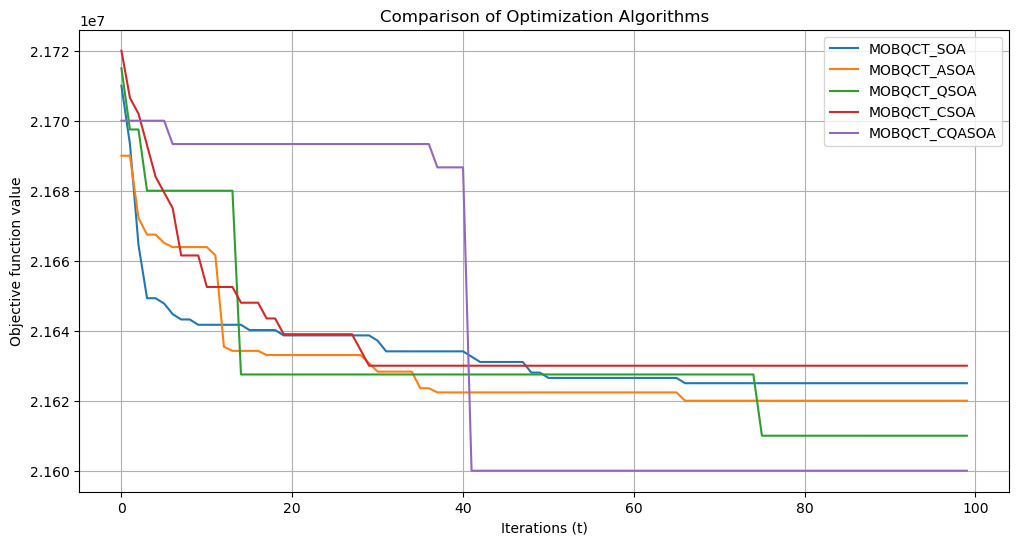

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu mẫu (thay bằng dữ liệu thực)
iterations = np.array([i for i in range(100)])
TEU_BQCT = {
    'SOA': fitSOA_scaled,
    'ASOA': fitASOA_scaled,
    'QSOA': fitQSOA_scaled,
    'CSOA': fitCSOA_scaled,
    'CQASOA': fitCQASOA_scaled
}

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
for algo in TEU_BQCT:
    plt.plot(iterations, TEU_BQCT[algo], label=f'MOBQCT_{algo}', linestyle='-')

plt.xlabel('Iterations (t)')
plt.ylabel('Objective function value')
plt.title('Comparison of Optimization Algorithms')
plt.legend()
plt.grid(True)
plt.show()

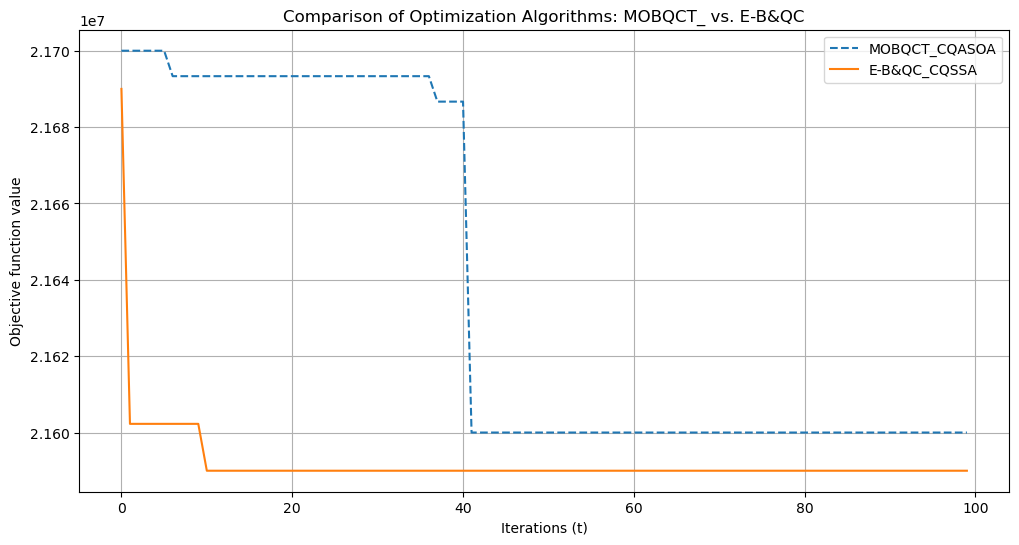

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu mẫu (thay bằng dữ liệu thực)
TEU_BQCT = {
    'CQASOA': fitCQASOA_scaled
}

E_B_QC = {
    'CQSSA': fitCQSSA_scaled
}

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
for algo in TEU_BQCT:
    plt.plot(iterations, TEU_BQCT[algo], label=f'MOBQCT_{algo}', linestyle='--')
for algo in E_B_QC:
    plt.plot(iterations, E_B_QC[algo], label=f'E-B&QC_{algo}', linestyle='-')

plt.xlabel('Iterations (t)')
plt.ylabel('Objective function value')
plt.title('Comparison of Optimization Algorithms: MOBQCT_ vs. E-B&QC')
plt.legend()
plt.grid(True)
plt.show()